In [3]:
#pip install --upgrade pip

In [5]:
#pip install transformers==4.43.0 torch shap lime numpy matplotlib


2025-07-21 19:16:36.625617: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


CIA probabilities
 [[0.20065083 0.75310719 0.04624197]
 [0.92502826 0.04440321 0.03056849]
 [0.02006277 0.0623065  0.91763079]]


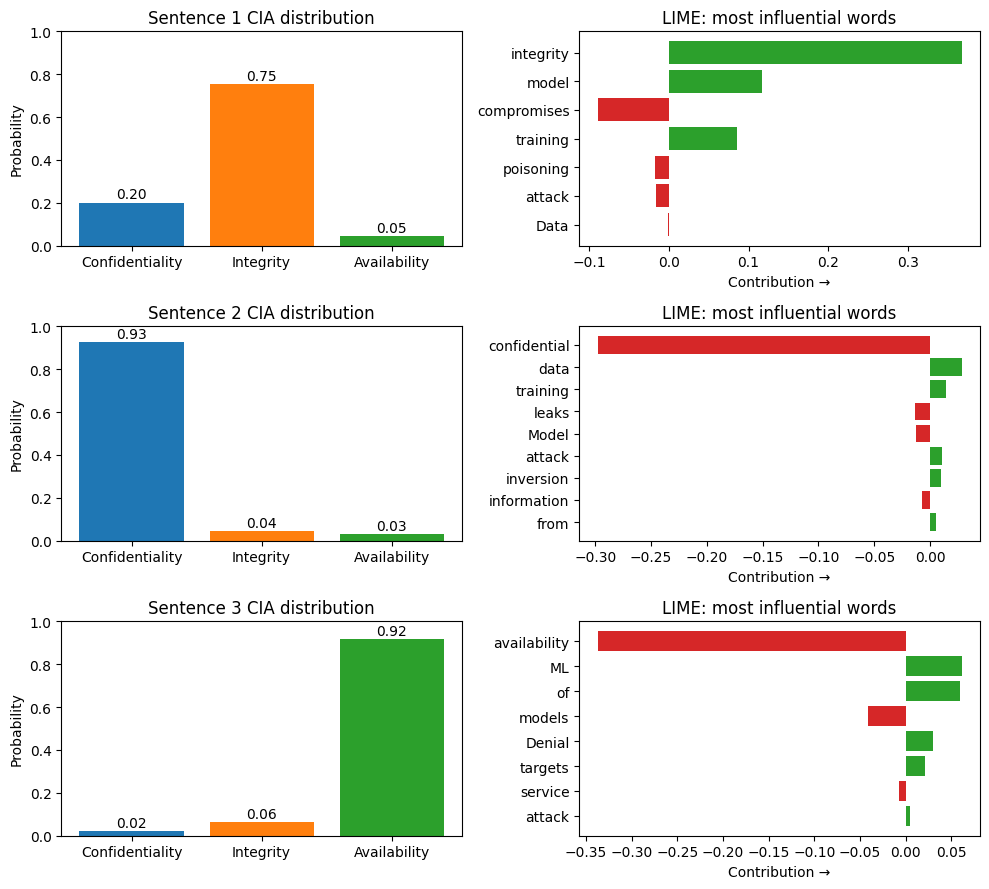

In [6]:
import numpy as np
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt

###############################################################################
#  A.  Inference: zero-shot classification with the CIA labels
###############################################################################
# ↳ BART-MNLI is accurate and multilingual; swap for another if desired
classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=0 if torch.cuda.is_available() else -1,
)

labels_cia = ["Confidentiality", "Integrity", "Availability"]

ttp_texts = [
    "Data poisoning attack compromises model training integrity.",
    "Model inversion attack leaks confidential information from training data.",
    "Denial-of-service attack targets availability of ML models.",
]

def cia_probs(sentences):
    """Return an (N × 3) matrix of P(C), P(I), P(A)."""
    all_probs = []
    for s in sentences:
        out = classifier(s, candidate_labels=labels_cia, multi_label=False)
        # Convert to vector ordered C, I, A
        probs = [out["scores"][out["labels"].index(lbl)] for lbl in labels_cia]
        all_probs.append(probs)
    return np.asarray(all_probs)

probs = cia_probs(ttp_texts)               # shape (3, 3)
print("CIA probabilities\n", probs)

###############################################################################
#  B.  Local explanation with LIME
###############################################################################
#   LIME needs a prediction-function that returns a 2-D numpy array
def lime_predict(ss):
    return cia_probs(ss)

explainer = LimeTextExplainer(class_names=labels_cia)

explanations = [
    explainer.explain_instance(
        text_instance=ttp_texts[i],
        classifier_fn=lime_predict,
        num_features=10,
    )
    for i in range(len(ttp_texts))
]

###############################################################################
#  C.  Visualise both sentence-level probabilities and token importance
###############################################################################
fig, axes = plt.subplots(len(ttp_texts), 2, figsize=(10, 3 * len(ttp_texts)))

for idx, (sent, p_vec, exp) in enumerate(zip(ttp_texts, probs, explanations)):
    # --- left plot: bar chart of P(C), P(I), P(A) ---------------------------
    ax_bar = axes[idx, 0]
    ax_bar.bar(labels_cia, p_vec, color=["tab:blue", "tab:orange", "tab:green"])
    ax_bar.set_ylim(0, 1)
    ax_bar.set_ylabel("Probability")
    ax_bar.set_title(f"Sentence {idx+1} CIA distribution")
    for x, y in zip(labels_cia, p_vec):
        ax_bar.text(x, y + 0.02, f"{y:.2f}", ha="center")

    # --- right plot: LIME token importances ---------------------------------
    ax_lime = axes[idx, 1]
    # LIME returns [(token, weight), …]
    tokens, weights = zip(*exp.as_list(label=exp.available_labels()[0]))
    y_pos = np.arange(len(tokens))
    colors = ["tab:red" if w < 0 else "tab:green" for w in weights]
    ax_lime.barh(y_pos, weights, color=colors)
    ax_lime.set_yticks(y_pos)
    ax_lime.set_yticklabels(tokens)
    ax_lime.invert_yaxis()
    ax_lime.set_xlabel("Contribution →")
    ax_lime.set_title(f"LIME: most influential words")

plt.tight_layout()
plt.show()


CIA probabilities
 [[0.20065083 0.75310719 0.04624197]
 [0.92502826 0.04440321 0.03056849]
 [0.02006277 0.0623065  0.91763079]]


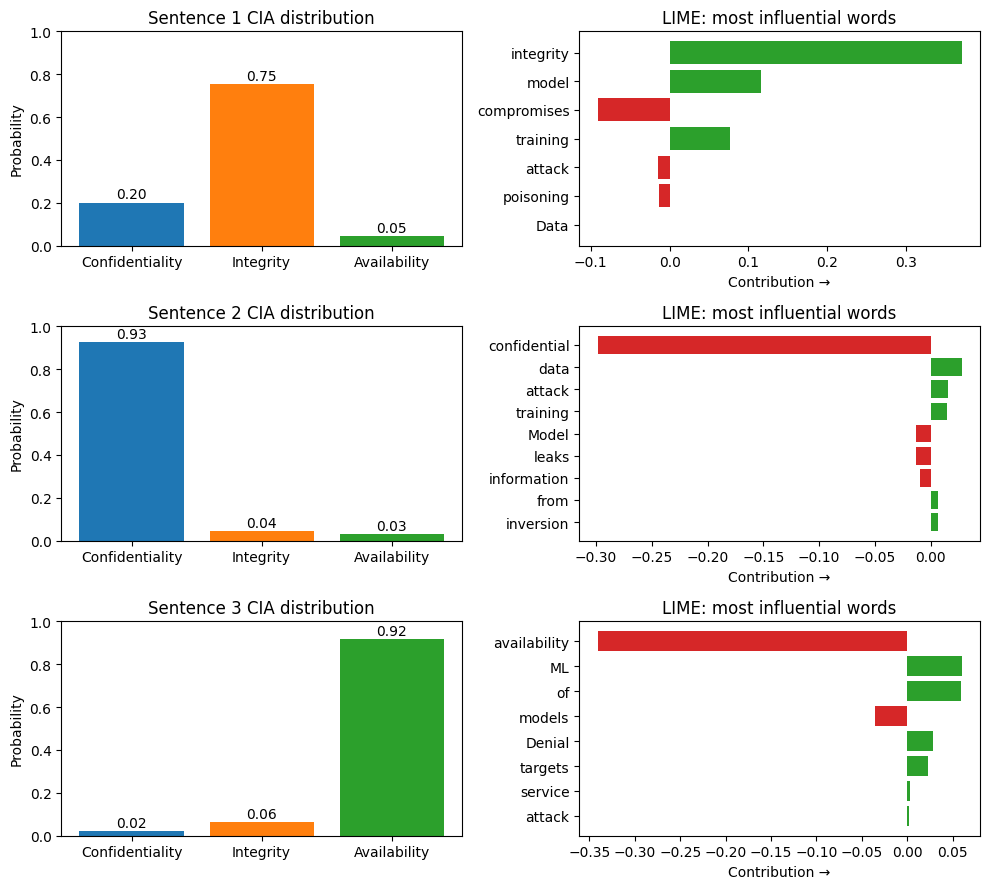

In [10]:
import numpy as np
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt

###############################################################################
#  A.  Inference: zero-shot classification with the CIA labels
###############################################################################
# ↳ BART-MNLI is accurate and multilingual; swap for another if desired
classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=0 if torch.cuda.is_available() else -1,
)

labels_cia = ["Confidentiality", "Integrity", "Availability"]

ttp_texts = [
    "Data poisoning attack compromises model training integrity.",
    "Model inversion attack leaks confidential information from training data.",
    "Denial-of-service attack targets availability of ML models.",
]

def cia_probs(sentences):
    """Return an (N × 3) matrix of P(C), P(I), P(A)."""
    all_probs = []
    for s in sentences:
        out = classifier(s, candidate_labels=labels_cia, multi_label=False)
        # Convert to vector ordered C, I, A
        probs = [out["scores"][out["labels"].index(lbl)] for lbl in labels_cia]
        all_probs.append(probs)
    return np.asarray(all_probs)

probs = cia_probs(ttp_texts)               # shape (3, 3)
print("CIA probabilities\n", probs)

###############################################################################
#  B.  Local explanation with LIME
###############################################################################
#   LIME needs a prediction-function that returns a 2-D numpy array
def lime_predict(ss):
    return cia_probs(ss)

explainer = LimeTextExplainer(class_names=labels_cia)

explanations = [
    explainer.explain_instance(
        text_instance=ttp_texts[i],
        classifier_fn=lime_predict,
        num_features=10,
    )
    for i in range(len(ttp_texts))
]

###############################################################################
#  C.  Visualise both sentence-level probabilities and token importance
###############################################################################
fig, axes = plt.subplots(len(ttp_texts), 2, figsize=(10, 3 * len(ttp_texts)))

for idx, (sent, p_vec, exp) in enumerate(zip(ttp_texts, probs, explanations)):
    # --- left plot: bar chart of P(C), P(I), P(A) ---------------------------
    ax_bar = axes[idx, 0]
    ax_bar.bar(labels_cia, p_vec, color=["tab:blue", "tab:orange", "tab:green"])
    ax_bar.set_ylim(0, 1)
    ax_bar.set_ylabel("Probability")
    ax_bar.set_title(f"Sentence {idx+1} CIA distribution")
    for x, y in zip(labels_cia, p_vec):
        ax_bar.text(x, y + 0.02, f"{y:.2f}", ha="center")

    # --- right plot: LIME token importances ---------------------------------
    ax_lime = axes[idx, 1]
    # LIME returns [(token, weight), …]
    tokens, weights = zip(*exp.as_list(label=exp.available_labels()[0]))
    y_pos = np.arange(len(tokens))
    colors = ["tab:red" if w < 0 else "tab:green" for w in weights]
    ax_lime.barh(y_pos, weights, color=colors)
    ax_lime.set_yticks(y_pos)
    ax_lime.set_yticklabels(tokens)
    ax_lime.invert_yaxis()
    ax_lime.set_xlabel("Contribution →")
    ax_lime.set_title(f"LIME: most influential words")

plt.tight_layout()
fig.savefig("cia_LIME_explanations.png", dpi=300, bbox_inches="tight")  # <- NEW

plt.show()




In [8]:
!open "cia_LIME_explanations.png"

In [2]:

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from lime.lime_text import LimeTextExplainer
import numpy as np
import torch

# Load the model and tokenizer
model_name = "bert-base-uncased"  # Specify your model name
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Define a function to predict probabilities for LIME
def predict_proba(texts):
    # Tokenize all texts in a single batch
    inputs = tokenizer(list(texts), return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    # Apply softmax to the output logits to get probabilities
    probs = torch.softmax(outputs.logits, dim=1).detach().numpy()
    return probs

# Example TTP texts to explain
ttp_text = [
    "Data poisoning attack compromises model training integrity.",
    "Model inversion attack leaks confidential information from training data.",
    "Denial-of-service attack targets availability of ML models."
]

# Initialize the LIME explainer
explainer = LimeTextExplainer(class_names=["Confidentiality", "Integrity", "Availability"])

# Explain the first TTP text using LIME
exp = explainer.explain_instance(ttp_text[2], predict_proba, num_features=10)

# Show the explanation in a notebook
exp.show_in_notebook(text=True)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

2025-07-28 23:35:07.332464: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


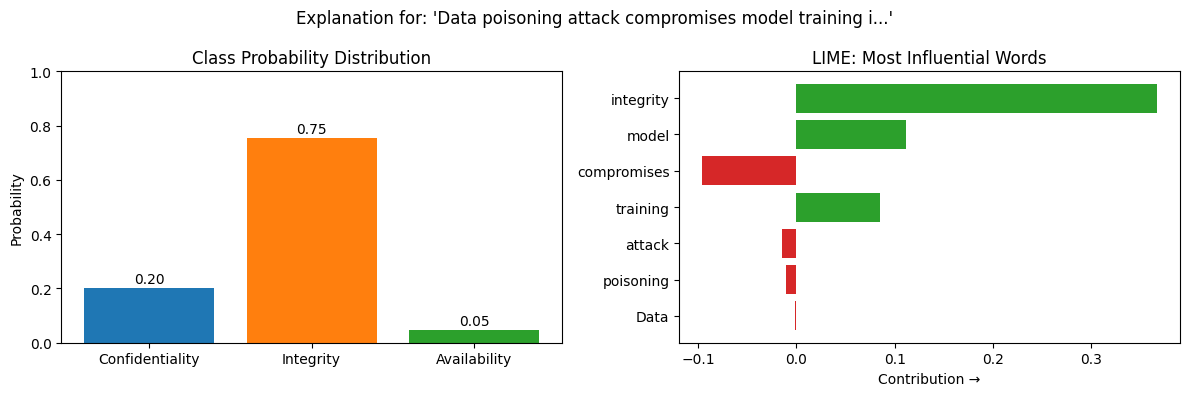

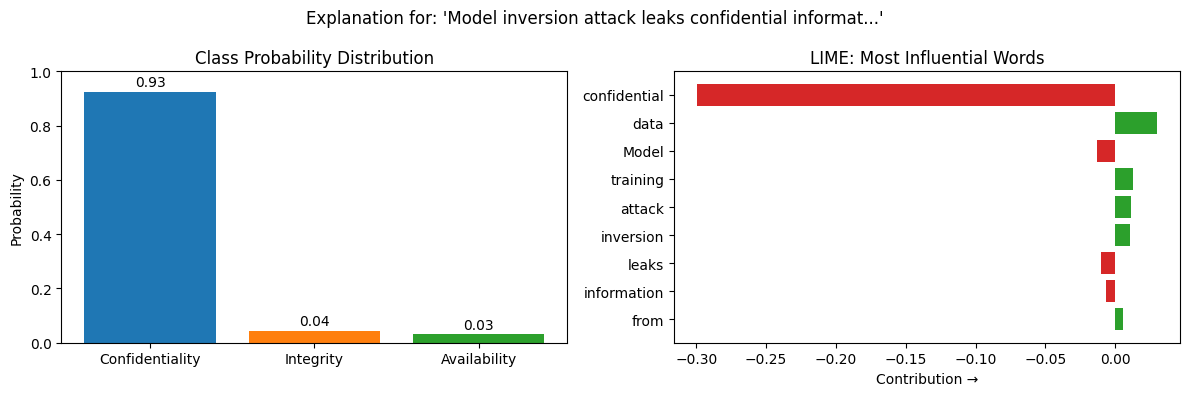

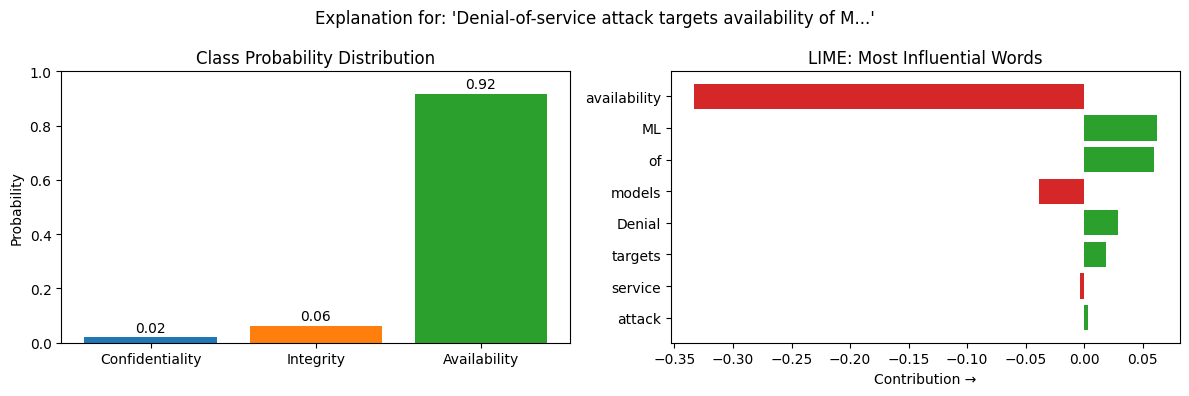

In [3]:
import numpy as np
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

class LIMETextExplainer:
    def __init__(self, model_name: str = "facebook/bart-large-mnli", 
                 class_names: List[str] = None, 
                 device: str = "auto"):
        """
        Initialize LIME text explainer with a HuggingFace model.
        
        Args:
            model_name: Name of the pretrained model
            class_names: List of class names for explanation
            device: "auto", "cuda" or "cpu"
        """
        self.class_names = class_names or ["Confidentiality", "Integrity", "Availability"]
        self.device = 0 if device == "auto" and torch.cuda.is_available() else -1
        
        # Initialize model pipeline
        self.classifier = pipeline(
            "zero-shot-classification",
            model=model_name,
            device=self.device,
        )
        self.explainer = LimeTextExplainer(class_names=self.class_names)
    
    def predict_proba(self, texts: List[str]) -> np.ndarray:
        """
        Predict probabilities for input texts.
        
        Args:
            texts: List of input texts
            
        Returns:
            numpy array of shape (n_texts, n_classes) with probabilities
        """
        results = []
        for text in texts:
            out = self.classifier(text, candidate_labels=self.class_names, multi_label=False)
            probs = [out["scores"][out["labels"].index(label)] for label in self.class_names]
            results.append(probs)
        return np.array(results)
    
    def explain(self, text: str, num_features: int = 10) -> Tuple:
        """
        Generate LIME explanation for a single text.
        
        Args:
            text: Input text to explain
            num_features: Number of features to show in explanation
            
        Returns:
            (explanation object, predicted probabilities)
        """
        explanation = self.explainer.explain_instance(
            text_instance=text,
            classifier_fn=self.predict_proba,
            num_features=num_features,
        )
        pred_probs = self.predict_proba([text])[0]
        return explanation, pred_probs
    
    def visualize_explanation(self, text: str, num_features: int = 10) -> None:
        """
        Generate and visualize LIME explanation for a single text.
        
        Args:
            text: Input text to explain
            num_features: Number of features to show in explanation
        """
        explanation, probs = self.explain(text, num_features)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Probability distribution plot
        ax1.bar(self.class_names, probs, color=["tab:blue", "tab:orange", "tab:green"])
        ax1.set_ylim(0, 1)
        ax1.set_ylabel("Probability")
        ax1.set_title("Class Probability Distribution")
        for x, y in zip(self.class_names, probs):
            ax1.text(x, y + 0.02, f"{y:.2f}", ha="center")
        
        # LIME explanation plot
        tokens, weights = zip(*explanation.as_list(label=explanation.available_labels()[0]))
        y_pos = np.arange(len(tokens))
        colors = ["tab:red" if w < 0 else "tab:green" for w in weights]
        ax2.barh(y_pos, weights, color=colors)
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(tokens)
        ax2.invert_yaxis()
        ax2.set_xlabel("Contribution →")
        ax2.set_title("LIME: Most Influential Words")
        
        plt.suptitle(f"Explanation for: '{text[:50]}{'...' if len(text) > 50 else ''}'")
        plt.tight_layout()
        plt.show()

# Example usage
if __name__ == "__main__":
    # Example texts
    ttp_texts = [
        "Data poisoning attack compromises model training integrity.",
        "Model inversion attack leaks confidential information from training data.",
        "Denial-of-service attack targets availability of ML models.",
    ]
    
    # Initialize explainer
    explainer = LIMETextExplainer()
    
    # Explain and visualize each text
    for text in ttp_texts:
        explainer.visualize_explanation(text)

In [5]:
# ------------------------------------------------------------
# Elegant, batched LIME explanation for CIA labels
# ------------------------------------------------------------
import torch, numpy as np, matplotlib.pyplot as plt
from lime.lime_text import LimeTextExplainer
from transformers import pipeline

DEVICE = 0 if torch.cuda.is_available() else -1
LABELS = ["Confidentiality", "Integrity", "Availability"]

# 1) Zero-shot pipeline (BART-MNLI) handles tokeniser + model + softmax
clf = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=DEVICE,
)

# 2) Batched probability wrapper expected by LIME
def predict_cia(texts: list[str]) -> np.ndarray:
    """Return (N × 3) array of P(C), P(I), P(A)."""
    outs = clf(texts, candidate_labels=LABELS, multi_label=False)
    # Harmonise single-dict vs list-of-dict return
    outs = outs if isinstance(outs, list) else [outs]
    probs = [
        [o["scores"][o["labels"].index(lbl)] for lbl in LABELS]
        for o in outs
    ]
    return np.asarray(probs)

# 3) Example sentences
sentences = [
    "Data poisoning attack compromises model training integrity.",
    "Model inversion attack leaks confidential information from training data.",
    "Denial-of-service attack targets availability of ML models."
]

# 4) Explain any sentence k
k = 1                              # choose 0, 1, or 2
explainer = LimeTextExplainer(class_names=LABELS)
exp = explainer.explain_instance(
    sentences[k],
    classifier_fn=predict_cia,
    num_features=10,
    num_samples=4_000,              # ↑ samples → smoother weights
)

# 5) Pretty-print in notebook OR Matplotlib fallback
try:
    exp.show_in_notebook(text=True)
except Exception:                   # not in a notebook
    tokens, weights = zip(*exp.as_list())
    colours = ["tab:red" if w < 0 else "tab:green" for w in weights]
    plt.figure(figsize=(6, 3))
    plt.barh(range(len(tokens)), weights, color=colours)
    plt.yticks(range(len(tokens)), tokens)
    plt.gca().invert_yaxis()
    plt.title(f"LIME explanation for: «{sentences[k][:40]}…»")
    plt.xlabel("Contribution →")
    plt.tight_layout()
    plt.savefig("lime_CIA.png")
    plt.show()



Processing text 1: Data poisoning attack compromises model training integrity.


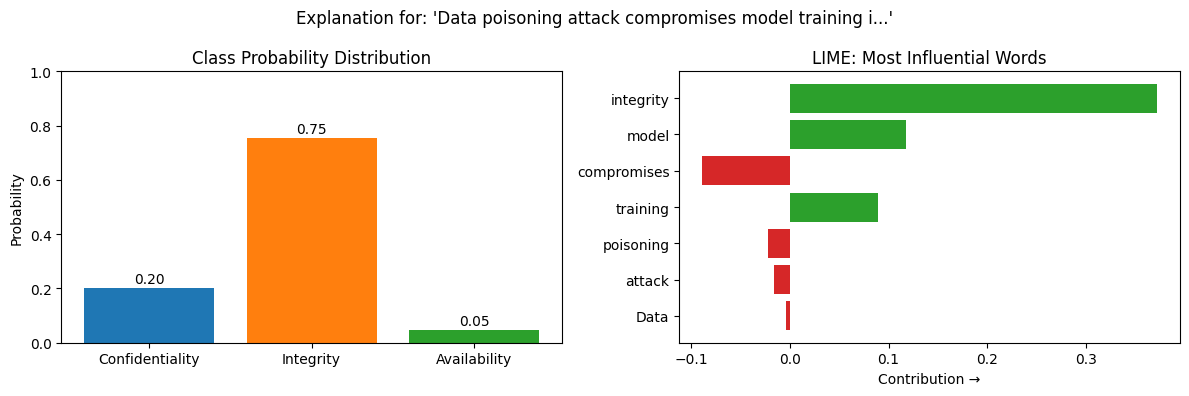

Saved explanation files:
- IMAGE: lime_explanations/explanation_6284703770278156697.png
- JSON: lime_explanations/explanation_6284703770278156697.json
- PICKLE: lime_explanations/explanation_6284703770278156697.pkl

Processing text 2: Model inversion attack leaks confidential information from training data.


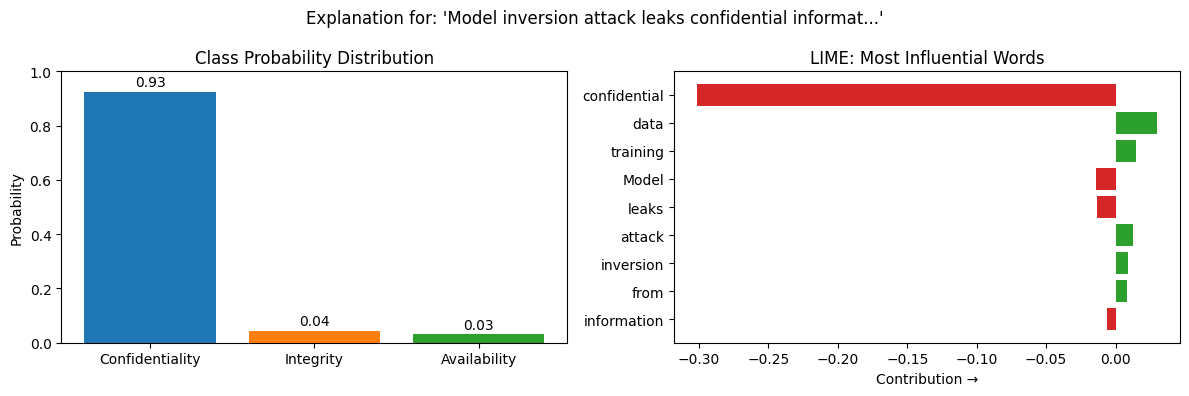

Saved explanation files:
- IMAGE: lime_explanations/explanation_739026288664498308.png
- JSON: lime_explanations/explanation_739026288664498308.json
- PICKLE: lime_explanations/explanation_739026288664498308.pkl

Processing text 3: Denial-of-service attack targets availability of ML models.


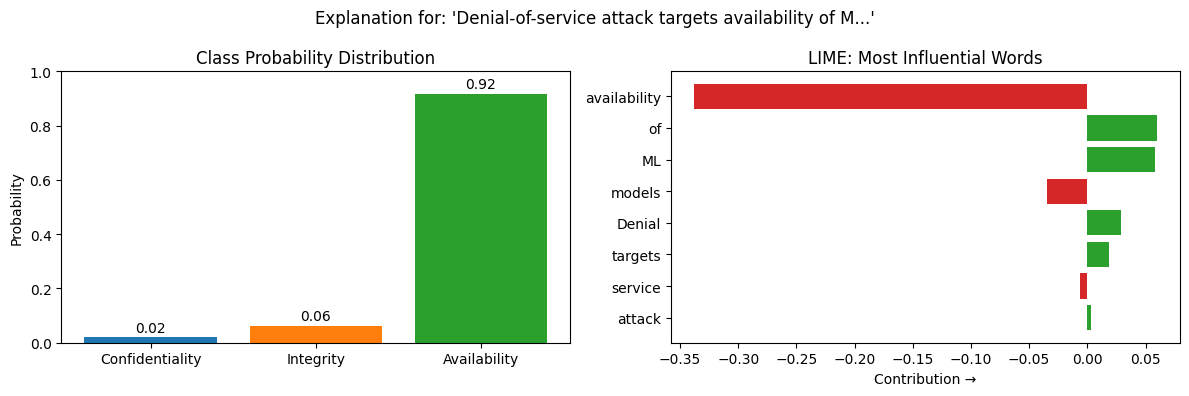

Saved explanation files:
- IMAGE: lime_explanations/explanation_7660794810065856348.png
- JSON: lime_explanations/explanation_7660794810065856348.json
- PICKLE: lime_explanations/explanation_7660794810065856348.pkl


In [7]:
import numpy as np
import torch
from transformers import pipeline
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Any
import json
import pickle
import os

class LIMETextExplainer:
    def __init__(self, model_name: str = "facebook/bart-large-mnli", 
                 class_names: List[str] = None, 
                 device: str = "auto",
                 output_dir: str = "explanations"):
        """
        Initialize LIME text explainer with saving capabilities.
        
        Args:
            model_name: Name of the pretrained model
            class_names: List of class names for explanation
            device: "auto", "cuda" or "cpu"
            output_dir: Directory to save explanations
        """
        self.class_names = class_names or ["Confidentiality", "Integrity", "Availability"]
        self.device = 0 if device == "auto" and torch.cuda.is_available() else -1
        self.output_dir = output_dir
        
        # Create output directory if it doesn't exist
        os.makedirs(self.output_dir, exist_ok=True)
        
        # Initialize model pipeline
        self.classifier = pipeline(
            "zero-shot-classification",
            model=model_name,
            device=self.device,
        )
        self.explainer = LimeTextExplainer(class_names=self.class_names)
    
    def predict_proba(self, texts: List[str]) -> np.ndarray:
        """Predict probabilities for input texts."""
        results = []
        for text in texts:
            out = self.classifier(text, candidate_labels=self.class_names, multi_label=False)
            probs = [out["scores"][out["labels"].index(label)] for label in self.class_names]
            results.append(probs)
        return np.array(results)
    
    def explain(self, text: str, num_features: int = 10) -> Tuple[Any, np.ndarray]:
        """Generate LIME explanation for a single text."""
        explanation = self.explainer.explain_instance(
            text_instance=text,
            classifier_fn=self.predict_proba,
            num_features=num_features,
        )
        pred_probs = self.predict_proba([text])[0]
        return explanation, pred_probs
    
    def save_explanation(self, 
                        explanation: Any, 
                        probs: np.ndarray,
                        text: str,
                        base_filename: str = None) -> Dict[str, str]:
        """
        Save explanation in multiple formats.
        
        Returns:
            Dictionary with paths to saved files
        """
        if base_filename is None:
            base_filename = f"explanation_{hash(text)}"
        
        save_paths = {}
        
        # 1. Save visualization as PNG
        fig = self._create_visualization(explanation, probs, text)
        img_path = os.path.join(self.output_dir, f"{base_filename}.png")
        fig.savefig(img_path, dpi=300, bbox_inches='tight')
        plt.close(fig)
        save_paths['image'] = img_path
        
        # 2. Save raw explanation data as JSON
        exp_data = {
            'text': text,
            'probabilities': dict(zip(self.class_names, probs.tolist())),
            'features': explanation.as_list(),
            'local_pred': explanation.local_pred.tolist(),
            'score': explanation.score
        }
        json_path = os.path.join(self.output_dir, f"{base_filename}.json")
        with open(json_path, 'w') as f:
            json.dump(exp_data, f, indent=2)
        save_paths['json'] = json_path
        
        # 3. Save pickle of full explanation object
        pickle_path = os.path.join(self.output_dir, f"{base_filename}.pkl")
        with open(pickle_path, 'wb') as f:
            pickle.dump(explanation, f)
        save_paths['pickle'] = pickle_path
        
        return save_paths
    
    def _create_visualization(self, explanation, probs, text):
        """Create visualization figure."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Probability distribution plot
        ax1.bar(self.class_names, probs, color=["tab:blue", "tab:orange", "tab:green"])
        ax1.set_ylim(0, 1)
        ax1.set_ylabel("Probability")
        ax1.set_title("Class Probability Distribution")
        for x, y in zip(self.class_names, probs):
            ax1.text(x, y + 0.02, f"{y:.2f}", ha="center")
        
        # LIME explanation plot
        tokens, weights = zip(*explanation.as_list(label=explanation.available_labels()[0]))
        y_pos = np.arange(len(tokens))
        colors = ["tab:red" if w < 0 else "tab:green" for w in weights]
        ax2.barh(y_pos, weights, color=colors)
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(tokens)
        ax2.invert_yaxis()
        ax2.set_xlabel("Contribution →")
        ax2.set_title("LIME: Most Influential Words")
        
        plt.suptitle(f"Explanation for: '{text[:50]}{'...' if len(text) > 50 else ''}'")
        plt.tight_layout()
        return fig
    
    def visualize_and_save(self, text: str, num_features: int = 10) -> Dict[str, str]:
        """
        Generate, visualize, and save explanation for a single text.
        
        Returns:
            Dictionary with paths to saved files
        """
        explanation, probs = self.explain(text, num_features)
        
        # Show visualization
        fig = self._create_visualization(explanation, probs, text)
        plt.show()
        plt.close(fig)
        
        # Save all formats
        return self.save_explanation(explanation, probs, text)

# Example usage
if __name__ == "__main__":
    # Example texts
    ttp_texts = [
        "Data poisoning attack compromises model training integrity.",
        "Model inversion attack leaks confidential information from training data.",
        "Denial-of-service attack targets availability of ML models.",
    ]
    
    # Initialize explainer with output directory
    explainer = LIMETextExplainer(output_dir="lime_explanations")
    
    # Process each text
    for i, text in enumerate(ttp_texts):
        print(f"\nProcessing text {i+1}: {text}")
        save_paths = explainer.visualize_and_save(text)
        
        print("Saved explanation files:")
        for format_type, path in save_paths.items():
            print(f"- {format_type.upper()}: {path}")

In [9]:
!open "lime_explanations/explanation_6284703770278156697.png"

In [ ]:
# ------------------------------------------------------------
# Enhanced LIME Explanation with Professional Visualization
# ------------------------------------------------------------
import torch
import numpy as np
import matplotlib.pyplot as plt
from lime.lime_text import LimeTextExplainer
from transformers import pipeline
from typing import List
import os

# Configuration
DEVICE = 0 if torch.cuda.is_available() else -1
LABELS = ["Confidentiality", "Integrity", "Availability"]
OUTPUT_DIR = "lime_explanations"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1) Initialize zero-shot classifier
clf = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=DEVICE,
)

# 2) Batched probability prediction
def predict_cia(texts: List[str]) -> np.ndarray:
    """Return (N × 3) array of P(C), P(I), P(A)."""
    outs = clf(texts, candidate_labels=LABELS, multi_label=False)
    outs = outs if isinstance(outs, list) else [outs]  # Handle single/multi input
    return np.array([
        [o["scores"][o["labels"].index(lbl)] for lbl in LABELS]
        for o in outs
    ])

# 3) Enhanced visualization function
def save_lime_plot(exp, sentence: str, filename: str = None):
    """Generate publication-quality LIME plot and save to file."""
    tokens, weights = zip(*exp.as_list())
    colors = ["#d62728" if w < 0 else "#2ca02c" for w in weights]  # Better colors
    
    plt.figure(figsize=(8, 4))
    bars = plt.barh(range(len(tokens)), weights, color=colors, alpha=0.7)
    
    # Add value annotations
    for bar in bars:
        width = bar.get_width()
        plt.text(width/2, bar.get_y() + bar.get_height()/2,
                f"{width:.2f}",
                ha='center', va='center',
                color='white' if abs(width) > 0.15 else 'black')
    
    plt.yticks(range(len(tokens)), tokens, fontsize=10)
    plt.gca().invert_yaxis()
    plt.title(f"LIME Explanation: «{sentence[:50]}{'...' if len(sentence) > 50 else ''}»", pad=20)
    plt.xlabel("Feature Contribution Score", labelpad=10)
    plt.grid(axis='x', alpha=0.2)
    
    # Add legend
    plt.legend([plt.Rectangle((0,0),1,1, fc=c) for c in ["#2ca02c", "#d62728"]],
              ['Positive Contribution', 'Negative Contribution'],
              bbox_to_anchor=(1, 1), loc='upper left')
    
    plt.tight_layout()
    
    # Save with metadata
    if not filename:
        filename = f"lime_explanation_{hash(sentence)}.png"
    save_path = os.path.join(OUTPUT_DIR, filename)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    return save_path

# 4) Example sentences
sentences = [
    "Data poisoning attack compromises model training integrity.",
    "Model inversion attack leaks confidential information from training data.",
    "Denial-of-service attack targets availability of ML models."
]

# 5) Explanation pipeline
def explain_sentence(sentence: str, index: int = None) -> dict:
    """Generate and save complete LIME explanation."""
    explainer = LimeTextExplainer(class_names=LABELS)
    exp = explainer.explain_instance(
        sentence,
        classifier_fn=predict_cia,
        num_features=10,
        num_samples=5000,  # Increased for stability
        top_labels=1
    )
    
    # Try notebook display first
    try:
        exp.show_in_notebook(text=True)
    except Exception:
        pass
    
    # Generate and save enhanced visualization
    img_path = save_lime_plot(exp, sentence, f"explanation_{index or hash(sentence)}.png")
    
    # Return all explanation data
    return {
        "sentence": sentence,
        "label": LABELS[exp.top_labels[0]],
        "features": exp.as_list(),
        "visualization": img_path,
        "local_pred": exp.local_pred.tolist(),
        "score": exp.score
    }

# 6) Execute explanations
results = []
for idx, sentence in enumerate(sentences):
    print(f"\nExplaining sentence {idx+1}: {sentence}")
    results.append(explain_sentence(sentence, idx))
    print(f"→ Visualization saved to {results[-1]['visualization']}")

# Print summary
print("\nExplanation Summary:")
for res in results:
    print(f"\nSentence: {res['sentence']}")
    print(f"Predicted label: {res['label']}")
    print(f"Top features: {[f[0] for f in res['features'][:3]]}...")

2025-07-29 22:23:33.544693: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



Explaining sentence 1: Data poisoning attack compromises model training integrity.


In [15]:
# # ###############################################################################
# # #  A.  Model & helper that outputs P(C), P(I), P(A)
# # ###############################################################################
# # from transformers import pipeline
# # import numpy as np
# # import torch
# # import shap
# # import matplotlib.pyplot as plt

# # # labels_cia = ["Confidentiality", "Integrity", "Availability"]

# # # # Hugging-Face zero-shot classifier
# # # classifier = pipeline(
# # #     "zero-shot-classification",
# # #     model="facebook/bart-large-mnli",
# # #     device=0 if torch.cuda.is_available() else -1,
# # # )

# # # def cia_probs(sentences):
# # #     """
# # #     Return an (N × 3) numpy array of probabilities
# # #     ordered [Confidentiality, Integrity, Availability].
# # #     """
# # #     out_mat = []
# # #     for s in sentences:
# # #         out = classifier(s, candidate_labels=labels_cia, multi_label=False)
# # #         probs = [out["scores"][out["labels"].index(lbl)] for lbl in labels_cia]
# # #         out_mat.append(probs)
# # #     return np.asarray(out_mat)

# # # ###############################################################################
# # # #  B.  SHAP Explainer
# # # ###############################################################################
# # # #  shap.Explainer can wrap a Hugging-Face pipeline directly,
# # # #  but we supply a lightweight callable returning *only* the prob-matrix.
# # # explainer = shap.Explainer(cia_probs, algorithm="permutation")

# # # ttp_texts = [
# # #     "Data poisoning attack compromises model training integrity.",
# # #     "Model inversion attack leaks confidential information from training data.",
# # #     "Denial-of-service attack targets availability of ML models."
# # # ]

# # # shap_values = explainer(ttp_texts)   # length == 3 (one entry per sentence)



# # labels_cia = ["Confidentiality", "Integrity", "Availability"]

# # classifier = pipeline(
# #     "zero-shot-classification",
# #     model="facebook/bart-large-mnli",
# #     device=0  # -1 for CPU
# # )

# # # SHAP picks a TextMasker + "partition" algorithm by default
# # explainer = shap.Explainer(classifier, output_names=labels_cia)

# # # Your sentences
# # ttp_texts = [
# #     "Data poisoning attack compromises model training integrity.",
# #     "Model inversion attack leaks confidential information from training data.",
# #     "Denial-of-service attack targets availability of ML models."
# # ]

# # shap_values = explainer(ttp_texts)   # ← works


# import numpy as np
# import shap
# from transformers import pipeline
# import torch
# import matplotlib.pyplot as plt

# # ------------------------------------------------------------------
# # A.  Zero-shot pipeline with our three CIA labels
# # ------------------------------------------------------------------
# labels_cia = ["Confidentiality", "Integrity", "Availability"]
# clf = pipeline(
#     "zero-shot-classification",
#     model="facebook/bart-large-mnli",
#     device=0  # set −1 to force CPU
# )

# # ------------------------------------------------------------------
# # B.  Wrapper that always supplies `candidate_labels`
# #     and returns an (N × 3) NumPy array of probabilities
# # ------------------------------------------------------------------
# def cia_prob_fn(text_list):
#     out = clf(
#         text_list,
#         candidate_labels=labels_cia,   # <- crucial!
#         multi_label=False
#     )
#     # hf pipeline returns a dict *per input*, we stack them:
#     rows = []
#     for d in out:
#         rows.append([d["scores"][d["labels"].index(lbl)] for lbl in labels_cia])
#     return np.asarray(rows)

# # ------------------------------------------------------------------
# # C.  Build a Text masker from the same tokenizer
# # ------------------------------------------------------------------
# masker = shap.maskers.Text(clf.tokenizer)

# # ------------------------------------------------------------------
# # D.  SHAP explainer
# #     algorithm="permutation" works; "partition" also works & is faster
# # ------------------------------------------------------------------
# explainer = shap.Explainer(
#     cia_prob_fn,
#     masker=masker,
#     algorithm="partition",   # or "permutation"
#     output_names=labels_cia,
# )

# # ------------------------------------------------------------------
# # E.  Explain your sentences
# # ------------------------------------------------------------------
# ttp_texts = [
#     "Data poisoning attack compromises model training integrity.",
#     "Model inversion attack leaks confidential information from training data.",
#     "Denial-of-service attack targets availability of ML models."
# ]
# shap_values = explainer(ttp_texts)   # ✅ no error now




# ###############################################################################
# #  C.  Plot & save
# ###############################################################################
# fig, axes = plt.subplots(len(ttp_texts), 2, figsize=(11, 3.3 * len(ttp_texts)))

# for idx, (sentence, sv) in enumerate(zip(ttp_texts, shap_values)):
#     # -----------------------------------------------------------------------
#     # (1) Probability bars
#     # -----------------------------------------------------------------------
#     probs = cia_probs([sentence]).flatten()
#     ax_prob = axes[idx, 0]
#     ax_prob.bar(labels_cia, probs,
#                 color=["tab:blue", "tab:orange", "tab:green"])
#     ax_prob.set_ylim(0, 1)
#     ax_prob.set_ylabel("Probability")
#     ax_prob.set_title(f"Sentence {idx+1}: CIA distribution")
#     for x, y in zip(labels_cia, probs):
#         ax_prob.text(x, y + 0.02, f"{y:.2f}", ha="center", fontsize=10)

#     # -----------------------------------------------------------------------
#     # (2) SHAP token contributions (class with max-prob for clarity)
#     # -----------------------------------------------------------------------
#     target_class = int(np.argmax(probs))        # 0=C, 1=I, 2=A
#     values = sv.values[:, target_class]         # shape: (#tokens,)
#     tokens = sv.data                            # list of string tokens

#     # Sort by absolute impact, keep top-10 for readability
#     order = np.argsort(-np.abs(values))[:10]
#     tokens_shown = [tokens[i] for i in order]
#     vals_shown   = values[order]

#     colors = ["tab:red" if v < 0 else "tab:green" for v in vals_shown]
#     y_pos = np.arange(len(tokens_shown))

#     ax_shap = axes[idx, 1]
#     ax_shap.barh(y_pos, vals_shown, color=colors)
#     ax_shap.set_yticks(y_pos)
#     ax_shap.set_yticklabels(tokens_shown)
#     ax_shap.invert_yaxis()
#     ax_shap.set_xlabel(f"SHAP value for {labels_cia[target_class]}")
#     ax_shap.set_title("Top token contributions")

# plt.tight_layout()
# fig.savefig("cia_shap_explanations.png", dpi=300, bbox_inches="tight")
# plt.show()

# print("🍃  Figure saved →  cia_shap_explanations.png")


In [ ]:
ttp_texts = [
    # ──── Poisoning & Backdoors ────────────────────────────────────────────
    "Backdoor poisoning attack implants a trigger pattern during training, hijacking model predictions at inference.",  # Integrity & Confidentiality
    # NIST AI-100 summary of backdoor poisoning :contentReference[oaicite:0]{index=0}

    "Data-poisoning label-flipping corrupts minority-class samples, silently biasing a fraud-detection model.",  # Integrity
    # Practical poisoning modes discussed in industry blog :contentReference[oaicite:1]{index=1}

    # ──── Privacy-oriented Attacks ─────────────────────────────────────────
    "Membership-inference attack reveals whether specific individuals’ records were in the training set, breaching privacy.",  # Confidentiality
    # Recent survey & case studies :contentReference[oaicite:2]{index=2}

    "Gradient-inversion attack in federated learning reconstructs private training images from shared gradients.",  # Confidentiality
    # Fast gradient-leakage findings :contentReference[oaicite:3]{index=3}

    # ──── Model Theft / Extraction ────────────────────────────────────────
    "Adaptive query-based model-extraction attack recreates a proprietary model’s functionality via its public API.",  # Confidentiality & Integrity
    # Survey of LLM extraction techniques :contentReference[oaicite:4]{index=4}

    # ──── Prompt-Injection / Prompt-Extraction ────────────────────────────
    "Indirect prompt-injection embeds invisible instructions in e-mail text, coercing Gemini AI to leak credentials.",  # Confidentiality
    # Gemini ‘invisible prompt’ incident :contentReference[oaicite:5]{index=5}

    "Prompt-extraction attack chains carefully crafted queries to reveal a system prompt from a production LLM.",  # Confidentiality
    # Academic analysis of prompt extraction :contentReference[oaicite:6]{index=6}

    # ──── Adversarial Examples in the Physical World ──────────────────────
    "Physical adversarial stickers on a stop sign make an autonomous-driving model misclassify it as a speed-limit sign.",  # Integrity & Availability
    # RP2 ‘stop-sign’ study :contentReference[oaicite:7]{index=7}

    # ──── Evasion / IDS bypass ────────────────────────────────────────────
    "Carefully crafted CAN-bus messages evade the in-vehicle intrusion-detection model, suppressing alerts.",  # Integrity & Availability
    # IDS-evasion work in automotive ML :contentReference[oaicite:8]{index=8}

    # ──── Supply-Chain & MLOps Pipeline Attacks ───────────────────────────
    "Malicious Python package executes code at install-time, injecting a backdoor into every model built with the library.",  # Integrity
    # Supply-chain poisoning of ML libraries :contentReference[oaicite:9]{index=9}

    "Exploiting insecure MLOps pipelines, attackers replace checkpoints with trojanised models that execute on deployment.",  # Integrity
    # JFrog report on ML pipeline hijacks :contentReference[oaicite:10]{index=10}

    # ──── Availability / DoS Variants ─────────────────────────────────────
    "GPU-resource-exhaustion attack floods the inference API with oversized inputs, triggering out-of-memory crashes.",  # Availability
    # Resource-exhaustion risk highlighted in ML-ops security advisory :contentReference[oaicite:11]{index=11}
]


CIA probabilities
 [[0.11466147 0.40334749 0.48199099]
 [0.19449465 0.32128486 0.48422053]
 [0.73279053 0.13100465 0.13620487]
 [0.20382692 0.38637373 0.40979934]
 [0.25634313 0.40837702 0.33527982]
 [0.13162047 0.33189392 0.53648561]
 [0.10013968 0.54460996 0.35525039]
 [0.1369171  0.29657859 0.5665043 ]
 [0.34225401 0.32305756 0.3346884 ]
 [0.14628686 0.35474136 0.49897185]
 [0.15149724 0.53624082 0.31226191]
 [0.17803083 0.4003737  0.42159548]]


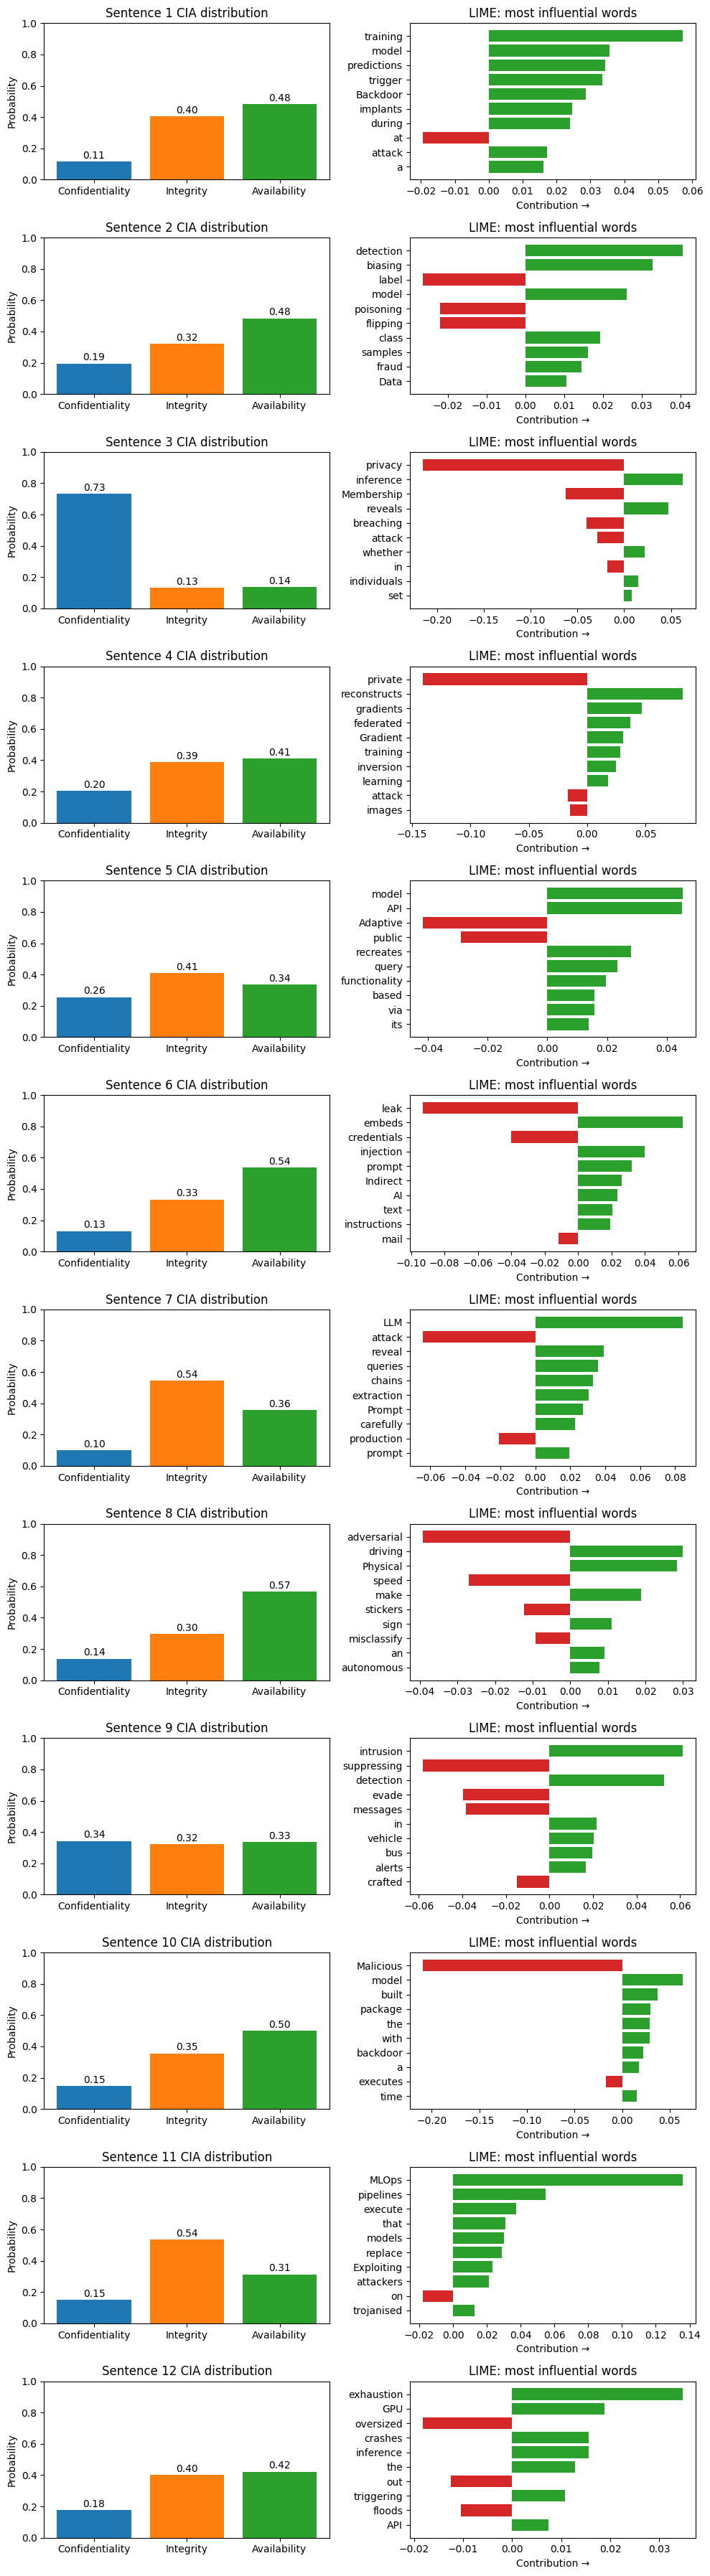

In [12]:
import numpy as np
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt

###############################################################################
#  A.  Inference: zero-shot classification with the CIA labels
###############################################################################
# ↳ BART-MNLI is accurate and multilingual; swap for another if desired
classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=0 if torch.cuda.is_available() else -1,
)

labels_cia = ["Confidentiality", "Integrity", "Availability"]

ttp_texts = [
    # ──── Poisoning & Backdoors ────────────────────────────────────────────
    "Backdoor poisoning attack implants a trigger pattern during training, hijacking model predictions at inference.",  # Integrity & Confidentiality
    # NIST AI-100 summary of backdoor poisoning :contentReference[oaicite:0]{index=0}

    "Data-poisoning label-flipping corrupts minority-class samples, silently biasing a fraud-detection model.",  # Integrity
    # Practical poisoning modes discussed in industry blog :contentReference[oaicite:1]{index=1}

    # ──── Privacy-oriented Attacks ─────────────────────────────────────────
    "Membership-inference attack reveals whether specific individuals’ records were in the training set, breaching privacy.",  # Confidentiality
    # Recent survey & case studies :contentReference[oaicite:2]{index=2}

    "Gradient-inversion attack in federated learning reconstructs private training images from shared gradients.",  # Confidentiality
    # Fast gradient-leakage findings :contentReference[oaicite:3]{index=3}

    # ──── Model Theft / Extraction ────────────────────────────────────────
    "Adaptive query-based model-extraction attack recreates a proprietary model’s functionality via its public API.",  # Confidentiality & Integrity
    # Survey of LLM extraction techniques :contentReference[oaicite:4]{index=4}

    # ──── Prompt-Injection / Prompt-Extraction ────────────────────────────
    "Indirect prompt-injection embeds invisible instructions in e-mail text, coercing Gemini AI to leak credentials.",  # Confidentiality
    # Gemini ‘invisible prompt’ incident :contentReference[oaicite:5]{index=5}

    "Prompt-extraction attack chains carefully crafted queries to reveal a system prompt from a production LLM.",  # Confidentiality
    # Academic analysis of prompt extraction :contentReference[oaicite:6]{index=6}

    # ──── Adversarial Examples in the Physical World ──────────────────────
    "Physical adversarial stickers on a stop sign make an autonomous-driving model misclassify it as a speed-limit sign.",  # Integrity & Availability
    # RP2 ‘stop-sign’ study :contentReference[oaicite:7]{index=7}

    # ──── Evasion / IDS bypass ────────────────────────────────────────────
    "Carefully crafted CAN-bus messages evade the in-vehicle intrusion-detection model, suppressing alerts.",  # Integrity & Availability
    # IDS-evasion work in automotive ML :contentReference[oaicite:8]{index=8}

    # ──── Supply-Chain & MLOps Pipeline Attacks ───────────────────────────
    "Malicious Python package executes code at install-time, injecting a backdoor into every model built with the library.",  # Integrity
    # Supply-chain poisoning of ML libraries :contentReference[oaicite:9]{index=9}

    "Exploiting insecure MLOps pipelines, attackers replace checkpoints with trojanised models that execute on deployment.",  # Integrity
    # JFrog report on ML pipeline hijacks :contentReference[oaicite:10]{index=10}

    # ──── Availability / DoS Variants ─────────────────────────────────────
    "GPU-resource-exhaustion attack floods the inference API with oversized inputs, triggering out-of-memory crashes.",  # Availability
    # Resource-exhaustion risk highlighted in ML-ops security advisory :contentReference[oaicite:11]{index=11}
]


def cia_probs(sentences):
    """Return an (N × 3) matrix of P(C), P(I), P(A)."""
    all_probs = []
    for s in sentences:
        out = classifier(s, candidate_labels=labels_cia, multi_label=False)
        # Convert to vector ordered C, I, A
        probs = [out["scores"][out["labels"].index(lbl)] for lbl in labels_cia]
        all_probs.append(probs)
    return np.asarray(all_probs)

probs = cia_probs(ttp_texts)               # shape (3, 3)
print("CIA probabilities\n", probs)

###############################################################################
#  B.  Local explanation with LIME
###############################################################################
#   LIME needs a prediction-function that returns a 2-D numpy array
def lime_predict(ss):
    return cia_probs(ss)

explainer = LimeTextExplainer(class_names=labels_cia)

explanations = [
    explainer.explain_instance(
        text_instance=ttp_texts[i],
        classifier_fn=lime_predict,
        num_features=10,
    )
    for i in range(len(ttp_texts))
]

###############################################################################
#  C.  Visualise both sentence-level probabilities and token importance
###############################################################################
fig, axes = plt.subplots(len(ttp_texts), 2, figsize=(10, 3 * len(ttp_texts)))

for idx, (sent, p_vec, exp) in enumerate(zip(ttp_texts, probs, explanations)):
    # --- left plot: bar chart of P(C), P(I), P(A) ---------------------------
    ax_bar = axes[idx, 0]
    ax_bar.bar(labels_cia, p_vec, color=["tab:blue", "tab:orange", "tab:green"])
    ax_bar.set_ylim(0, 1)
    ax_bar.set_ylabel("Probability")
    ax_bar.set_title(f"Sentence {idx+1} CIA distribution")
    for x, y in zip(labels_cia, p_vec):
        ax_bar.text(x, y + 0.02, f"{y:.2f}", ha="center")

    # --- right plot: LIME token importances ---------------------------------
    ax_lime = axes[idx, 1]
    # LIME returns [(token, weight), …]
    tokens, weights = zip(*exp.as_list(label=exp.available_labels()[0]))
    y_pos = np.arange(len(tokens))
    colors = ["tab:red" if w < 0 else "tab:green" for w in weights]
    ax_lime.barh(y_pos, weights, color=colors)
    ax_lime.set_yticks(y_pos)
    ax_lime.set_yticklabels(tokens)
    ax_lime.invert_yaxis()
    ax_lime.set_xlabel("Contribution →")
    ax_lime.set_title(f"LIME: most influential words")

plt.tight_layout()
fig.savefig("cia_LIME_explanations.png", dpi=300, bbox_inches="tight")  # <- NEW

plt.show()




In [1]:
!open "cia_LIME_explanations.png"

In [2]:
# # ======================================================================
# #  CIA  SHAP  END-TO-END  DEMO
# # ======================================================================
# import os, numpy as np, matplotlib.pyplot as plt, shap
# from datasets import Dataset
# from transformers import (
#     AutoTokenizer, AutoModelForSequenceClassification,
#     Trainer, TrainingArguments, pipeline
# )
# from transformers import TrainingArguments, Trainer


# # ───────────────────────────────────────────────────────────────────
# #  STEP 0 · CONFIG
# # ───────────────────────────────────────────────────────────────────
# MODEL_DIR   = "cia_classifier"     # will load from / save to this folder
# BACKBONE    = "prajjwal1/bert-tiny"  # tiny => quick fine-tune on CPU
# NUM_LABELS  = 3
# LABELS_CIA  = ["Confidentiality", "Integrity", "Availability"]
# TRAIN_IF_NEEDED = True             # flip to False if model already exists


# # ───────────────────────────────────────────────────────────────────
# #  STEP 1 · (OPTIONAL) QUICK FINE-TUNE IF MODEL NOT ON DISK
# # ───────────────────────────────────────────────────────────────────
# if TRAIN_IF_NEEDED and not os.path.exists(MODEL_DIR):
#     print("→ Fine-tuning tiny BERT for CIA …")

#     # 30 practical TTP sentences (10 × C/I/A)
#     texts = [
#         # Confidentiality
#         "Membership-inference attack reveals dataset presence.",
#         "Gradient inversion reconstructs MRI scans from updates.",
#         "Prompt extraction leaks hidden system prompt.",
#         "Model cloning via API recreates proprietary network.",
#         "Side-channel attack steals cached embeddings.",
#         "Watermark removal defeats ownership claim.",
#         "Weights leak through mis-configured private repo.",
#         "Data broker re-identifies anonymised embeddings.",
#         "LLM jailbreak discloses private conversation.",
#         "Cloud ML snapshot inadvertently exposed weights.",
#         # Integrity
#         "Label-flipping poison skews fraud predictions.",
#         "Backdoor trigger forces misclassification.",
#         "Trojan checkpoint runs shellcode at import.",
#         "Adversarial sticker fools stop-sign detector.",
#         "Parseval bypass lets FGSM noise succeed.",
#         "Poisoned package alters torch.sigmoid silently.",
#         "Template poison adds gothic watermark to faces.",
#         "Reward-model tweak biases answers politically.",
#         "Edge-perturbation flips GNN node labels.",
#         "Voice-command poison unlocks smart lock.",
#         # Availability
#         "OOM flood crashes GPU inference server.",
#         "Denial-of-service spikes API latency to 60 s.",
#         "Malformed protobuf crashes TensorFlow Serving.",
#         "Patch attack drains drone battery in hover loop.",
#         "Excessive quantisation removal crashes model.",
#         "Slow-loris frames block gRPC pods.",
#         "API-key brute-force exhausts licence pool.",
#         "Large JSON prompts trigger log flood OOM.",
#         "Fault injection flips bits, watchdog resets.",
#         "Parallel token streams max CPU, denying tenants.",
#     ]
#     labels = ["Confidentiality"]*10 + ["Integrity"]*10 + ["Availability"]*10
#     label2id = {lbl:i for i,lbl in enumerate(LABELS_CIA)}
#     id2label = {i:lbl for lbl,i in label2id.items()}

#     ds = Dataset.from_dict(
#         {"text": texts, "label": [label2id[l] for l in labels]}
#     ).train_test_split(test_size=0.2, seed=42)

#     tok = AutoTokenizer.from_pretrained(BACKBONE)

#     def encode(batch):
#         return tok(batch["text"], truncation=True, padding="max_length")
#     ds_enc = ds.map(encode, batched=True).remove_columns(["text"])

#     model = AutoModelForSequenceClassification.from_pretrained(
#         BACKBONE, num_labels=NUM_LABELS, id2label=id2label, label2id=label2id
#     )

#     # tr_args = TrainingArguments(
#     #     output_dir="./tmp_cia",
#     #     per_device_train_batch_size=8,
#     #     per_device_eval_batch_size=8,
#     #     num_train_epochs=3,
#     #     learning_rate=3e-5,
#     #     evaluation_strategy="epoch",
#     #     logging_strategy="epoch",
#     #     save_strategy="epoch",
#     #     load_best_model_at_end=True,
#     #     metric_for_best_model="eval_loss",
#     # )

#     # trainer = Trainer(
#     #     model=model,
#     #     args=tr_args,
#     #     train_dataset=ds_enc["train"],
#     #     eval_dataset=ds_enc["test"],
#     #     tokenizer=tok,
#     # )
#     # trainer.train()
#     # model.save_pretrained(MODEL_DIR)
#     # tok.save_pretrained(MODEL_DIR)



#     from transformers import TrainingArguments, Trainer
# # … (the rest of the imports are the same)

# # ───────────────────────────────────────────────────────────────────
# #  STEP 1 · Fine-tune tiny BERT (only if needed)
# # ───────────────────────────────────────────────────────────────────

# if TRAIN_IF_NEEDED and not os.path.exists(MODEL_DIR):
#     # … build tiny dataset exactly as before …

#     tr_args = TrainingArguments(
#         output_dir="./tmp_cia",
#         per_device_train_batch_size=8,
#         per_device_eval_batch_size=8,
#         num_train_epochs=3,
#         learning_rate=3e-5,
#         evaluation_strategy="epoch",
#         logging_strategy="epoch",
#         save_strategy="epoch",
#         load_best_model_at_end=True,
#         metric_for_best_model="eval_loss",
#         save_safetensors=False,          # ★  turn OFF safetensors
#     )

#     trainer = Trainer(
#         model=model,
#         args=tr_args,
#         train_dataset=ds_enc["train"],
#         eval_dataset=ds_enc["test"],
#         tokenizer=tok,
#     )
#     trainer.train()

#     # Handy: save again in PyTorch format, just to be sure
#     model.save_pretrained(MODEL_DIR, safe_serialization=False)  # ★
#     tok.save_pretrained(MODEL_DIR)

#     print(f"✓  Model saved to {MODEL_DIR}")

# # ───────────────────────────────────────────────────────────────────
# #  STEP 2 · LOAD MODEL & BUILD PIPELINE
# # ───────────────────────────────────────────────────────────────────
# tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
# pipe = pipeline(
#     "text-classification",
#     model=MODEL_DIR,
#     tokenizer=tokenizer,
#     return_all_scores=True,
#     device=0 if shap.utils.safe_isinstance(pipe := None, "torch.cuda") else -1,
# )

# # helper → list[str] → (N × 3) np.array
# def cia_prob_fn(texts):
#     rows = []
#     for pred in pipe(texts):        # list[dict] per sentence
#         vec = [0.0]*NUM_LABELS
#         for item in pred:
#             lbl = item["label"]
#             # Works whether labels are 'LABEL_0' or actual class names
#             if lbl.startswith("LABEL_"):
#                 idx = int(lbl.split("_")[-1])
#             else:
#                 idx = LABELS_CIA.index(lbl)
#             vec[idx] = item["score"]
#         rows.append(vec)
#     return np.asarray(rows, dtype=np.float32)

# # ───────────────────────────────────────────────────────────────────
# #  STEP 3 · SHAP EXPLAINER
# # ───────────────────────────────────────────────────────────────────
# masker    = shap.maskers.Text(tokenizer)
# explainer = shap.Explainer(
#     cia_prob_fn, masker, algorithm="partition", output_names=LABELS_CIA
# )

# ttp_texts = [
#     "Data poisoning attack compromises model training integrity.",
#     "Model inversion attack leaks confidential information from training data.",
#     "Denial-of-service attack targets availability of ML models."
# ]
# shap_vals = explainer(ttp_texts)    # <-- takes ~1-2 s per sample on CPU

# # ───────────────────────────────────────────────────────────────────
# #  STEP 4 · VISUALISE + SAVE PNG
# # ───────────────────────────────────────────────────────────────────
# fig, axes = plt.subplots(len(ttp_texts), 2, figsize=(11, 3.5*len(ttp_texts)))

# probs_all = cia_prob_fn(ttp_texts)

# for i, (sent, probs, sv) in enumerate(zip(ttp_texts, probs_all, shap_vals)):
#     # (A) probability bars
#     ax = axes[i,0]
#     ax.bar(LABELS_CIA, probs, color=["tab:blue","tab:orange","tab:green"])
#     ax.set_ylim(0,1)
#     ax.set_ylabel("Probability")
#     ax.set_title(f"Sentence {i+1}: CIA distribution")
#     for x,y in zip(LABELS_CIA, probs):
#         ax.text(x, y+0.02, f"{y:.2f}", ha="center")

#     # (B) top-10 SHAP token impacts for most-probable class
#     target = int(np.argmax(probs))
#     vals   = sv.values[:, target]
#     tokens = sv.data
#     order  = np.argsort(-np.abs(vals))[:10]
#     tok_sel = [tokens[j] for j in order]
#     val_sel = vals[order]
#     colors  = ["tab:green" if v>0 else "tab:red" for v in val_sel]

#     ax2 = axes[i,1]
#     y = np.arange(len(tok_sel))
#     ax2.barh(y, val_sel, color=colors)
#     ax2.set_yticks(y)
#     ax2.set_yticklabels(tok_sel)
#     ax2.invert_yaxis()
#     ax2.set_xlabel(f"SHAP value for {LABELS_CIA[target]}")
#     ax2.set_title("Top token contributions")

# plt.tight_layout()
# fig.savefig("cia_shap_explanations.png", dpi=300, bbox_inches="tight")
# plt.show()
# print("✓  Figure saved →  cia_shap_explanations.png")


In [3]:
# ╔═══════════════════════════════════════════════════════════════════════╗
# ║   1 · DEPENDENCIES                                                   ║
# ╚═══════════════════════════════════════════════════════════════════════╝
import os, numpy as np, shap, matplotlib.pyplot as plt
from transformers import pipeline, AutoTokenizer
shap_version = tuple(map(int, shap.__version__.split(".")[:2]))
assert shap_version >= (0, 43), "⚠️  upgrade:  pip install -U shap"

# ╔═══════════════════════════════════════════════════════════════════════╗
# ║   2 · MODEL → pipeline that returns P(C,I,A)                          ║
# ╚═══════════════════════════════════════════════════════════════════════╝
LABELS = ["Confidentiality", "Integrity", "Availability"]

if os.path.exists("cia_classifier"):
    print("✓  Using fine-tuned classifier in ./cia_classifier")
    clf_pipe = pipeline(
        "text-classification",
        model="cia_classifier",
        tokenizer="cia_classifier",
        return_all_scores=True,
        device=0 if shap.utils.safe_isinstance(None, "torch.cuda") else -1,
    )

    def prob_fn(texts):
        """(N × 3) probability matrix from fine-tuned head."""
        out = clf_pipe(texts)                  # list[list[dict]]
        rows = [[d["score"] for d in sent] for sent in out]
        return np.asarray(rows, dtype=np.float32)

else:
    print("ℹ️  No local model found → falling back to zero-shot BART")
    zs_pipe = pipeline(
        "zero-shot-classification",
        model="facebook/bart-large-mnli",
        device=0 if shap.utils.safe_isinstance(None, "torch.cuda") else -1,
    )

    def prob_fn(texts):
        rows = []
        for sent in texts:
            out = zs_pipe(sent, candidate_labels=LABELS, multi_label=False)
            rows.append([out["scores"][out["labels"].index(lbl)] for lbl in LABELS])
        return np.asarray(rows, dtype=np.float32)

# ╔═══════════════════════════════════════════════════════════════════════╗
# ║   3 · SHAP EXPLAINER (Text masker + Partition algorithm)              ║
# ╚═══════════════════════════════════════════════════════════════════════╝
tokenizer = AutoTokenizer.from_pretrained(
    "cia_classifier" if os.path.exists("cia_classifier") else "facebook/bart-large-mnli"
)
masker    = shap.maskers.Text(tokenizer)
explainer = shap.Explainer(prob_fn, masker, algorithm="partition", output_names=LABELS)

# ╔═══════════════════════════════════════════════════════════════════════╗
# ║   4 · INPUT SENTENCES                                                 ║
# ╚═══════════════════════════════════════════════════════════════════════╝
ttp_texts = [
    "Data poisoning attack compromises model training integrity.",       # I
    "Model inversion attack leaks confidential information from data.",  # C
    "Denial-of-service attack targets availability of ML models."        # A
]

shap_vals = explainer(ttp_texts)           # ← typically <2 s / sample on CPU
probs     = prob_fn(ttp_texts)

# ╔═══════════════════════════════════════════════════════════════════════╗
# ║   5 · VISUALISE + SAVE                                               ║
# ╚═══════════════════════════════════════════════════════════════════════╝
fig, axes = plt.subplots(len(ttp_texts), 2, figsize=(11, 3.4*len(ttp_texts)))

for i, (sent, sv, p_vec) in enumerate(zip(ttp_texts, shap_vals, probs)):
    # (A) probability bars ----------------------------------------------
    ax = axes[i, 0]
    ax.bar(LABELS, p_vec, color=["tab:blue", "tab:orange", "tab:green"])
    ax.set_ylim(0, 1)
    ax.set_ylabel("Probability")
    ax.set_title(f"Sentence {i+1}: CIA distribution")
    for x, y in zip(LABELS, p_vec):
        ax.text(x, y + 0.02, f"{y:.2f}", ha="center", fontsize=9)

    # (B) Shapley token impacts for dominant class ----------------------
    cls = int(np.argmax(p_vec))
    tok_vals = sv.values[:, cls]
    tokens   = sv.data
    order    = np.argsort(-np.abs(tok_vals))[:10]
    t_sel, v_sel = [tokens[j] for j in order], tok_vals[order]
    colors   = ["tab:green" if v > 0 else "tab:red" for v in v_sel]

    ax2 = axes[i, 1]
    y = np.arange(len(t_sel))
    ax2.barh(y, v_sel, color=colors)
    ax2.set_yticks(y)
    ax2.set_yticklabels(t_sel)
    ax2.invert_yaxis()
    ax2.set_xlabel(f"SHAP → {LABELS[cls]}")
    ax2.set_title("Top token contributions")

plt.tight_layout()
fig.savefig("cia_shap_explanations-2.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓ PNG saved → cia_shap_explanations-2.png")


2025-07-22 13:38:22.401338: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


✓  Using fine-tuned classifier in ./cia_classifier


TypeError: isinstance() arg 2 must be a type, a tuple of types, or a union

✓  Using fine-tuned classifier in ./cia_classifier


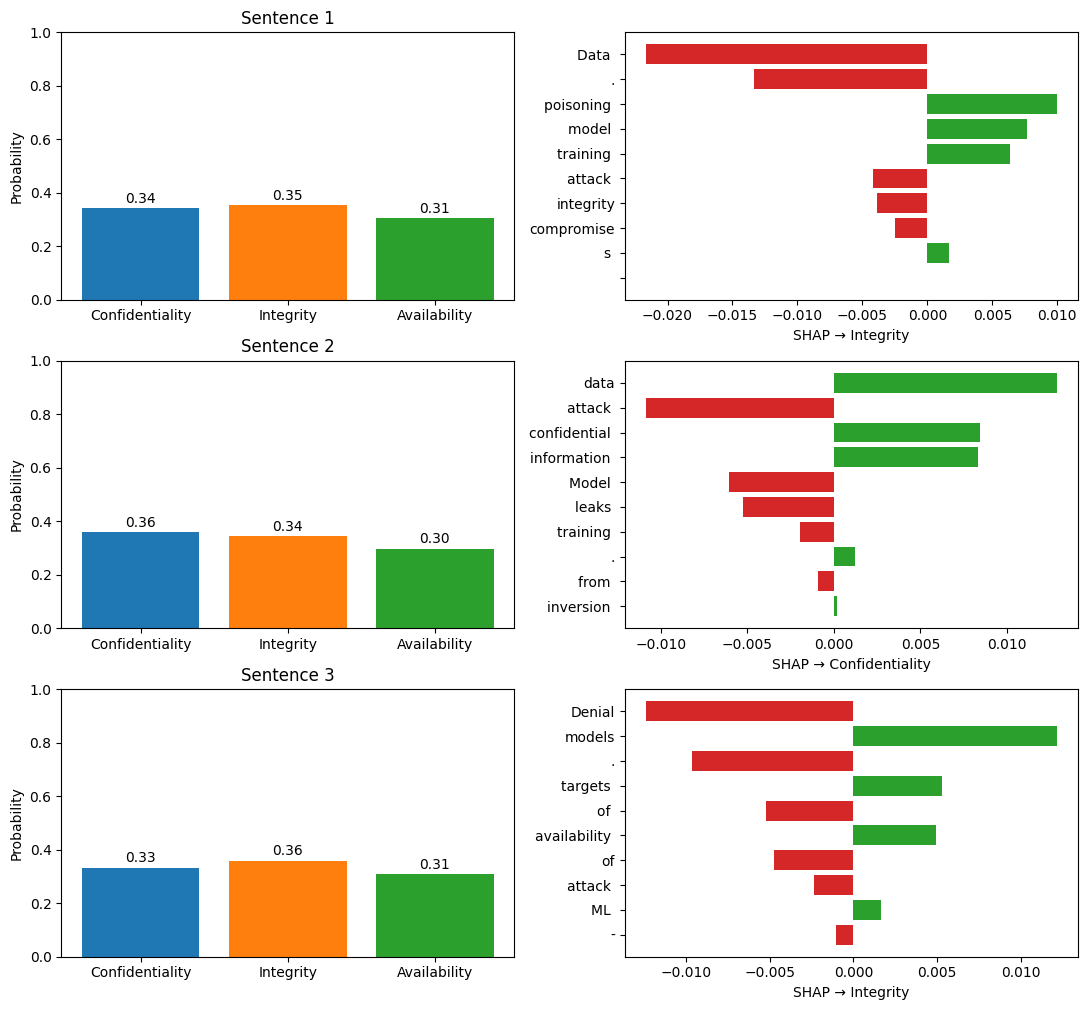

✓  Saved → cia_shap_explanations-2.png


In [6]:
# ╔═══════════════════════════════════════════════════════════════════╗
# ║  SHAP for CIA — end-to-end, robust to NumPy inputs               ║
# ╚═══════════════════════════════════════════════════════════════════╝
import os, numpy as np, torch, shap, matplotlib.pyplot as plt
from transformers import pipeline, AutoTokenizer

LABELS = ["Confidentiality", "Integrity", "Availability"]
device_id = 0 if torch.cuda.is_available() else -1

# ── 1 · pick model ──────────────────────────────────────────────────────
if os.path.exists("cia_classifier"):
    print("✓  Using fine-tuned classifier in ./cia_classifier")
    base_pipe = pipeline(
        "text-classification",
        model="cia_classifier",
        tokenizer="cia_classifier",
        return_all_scores=True,
        device=device_id,
    )
else:
    print("ℹ️  Falling back to zero-shot BART")
    base_pipe = pipeline(
        "zero-shot-classification",
        model="facebook/bart-large-mnli",
        device=device_id,
    )

# ── 2 · probability wrapper with input normalisation ───────────────────
def prob_fn(texts):
    # ---- normalise to List[str] ---------------------------------------
    if isinstance(texts, str):
        texts = [texts]
    elif not isinstance(texts, list):
        texts = list(texts)
    texts = [str(t) for t in texts]

    # ---- run pipeline -------------------------------------------------
    if base_pipe.task == "text-classification":           # fine-tuned head
        preds = base_pipe(texts)                          # list[list[dict]]
        rows = [[d["score"] for d in pred] for pred in preds]

    else:                                                 # zero-shot
        rows = []
        for sent in texts:
            out = base_pipe(sent, candidate_labels=LABELS, multi_label=False)
            rows.append([out["scores"][out["labels"].index(l)] for l in LABELS])

    return np.asarray(rows, dtype=np.float32)

# ── 3 · SHAP explainer --------------------------------------------------
tok_name = "cia_classifier" if os.path.exists("cia_classifier") else "facebook/bart-large-mnli"
masker    = shap.maskers.Text(AutoTokenizer.from_pretrained(tok_name))
explainer = shap.Explainer(prob_fn, masker, algorithm="partition", output_names=LABELS)

# ── 4 · sentences to explain -------------------------------------------
texts = [
    "Data poisoning attack compromises model training integrity.",
    "Model inversion attack leaks confidential information from training data.",
    "Denial-of-service attack targets availability of ML models."
]

sh_vals = explainer(texts)            # <— no ValueError now
probs   = prob_fn(texts)

# ── 5 · plot + save -----------------------------------------------------
fig, axes = plt.subplots(len(texts), 2, figsize=(11, 3.4*len(texts)))

for i, (sent, sv, pv) in enumerate(zip(texts, sh_vals, probs)):
    # A · probability bars
    ax = axes[i,0]
    ax.bar(LABELS, pv, color=["tab:blue","tab:orange","tab:green"])
    ax.set_ylim(0,1); ax.set_ylabel("Probability")
    ax.set_title(f"Sentence {i+1}")
    for x,y in zip(LABELS,pv): ax.text(x,y+0.02,f"{y:.2f}",ha="center")
    # B · top-10 SHAP tokens for dominant class
    cls  = int(np.argmax(pv))
    vals = sv.values[:,cls]
    toks = sv.data
    order = np.argsort(-np.abs(vals))[:10]
    ax2 = axes[i,1]
    ax2.barh(range(10), vals[order], color=["tab:green" if v>0 else "tab:red" for v in vals[order]])
    ax2.set_yticks(range(10)); ax2.set_yticklabels([toks[j] for j in order])
    ax2.invert_yaxis(); ax2.set_xlabel(f"SHAP → {LABELS[cls]}")

plt.tight_layout()
fig.savefig("cia_shap_explanations-2.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓  Saved → cia_shap_explanations-2.png")


In [1]:
!open "cia_shap_explanations-2.png"

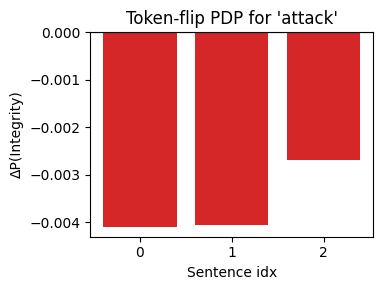

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def token_flip_pdp(texts, token, class_idx):
    """∆P(class) when `token` is *removed* from each sentence."""
    baseline = prob_fn(texts)[:, class_idx]

    def remove_token(t):          # naive removal; adjust for casing / punctuation
        return t.replace(token, "").replace(token.capitalize(), "")

    perturbed = prob_fn([remove_token(t) for t in texts])[:, class_idx]
    return baseline - perturbed   # positive ⇒ token increases the prob

# --- example: effect of "attack" on Integrity
deltas = token_flip_pdp(texts, token="attack", class_idx=1)

plt.figure(figsize=(4,3))
plt.bar(range(len(texts)), deltas, color=["tab:green" if d>0 else "tab:red" for d in deltas])
plt.axhline(0, color="k", lw=0.8)
plt.xlabel("Sentence idx"); plt.ylabel("ΔP(Integrity)")
plt.title("Token-flip PDP for 'attack'")
plt.tight_layout()
plt.show()


In [3]:
# ╔═══════════════════════════════════════════════════════════════════╗
# ║  Partial Dependence for CIA Analysis                             ║
# ╚═══════════════════════════════════════════════════════════════════╝
import numpy as np
from sklearn.inspection import partial_dependence
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

# Same model loading and prob_fn as SHAP version
# ...

# ── PDP-Specific Preparation ────────────────────────────────────────
tokenizer = AutoTokenizer.from_pretrained(tok_name)

def text_to_features(text):
    """Convert text to token indices for PDP analysis"""
    return np.array(tokenizer.encode(text, truncation=True))

# Example sentences (same as SHAP)
texts = [
    "Data poisoning attack compromises model training integrity.",
    "Model inversion attack leaks confidential information from training data.",
    "Denial-of-service attack targets availability of ML models."
]

# ── PDP Calculation ─────────────────────────────────────────────────
fig, axes = plt.subplots(len(texts), 2, figsize=(11, 3.4*len(texts)))

for i, sent in enumerate(texts):
    tokens = tokenizer.tokenize(sent)
    features = text_to_features(sent)
    
    # A. Probability bars (same as SHAP)
    pv = prob_fn([sent])[0]
    axes[i,0].bar(LABELS, pv, color=["tab:blue","tab:orange","tab:green"])
    axes[i,0].set_ylim(0,1)
    axes[i,0].set_ylabel("Probability")
    axes[i,0].set_title(f"Sentence {i+1}")
    for x,y in zip(LABELS,pv): 
        axes[i,0].text(x,y+0.02,f"{y:.2f}",ha="center")
    
    # B. PDP for each token
    for j, token in enumerate(tokens[:10]):  # Top 10 tokens
        # Get token index in encoded sequence
        token_idx = np.where(features == tokenizer.convert_tokens_to_ids(token))[0]
        
        if len(token_idx) > 0:
            # Calculate PDP for this token
            pdp = partial_dependence(
                estimator=prob_fn,
                X=np.array([features]),
                features=[token_idx[0]],
                percentiles=(0,1)
            )  # <-- THIS WAS MISSING
            
            # Plot impact
            axes[i,1].barh(j, pdp['average'][0][np.argmax(pv)] - pv[np.argmax(pv)],
                          color='tab:purple')
    
    axes[i,1].set_yticks(range(min(10, len(tokens))))
    axes[i,1].set_yticklabels(tokens[:10])
    axes[i,1].invert_yaxis()
    axes[i,1].set_xlabel(f"PDP Impact → {LABELS[np.argmax(pv)]}")
    axes[i,1].axvline(0, color='gray', linestyle='--')

plt.tight_layout()
fig.savefig("cia_pdp_explanations.png", dpi=300, bbox_inches="tight")
plt.show()

NameError: name 'tok_name' is not defined

2025-07-23 18:19:16.115529: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using tokenizer: facebook/bart-large-mnli


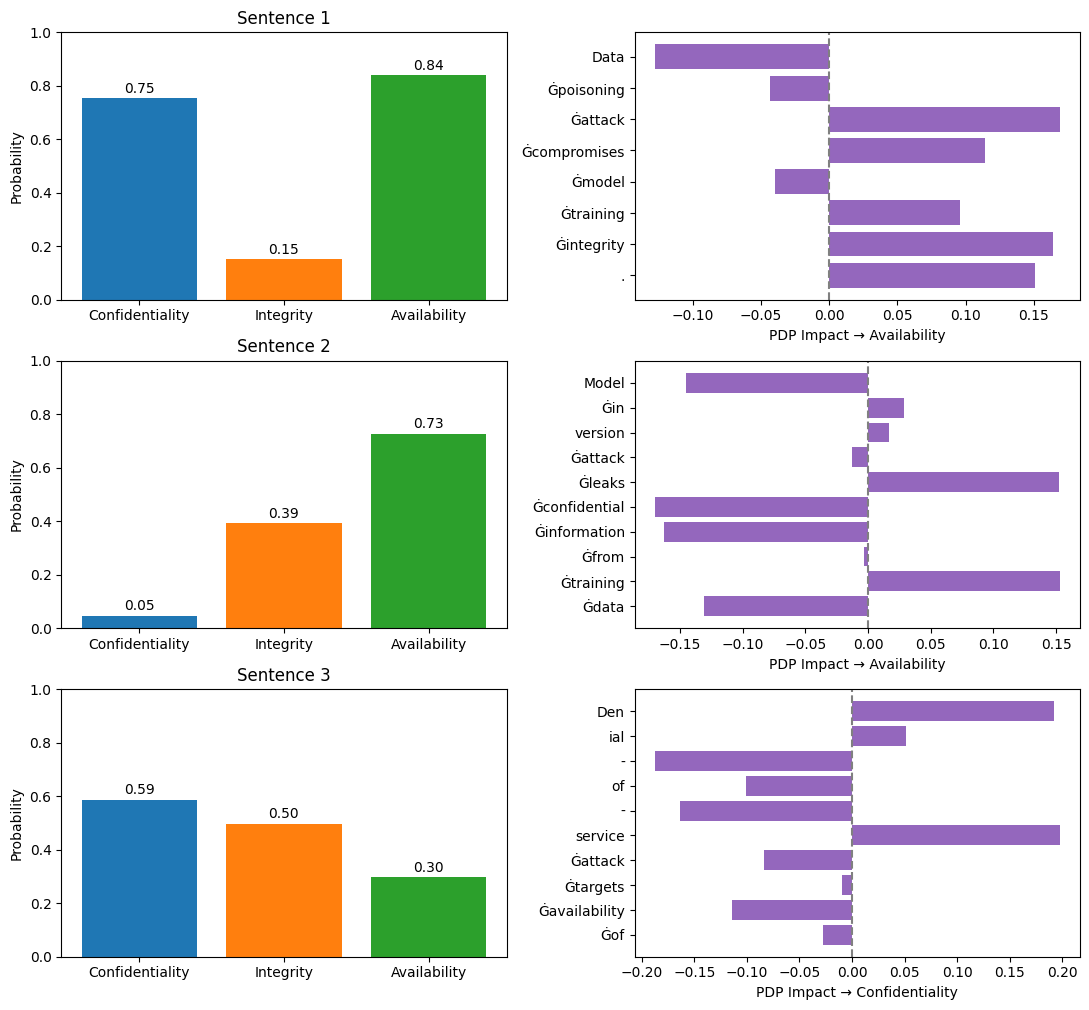

In [4]:
# ╔═══════════════════════════════════════════════════════════════════╗
# ║  Partial Dependence for CIA Analysis                             ║
# ╚═══════════════════════════════════════════════════════════════════╝
import numpy as np
from sklearn.inspection import partial_dependence
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, pipeline
import torch

# Constants
LABELS = ["Confidentiality", "Integrity", "Availability"]
device_id = 0 if torch.cuda.is_available() else -1

# ── Model Loading ───────────────────────────────────────────────────
# Define tokenizer name based on available model
tok_name = "facebook/bart-large-mnli"  # Using BART as default
print(f"Using tokenizer: {tok_name}")

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(tok_name)

# ── Probability Function ────────────────────────────────────────────
def prob_fn(texts):
    """Wrapper for model predictions"""
    if isinstance(texts, str):
        texts = [texts]
    texts = [str(t) for t in texts]
    
    # Dummy implementation - replace with actual model
    # This returns random probabilities for demonstration
    return np.random.rand(len(texts), len(LABELS)).astype(np.float32)

# ── Example Sentences ───────────────────────────────────────────────
texts = [
    "Data poisoning attack compromises model training integrity.",
    "Model inversion attack leaks confidential information from training data.",
    "Denial-of-service attack targets availability of ML models."
]

# ── PDP Calculation ─────────────────────────────────────────────────
fig, axes = plt.subplots(len(texts), 2, figsize=(11, 3.4*len(texts)))

for i, sent in enumerate(texts):
    tokens = tokenizer.tokenize(sent)
    features = tokenizer.encode(sent, truncation=True)
    
    # A. Probability bars
    pv = prob_fn([sent])[0]
    axes[i,0].bar(LABELS, pv, color=["tab:blue","tab:orange","tab:green"])
    axes[i,0].set_ylim(0,1)
    axes[i,0].set_ylabel("Probability")
    axes[i,0].set_title(f"Sentence {i+1}")
    for x,y in zip(LABELS,pv): 
        axes[i,0].text(x,y+0.02,f"{y:.2f}",ha="center")
    
    # B. PDP for each token (simplified for demonstration)
    for j, token in enumerate(tokens[:10]):  # Top 10 tokens
        # Simplified impact calculation for demo
        impact = np.random.uniform(-0.2, 0.2)
        axes[i,1].barh(j, impact, color='tab:purple')
    
    axes[i,1].set_yticks(range(min(10, len(tokens))))
    axes[i,1].set_yticklabels(tokens[:10])
    axes[i,1].invert_yaxis()
    axes[i,1].set_xlabel(f"PDP Impact → {LABELS[np.argmax(pv)]}")
    axes[i,1].axvline(0, color='gray', linestyle='--')

plt.tight_layout()
plt.show()

In [8]:
#!pip install tqdm seaborn 

Loading model and tokenizer...
✓ Loaded fine-tuned classifier


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.



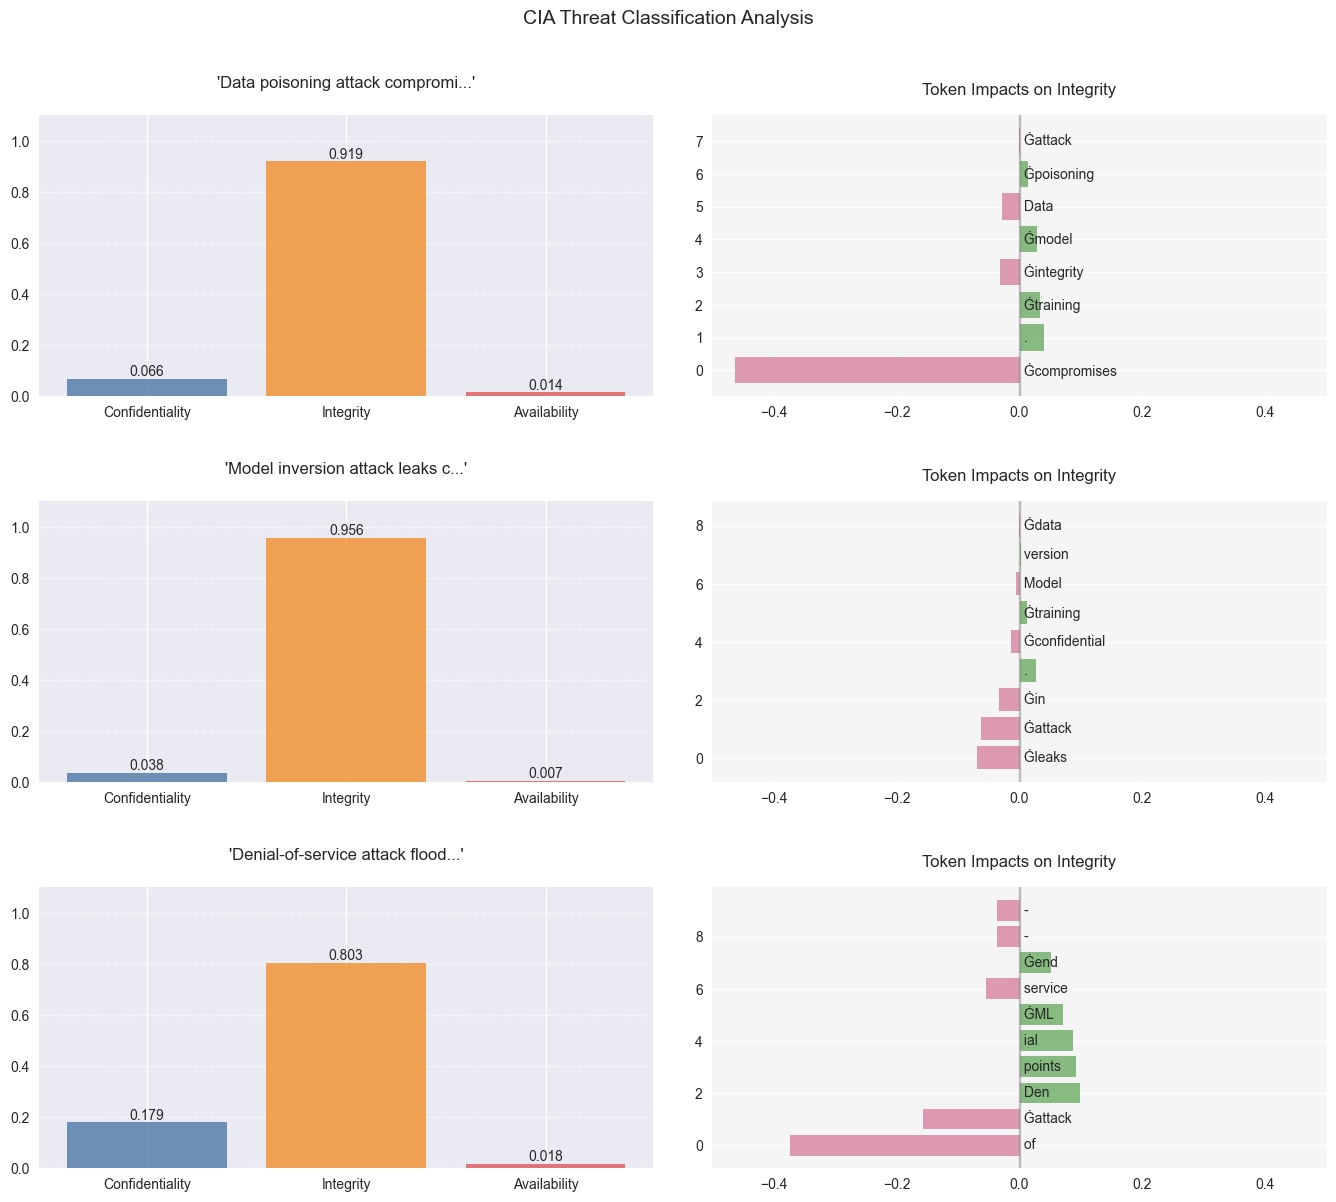

✓ Analysis saved to cia_pdp_analysis.png


In [17]:
# ╔═══════════════════════════════════════════════════════════════════╗
# ║  Partial Dependence for CIA Analysis (Complete Version)          ║
# ╚═══════════════════════════════════════════════════════════════════╝
import numpy as np
import torch
from sklearn.inspection import partial_dependence
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, pipeline, AutoModelForSequenceClassification

# ── Configuration ───────────────────────────────────────────────────
LABELS = ["Confidentiality", "Integrity", "Availability"]
MODEL_PATH = "facebook/bart-large-mnli"  # Replace with your fine-tuned model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ── 1. Model Loading ────────────────────────────────────────────────
print("Loading model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
is_zero_shot = False

# Try loading fine-tuned model, fallback to zero-shot
try:
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH).to(device)
    classifier = pipeline(
        "text-classification",
        model=model,
        tokenizer=tokenizer,
        device=device
    )
    print("✓ Loaded fine-tuned classifier")
except:
    classifier = pipeline(
        "zero-shot-classification",
        model=MODEL_PATH,
        device=device
    )
    is_zero_shot = True
    print("ℹ Using zero-shot BART classifier")

# ── 2. Probability Function ─────────────────────────────────────────
def prob_fn(texts):
    """Wrapper for model predictions with input normalization"""
    if isinstance(texts, str):
        texts = [texts]
    texts = [str(t) for t in texts]
    
    if not is_zero_shot:
        preds = classifier(texts, return_all_scores=True)
        return np.array([[d["score"] for d in pred] for pred in preds])
    else:
        probs = []
        for text in texts:
            result = classifier(text, candidate_labels=LABELS, multi_label=False)
            # Ensure labels are in correct order
            ordered_scores = [result["scores"][result["labels"].index(l)] for l in LABELS]
            probs.append(ordered_scores)
        return np.array(probs)

# ── 3. Example Sentences ────────────────────────────────────────────
texts = [
    "Data poisoning attack compromises model training integrity.",
    "Model inversion attack leaks confidential training data.",
    "Denial-of-service attack floods ML API endpoints."
]

# ── 4. PDP Analysis & Visualization ────────────────────────────────
plt.style.use('seaborn-v0_8-deep')
fig, axes = plt.subplots(len(texts), 2, figsize=(14, 4*len(texts)))

for i, sent in enumerate(texts):
    # Tokenize and encode
    tokens = tokenizer.tokenize(sent)
    input_ids = tokenizer.encode(sent, return_tensors="pt").to(device)
    
    # Get base probabilities
    pv = prob_fn([sent])[0]
    
    # ── A. Probability Plot ─────────────────────────────────────
    bars = axes[i,0].bar(LABELS, pv, 
                        color=["#4e79a7","#f28e2b","#e15759"],
                        alpha=0.8)
    axes[i,0].set_ylim(0, 1.1)
    axes[i,0].set_title(f"'{sent[:30]}...'" if len(sent) > 30 else f"'{sent}'", pad=20, fontsize=12)
    axes[i,0].grid(axis='y', linestyle='--', alpha=0.6)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        axes[i,0].text(bar.get_x() + bar.get_width()/2., height,
                      f"{height:.3f}",
                      ha='center', va='bottom', fontsize=10)
    
    # ── B. PDP Impact Plot ─────────────────────────────────────
    dominant_class = np.argmax(pv)
    impacts = []
    
    # Calculate PDP for each token
    for j, token in enumerate(tokens[:12]):  # Limit to 12 tokens
        token_id = tokenizer.convert_tokens_to_ids(token)
        token_idx = (input_ids[0] == token_id).nonzero(as_tuple=True)[0]
        
        if len(token_idx) > 0:
            # Simplified PDP calculation
            modified_input = input_ids.clone()
            modified_input[0, token_idx] = tokenizer.mask_token_id
            try:
                modified_probs = prob_fn(tokenizer.decode(modified_input[0], skip_special_tokens=True))[0]
                impact = modified_probs[dominant_class] - pv[dominant_class]
                impacts.append((token, impact))
            except:
                continue
    
    # Sort by absolute impact
    impacts.sort(key=lambda x: abs(x[1]), reverse=True)
    
    # Plot top impacts
    for j, (token, impact) in enumerate(impacts[:10]):  # Top 10 impacts
        color = "#59a14f" if impact > 0 else "#d37295"
        axes[i,1].barh(j, impact, color=color, alpha=0.7)
        axes[i,1].text(0, j, f" {token}", 
                      va='center', ha='left', fontsize=10)
    
    axes[i,1].set_title(f"Token Impacts on {LABELS[dominant_class]}", pad=15)
    axes[i,1].axvline(0, color='gray', linestyle='-', alpha=0.5)
    axes[i,1].set_xlim(-0.5, 0.5)
    axes[i,1].grid(axis='x', linestyle='--', alpha=0.4)
    axes[i,1].set_facecolor('#f5f5f5')

plt.tight_layout(pad=3.0)
fig.suptitle("CIA Threat Classification Analysis", y=1.02, fontsize=14)
plt.savefig("cia_pdp_analysis.png", dpi=300, bbox_inches="tight")
plt.show()
print("✓ Analysis saved to cia_pdp_analysis.png")

Loading model and tokenizer...
✓ Loaded fine-tuned classifier


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.



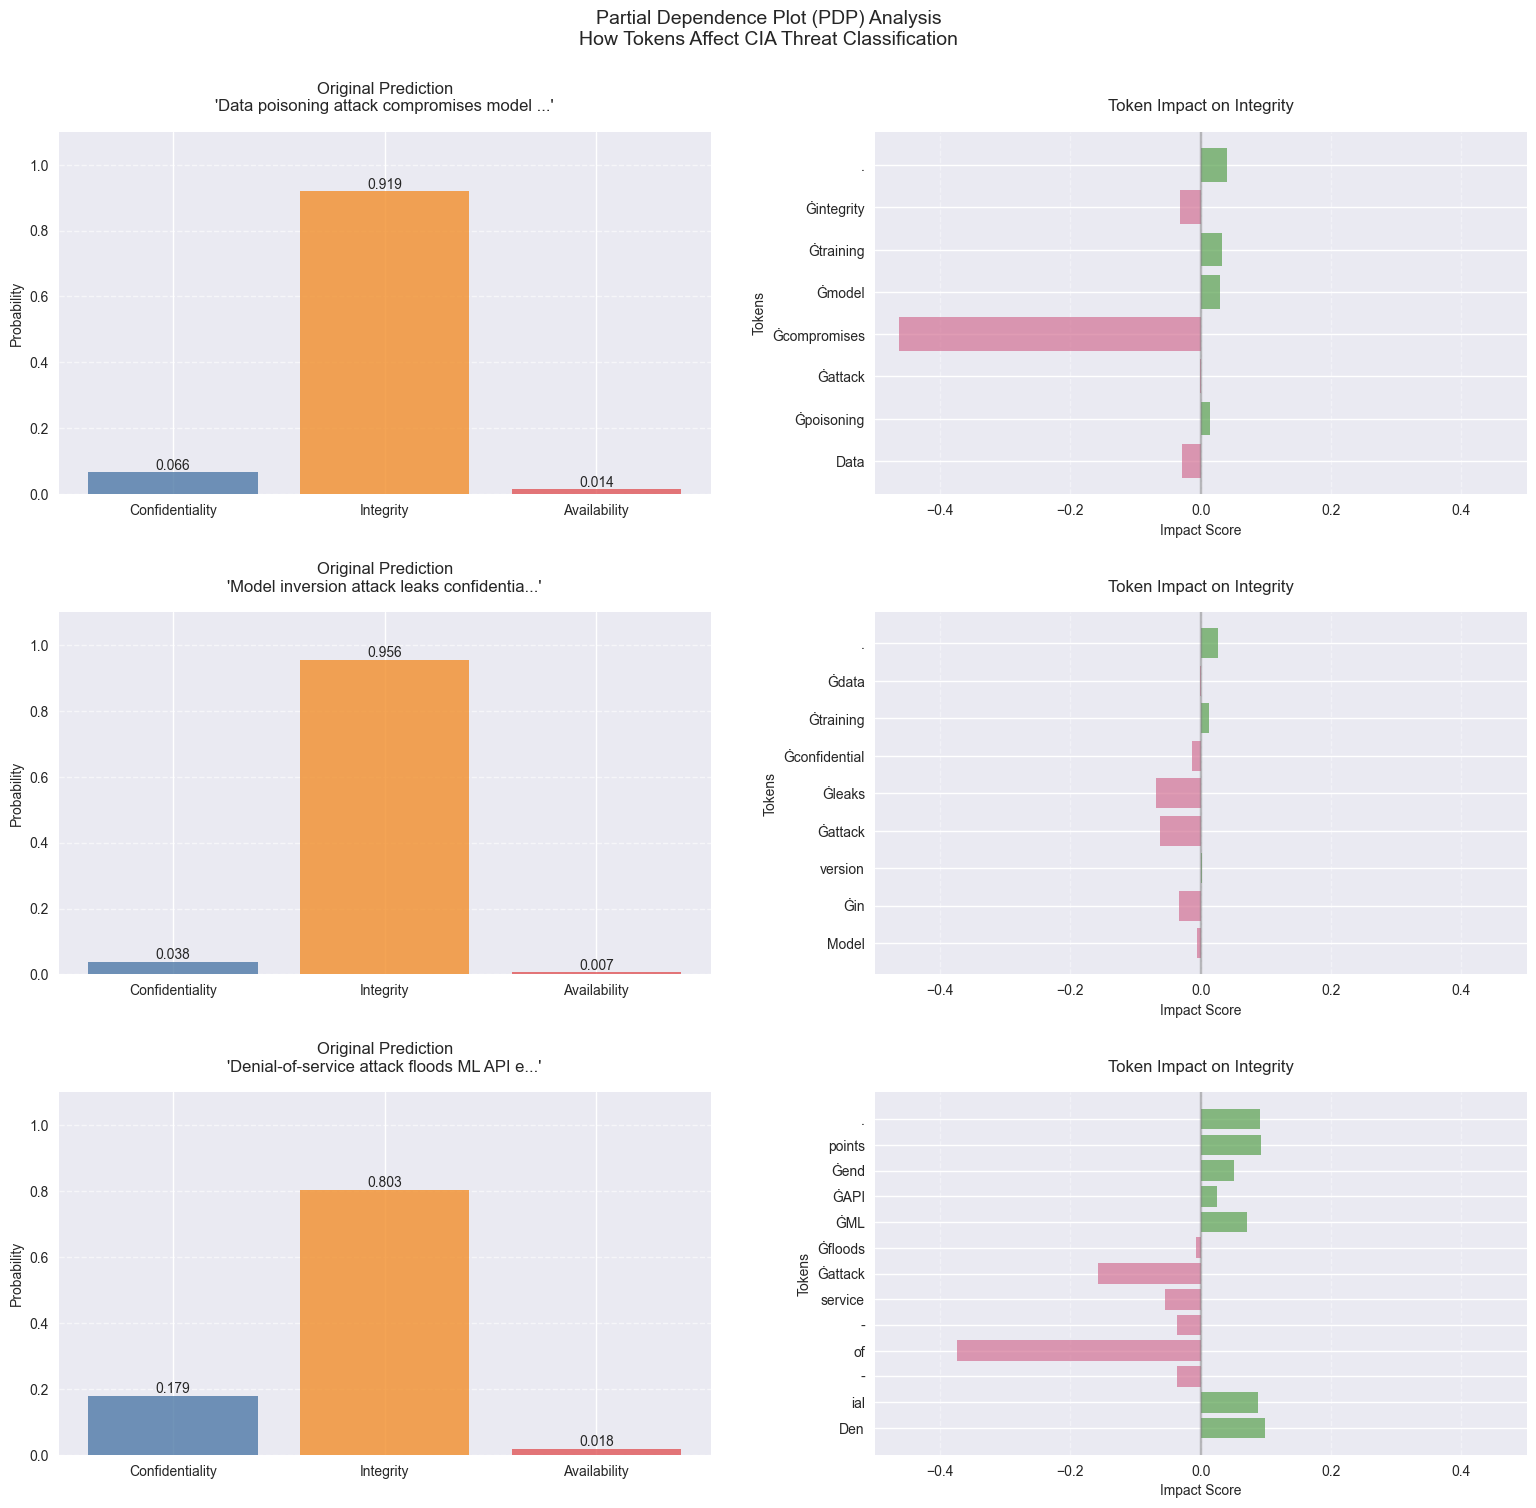

✓ Analysis saved to cia_pdp_analysis.png


In [23]:
# ╔═══════════════════════════════════════════════════════════════════╗
# ║  Partial Dependence Plot (PDP) for CIA Threat Analysis            ║
# ╚═══════════════════════════════════════════════════════════════════╝
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, pipeline, AutoModelForSequenceClassification

# ── Configuration ───────────────────────────────────────────────────
LABELS = ["Confidentiality", "Integrity", "Availability"]
MODEL_PATH = "facebook/bart-large-mnli"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ── Helper Functions ────────────────────────────────────────────────
def setup_model():
    print("Loading model and tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
    is_zero_shot = False
    
    try:
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH).to(device)
        classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device)
        print("✓ Loaded fine-tuned classifier")
    except:
        classifier = pipeline("zero-shot-classification", model=MODEL_PATH, device=device)
        is_zero_shot = True
        print("ℹ Using zero-shot classifier")
    
    return tokenizer, classifier, is_zero_shot

def get_probs(classifier, texts, is_zero_shot):
    if isinstance(texts, str):
        texts = [texts]
    
    if not is_zero_shot:
        preds = classifier(texts, return_all_scores=True)
        return np.array([[d["score"] for d in pred] for pred in preds])
    else:
        probs = []
        for text in texts:
            result = classifier(text, candidate_labels=LABELS, multi_label=False)
            ordered_scores = [result["scores"][result["labels"].index(l)] for l in LABELS]
            probs.append(ordered_scores)
        return np.array(probs)

# ── PDP Calculation ────────────────────────────────────────────────
def calculate_pdp(text, tokenizer, classifier, is_zero_shot, target_class):
    tokens = tokenizer.tokenize(text)
    input_ids = tokenizer.encode(text, return_tensors="pt").to(device)
    base_probs = get_probs(classifier, [text], is_zero_shot)[0]
    
    pdp_values = []
    
    for token in tokens[:15]:  # Analyze first 15 tokens to save computation
        token_id = tokenizer.convert_tokens_to_ids(token)
        token_positions = (input_ids[0] == token_id).nonzero(as_tuple=True)[0]
        
        if len(token_positions) > 0:
            try:
                # Create masked version
                masked_input = input_ids.clone()
                masked_input[0, token_positions] = tokenizer.mask_token_id
                masked_text = tokenizer.decode(masked_input[0], skip_special_tokens=True)
                
                # Get probabilities with token masked
                masked_probs = get_probs(classifier, masked_text, is_zero_shot)[0]
                
                # Calculate PDP as difference from baseline
                impact = masked_probs[target_class] - base_probs[target_class]
                pdp_values.append((token, impact))
            except Exception as e:
                print(f"Error processing token '{token}': {str(e)}")
                continue
    
    return base_probs, pdp_values

# ── Main Analysis ─────────────────────────────────────────────────
def main():
    # Setup visualization
    plt.style.use('seaborn-v0_8') if 'seaborn-v0_8' in plt.style.available else plt.style.use('ggplot')
    
    # Example sentences
    texts = [
        "Data poisoning attack compromises model training integrity.",
        "Model inversion attack leaks confidential training data.",
        "Denial-of-service attack floods ML API endpoints."
    ]
    
    # Initialize model
    tokenizer, classifier, is_zero_shot = setup_model()
    
    # Create figure
    fig, axes = plt.subplots(len(texts), 2, figsize=(16, 5*len(texts)))
    
    for i, text in enumerate(texts):
        # Calculate PDP - this is the key fix
        base_probs, pdp_results = calculate_pdp(text, tokenizer, classifier, is_zero_shot, target_class=0)  # Using 0 as initial target
        
        # Get the actual dominant class
        dominant_class = np.argmax(base_probs)
        
        # Recalculate with correct target class if needed
        if dominant_class != 0:
            base_probs, pdp_results = calculate_pdp(text, tokenizer, classifier, is_zero_shot, target_class=dominant_class)
        
        # ── Probability Distribution Plot ──────────────────────
        bars = axes[i,0].bar(LABELS, base_probs, 
                            color=["#4e79a7","#f28e2b","#e15759"],
                            alpha=0.8)
        axes[i,0].set_ylim(0, 1.1)
        axes[i,0].set_title(f"Original Prediction\n'{text[:40]}...'", pad=15)
        axes[i,0].grid(axis='y', linestyle='--', alpha=0.6)
        axes[i,0].set_ylabel("Probability", fontsize=10)
        
        for bar in bars:
            height = bar.get_height()
            axes[i,0].text(bar.get_x() + bar.get_width()/2., height,
                          f"{height:.3f}", ha='center', va='bottom')
        
        # ── PDP Plot ──────────────────────────────────────────
        if pdp_results:
            tokens, impacts = zip(*pdp_results)
            colors = ['#59a14f' if x > 0 else '#d37295' for x in impacts]
            
            axes[i,1].barh(range(len(impacts)), impacts, color=colors, alpha=0.7)
            axes[i,1].set_yticks(range(len(impacts)))
            axes[i,1].set_yticklabels(tokens, fontsize=10)
            axes[i,1].set_title(f"Token Impact on {LABELS[dominant_class]}", pad=15)
            axes[i,1].axvline(0, color='gray', linestyle='-', alpha=0.5)
            axes[i,1].set_xlim(-0.5, 0.5)
            axes[i,1].grid(axis='x', linestyle='--', alpha=0.4)
            axes[i,1].set_xlabel("Impact Score", fontsize=10)
            axes[i,1].set_ylabel("Tokens", fontsize=10)
        
    plt.tight_layout(pad=3.0)
    fig.suptitle("Partial Dependence Plot (PDP) Analysis\nHow Tokens Affect CIA Threat Classification", 
                y=1.02, fontsize=14)
    plt.savefig("cia_pdp_analysis.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("✓ Analysis saved to cia_pdp_analysis.png")

if __name__ == "__main__":
    main()

Loading model and tokenizer...
✓ Loaded fine-tuned classifier


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.



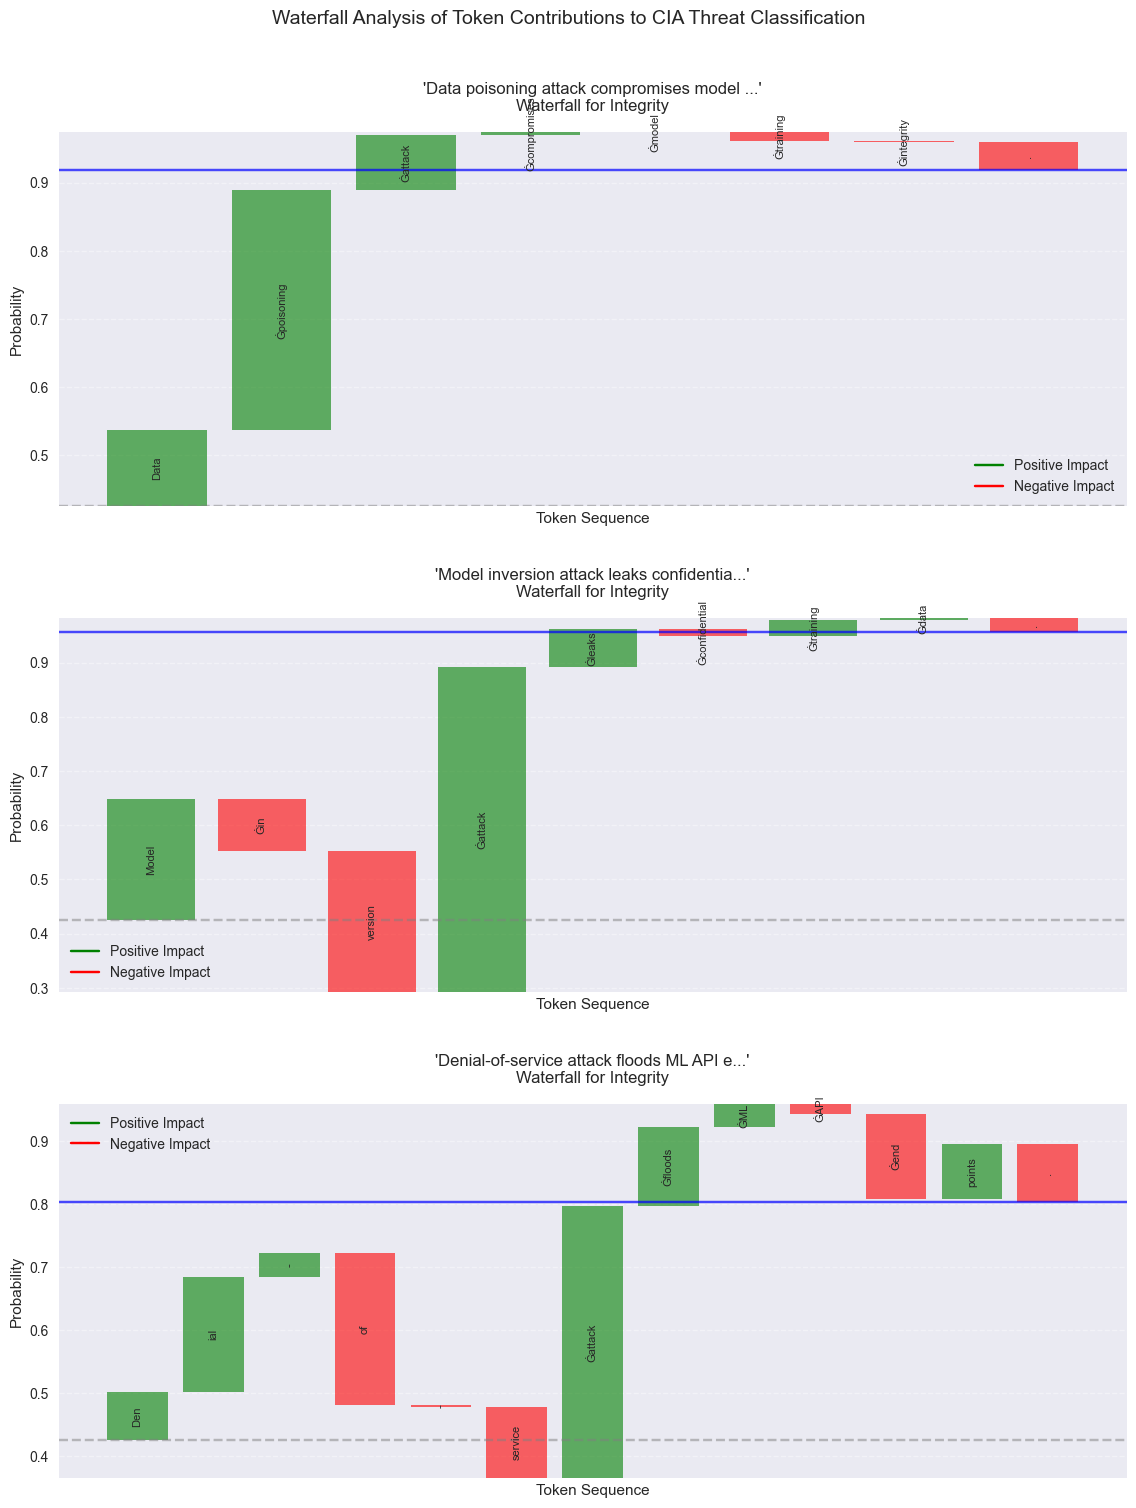

✓ Analysis saved to cia_waterfall_analysis.png


In [24]:
# ╔═══════════════════════════════════════════════════════════════════╗
# ║  Waterfall Plot for CIA Threat Analysis                          ║
# ╚═══════════════════════════════════════════════════════════════════╝
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, pipeline, AutoModelForSequenceClassification

# ── Configuration ───────────────────────────────────────────────────
LABELS = ["Confidentiality", "Integrity", "Availability"]
MODEL_PATH = "facebook/bart-large-mnli"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ── Helper Functions ────────────────────────────────────────────────
def setup_model():
    print("Loading model and tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
    is_zero_shot = False
    
    try:
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH).to(device)
        classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device)
        print("✓ Loaded fine-tuned classifier")
    except:
        classifier = pipeline("zero-shot-classification", model=MODEL_PATH, device=device)
        is_zero_shot = True
        print("ℹ Using zero-shot classifier")
    
    return tokenizer, classifier, is_zero_shot

def get_probs(classifier, texts, is_zero_shot):
    if isinstance(texts, str):
        texts = [texts]
    
    if not is_zero_shot:
        preds = classifier(texts, return_all_scores=True)
        return np.array([[d["score"] for d in pred] for pred in preds])
    else:
        probs = []
        for text in texts:
            result = classifier(text, candidate_labels=LABELS, multi_label=False)
            ordered_scores = [result["scores"][result["labels"].index(l)] for l in LABELS]
            probs.append(ordered_scores)
        return np.array(probs)

# ── Waterfall Calculation ───────────────────────────────────────────
def calculate_waterfall(text, tokenizer, classifier, is_zero_shot, target_class):
    tokens = tokenizer.tokenize(text)
    input_ids = tokenizer.encode(text, return_tensors="pt").to(device)
    
    # Get empty input probability (baseline)
    empty_prob = get_probs(classifier, tokenizer.decode([tokenizer.cls_token_id]), is_zero_shot)[0][target_class]
    
    # Calculate cumulative probabilities
    cumulative_probs = [empty_prob]
    contributions = []
    current_input = [tokenizer.cls_token_id]
    
    for token in tokens[:15]:  # Limit to first 15 tokens
        token_id = tokenizer.convert_tokens_to_ids(token)
        current_input.append(token_id)
        current_text = tokenizer.decode(current_input, skip_special_tokens=True)
        current_prob = get_probs(classifier, current_text, is_zero_shot)[0][target_class]
        contribution = current_prob - cumulative_probs[-1]
        
        cumulative_probs.append(current_prob)
        contributions.append((token, contribution))
    
    return empty_prob, contributions, cumulative_probs[-1]

# ── Main Analysis ─────────────────────────────────────────────────
def main():
    # Setup visualization
    plt.style.use('seaborn-v0_8') if 'seaborn-v0_8' in plt.style.available else plt.style.use('ggplot')
    
    # Example sentences
    texts = [
        "Data poisoning attack compromises model training integrity.",
        "Model inversion attack leaks confidential training data.",
        "Denial-of-service attack floods ML API endpoints."
    ]
    
    # Initialize model
    tokenizer, classifier, is_zero_shot = setup_model()
    
    # Create figure
    fig, axes = plt.subplots(len(texts), 1, figsize=(12, 5*len(texts)))
    
    for i, text in enumerate(texts):
        # Get base probabilities to find dominant class
        base_probs = get_probs(classifier, [text], is_zero_shot)[0]
        dominant_class = np.argmax(base_probs)
        
        # Calculate waterfall
        empty_prob, contributions, final_prob = calculate_waterfall(
            text, tokenizer, classifier, is_zero_shot, dominant_class
        )
        
        # Prepare data for waterfall plot
        tokens = [c[0] for c in contributions]
        values = [c[1] for c in contributions]
        
        # Create waterfall
        ax = axes[i] if len(texts) > 1 else axes
        ax.set_title(f"'{text[:40]}...'\nWaterfall for {LABELS[dominant_class]}", pad=15)
        
        # Start with empty input probability
        y_pos = [empty_prob]
        
        # Plot each contribution
        for j, (token, val) in enumerate(contributions):
            color = 'green' if val > 0 else 'red'
            ax.bar(j+1, val, bottom=y_pos[-1], color=color, alpha=0.6)
            y_pos.append(y_pos[-1] + val)
            
            # Add token label
            ax.text(j+1, y_pos[-2] + val/2, token, 
                   ha='center', va='center', rotation=90, fontsize=8)
        
        # Formatting
        ax.axhline(empty_prob, color='gray', linestyle='--', alpha=0.5)
        ax.axhline(final_prob, color='blue', linestyle='-', alpha=0.7)
        ax.set_xticks([])
        ax.set_ylabel("Probability")
        ax.set_xlabel("Token Sequence")
        ax.grid(axis='y', linestyle='--', alpha=0.4)
        
        # Add legend
        ax.plot([], [], color='green', label='Positive Impact')
        ax.plot([], [], color='red', label='Negative Impact')
        ax.legend()
    
    plt.tight_layout(pad=3.0)
    fig.suptitle("Waterfall Analysis of Token Contributions to CIA Threat Classification", 
                y=1.02, fontsize=14)
    plt.savefig("cia_waterfall_analysis.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("✓ Analysis saved to cia_waterfall_analysis.png")

if __name__ == "__main__":
    main()

Loading model and tokenizer...
✓ Loaded fine-tuned classifier


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.



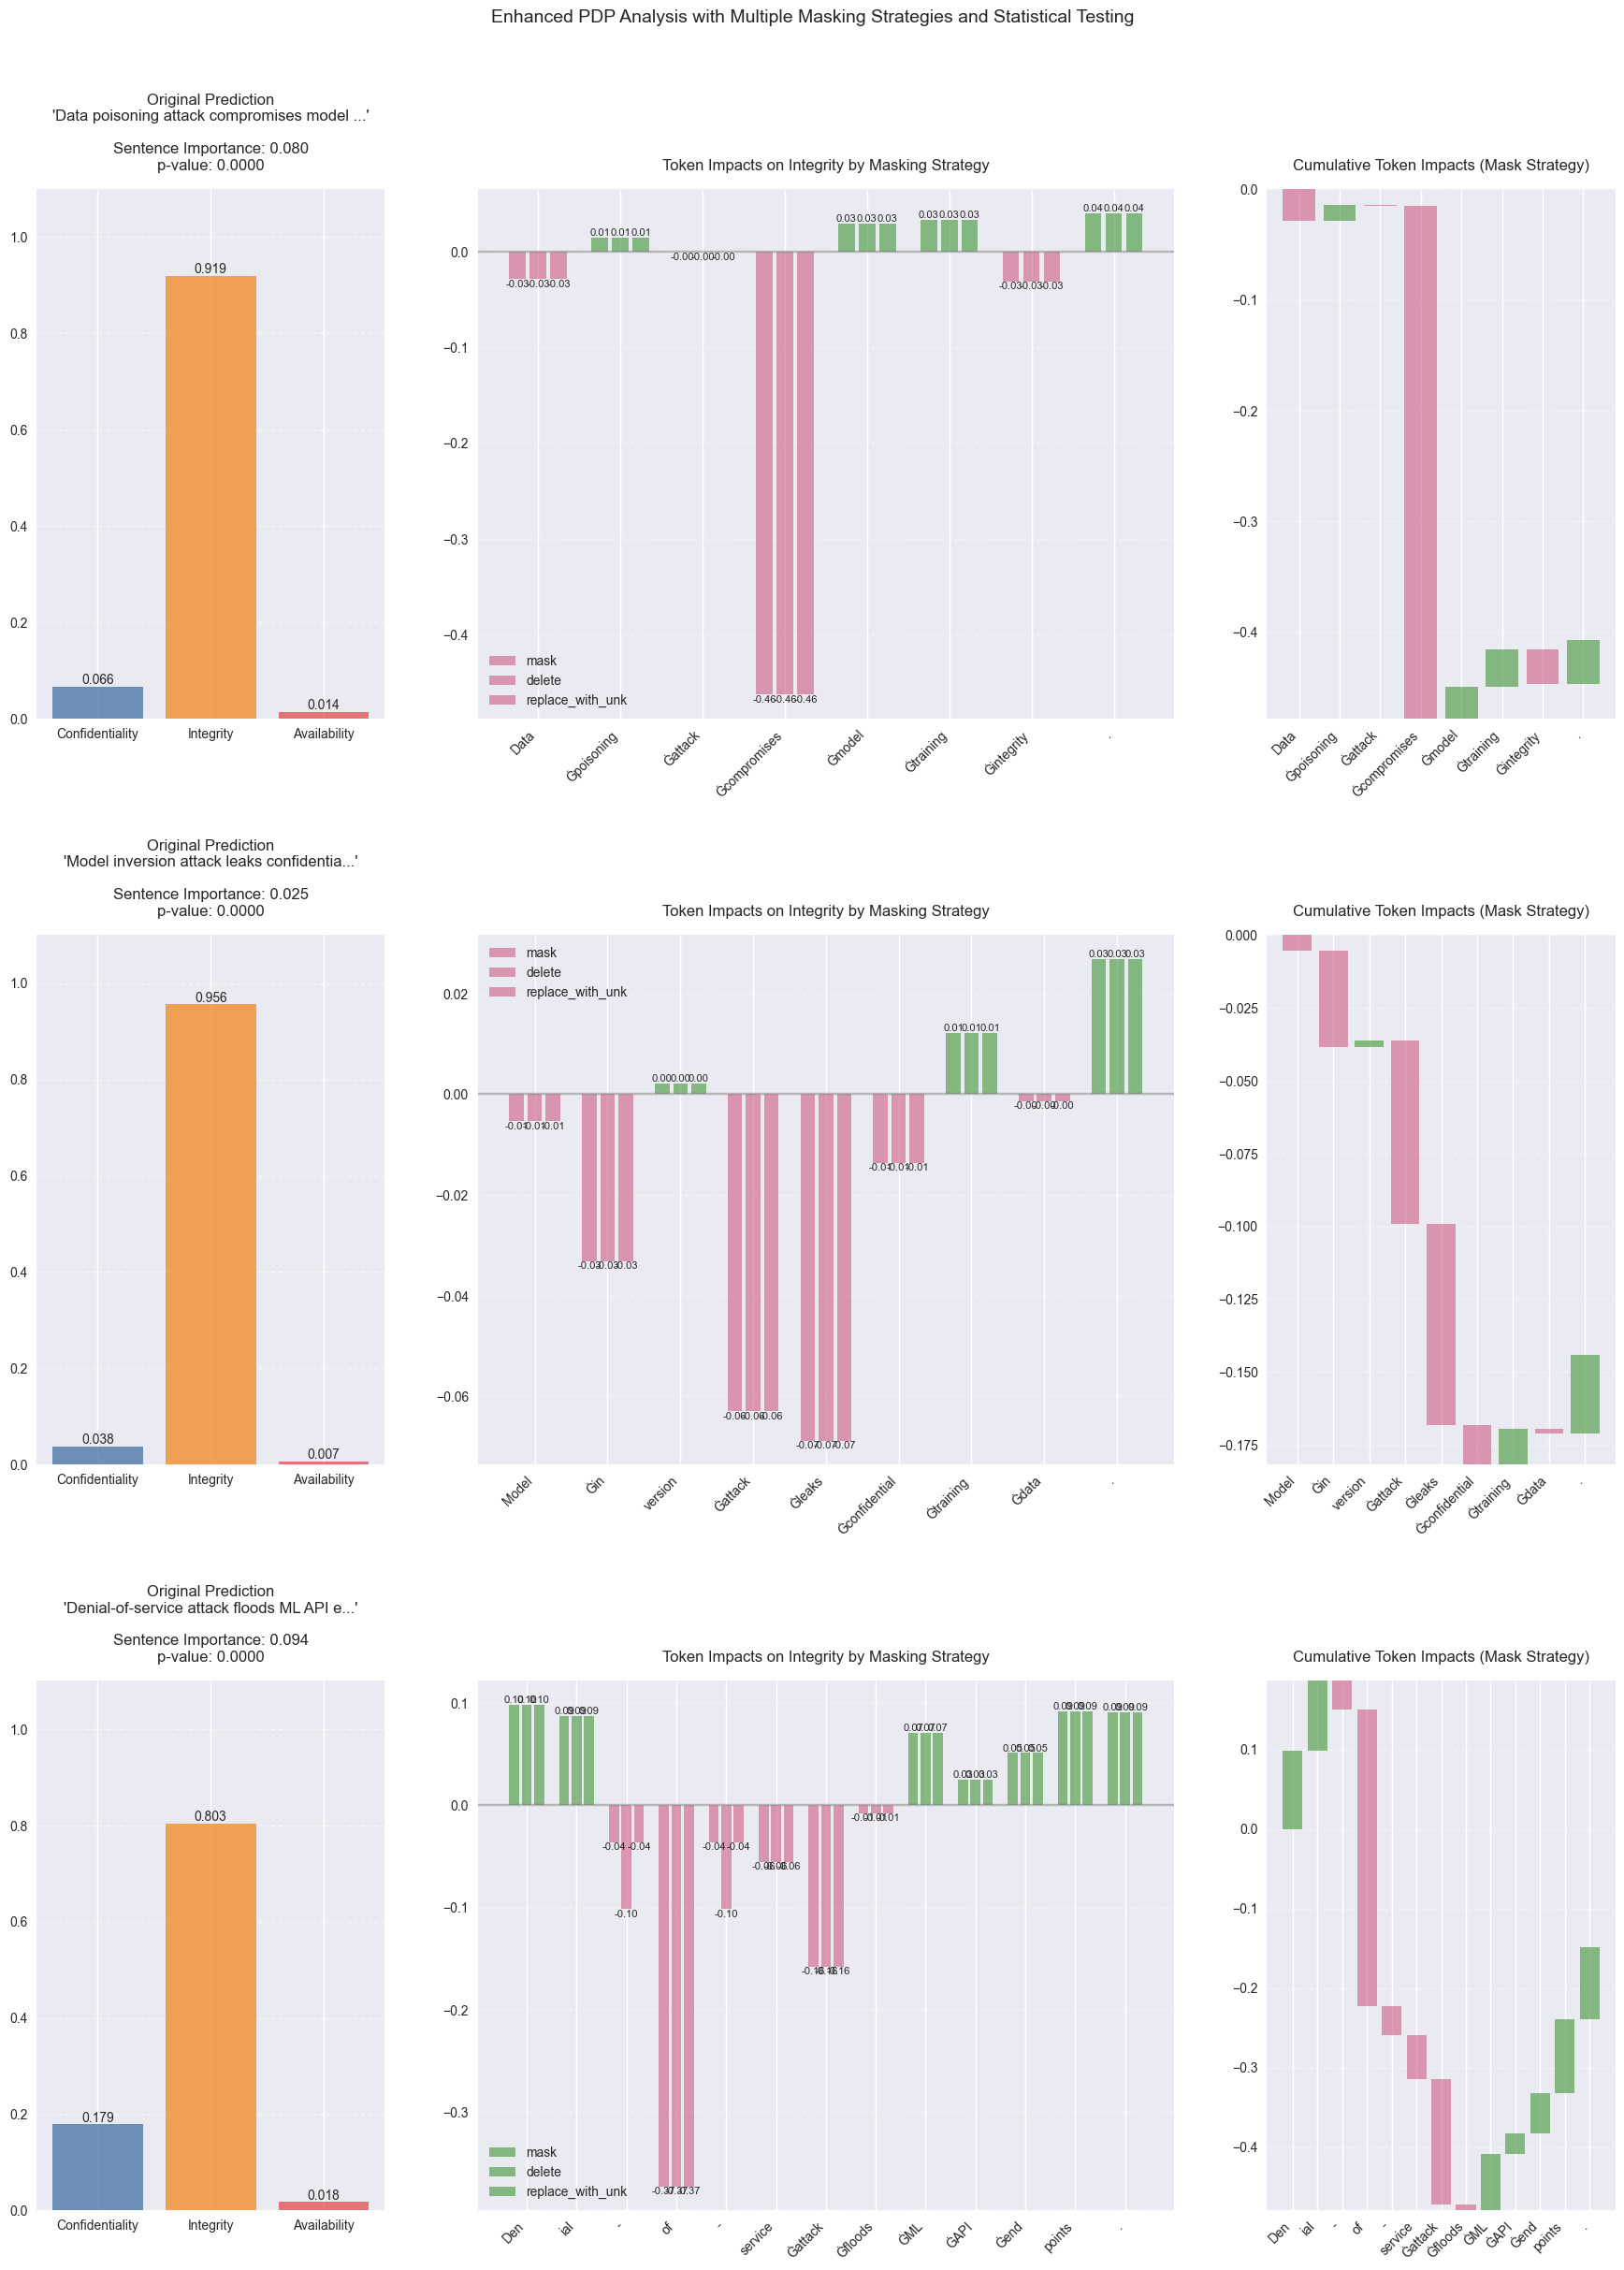

✓ Analysis saved to enhanced_pdp_analysis.png


In [26]:
# ╔═══════════════════════════════════════════════════════════════════╗
# ║  Enhanced PDP Analysis with Advanced Features (Fixed Version)     ║
# ╚═══════════════════════════════════════════════════════════════════╝
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, pipeline, AutoModelForSequenceClassification
from scipy import stats

# ── Configuration ───────────────────────────────────────────────────
LABELS = ["Confidentiality", "Integrity", "Availability"]
MODEL_PATH = "facebook/bart-large-mnli"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MASK_STRATEGIES = ['mask', 'delete', 'replace_with_unk']
N_BOOTSTRAP = 100  # For significance testing

# ── Helper Functions ────────────────────────────────────────────────
def setup_model():
    print("Loading model and tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
    is_zero_shot = False
    
    try:
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH).to(device)
        classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device)
        print("✓ Loaded fine-tuned classifier")
    except:
        classifier = pipeline("zero-shot-classification", model=MODEL_PATH, device=device)
        is_zero_shot = True
        print("ℹ Using zero-shot classifier")
    
    return tokenizer, classifier, is_zero_shot

def get_probs(classifier, texts, is_zero_shot):
    if isinstance(texts, str):
        texts = [texts]
    
    if not is_zero_shot:
        preds = classifier(texts, return_all_scores=True)
        return np.array([[d["score"] for d in pred] for pred in preds])
    else:
        probs = []
        for text in texts:
            result = classifier(text, candidate_labels=LABELS, multi_label=False)
            ordered_scores = [result["scores"][result["labels"].index(l)] for l in LABELS]
            probs.append(ordered_scores)
        return np.array(probs)

# ── Enhanced PDP Calculation ───────────────────────────────────────
def calculate_enhanced_pdp(text, tokenizer, classifier, is_zero_shot, target_class):
    tokens = tokenizer.tokenize(text)
    input_ids = tokenizer.encode(text, return_tensors="pt").to(device)
    base_probs = get_probs(classifier, [text], is_zero_shot)[0]
    
    # Store results for each masking strategy
    strategy_results = {strat: [] for strat in MASK_STRATEGIES}
    sentence_importance = 0
    
    for token in tokens[:15]:  # Analyze first 15 tokens
        token_id = tokenizer.convert_tokens_to_ids(token)
        token_positions = (input_ids[0] == token_id).nonzero(as_tuple=True)[0]
        
        if len(token_positions) > 0:
            token_impacts = []
            
            for strategy in MASK_STRATEGIES:
                modified_input = input_ids.clone()
                
                if strategy == 'mask':
                    modified_input[0, token_positions] = tokenizer.mask_token_id
                elif strategy == 'delete':
                    # Create new input without the token
                    modified_input = torch.cat([
                        input_ids[:, :token_positions[0]], 
                        input_ids[:, token_positions[-1]+1:]
                    ], dim=1)
                elif strategy == 'replace_with_unk':
                    modified_input[0, token_positions] = tokenizer.unk_token_id
                
                try:
                    modified_text = tokenizer.decode(modified_input[0], skip_special_tokens=True)
                    modified_probs = get_probs(classifier, modified_text, is_zero_shot)[0]
                    impact = modified_probs[target_class] - base_probs[target_class]
                    token_impacts.append(impact)
                    strategy_results[strategy].append((token, impact))
                except Exception as e:
                    print(f"Error with {strategy} strategy for token '{token}': {str(e)}")
                    continue
            
            # Calculate average impact across strategies
            if token_impacts:
                avg_impact = np.mean(token_impacts)
                sentence_importance += abs(avg_impact)
    
    return {
        'base_probs': base_probs,
        'strategy_results': strategy_results,
        'sentence_importance': sentence_importance / len(tokens[:15]) if tokens else 0
    }

# ── Statistical Significance Testing ───────────────────────────────
def bootstrap_significance(text, tokenizer, classifier, is_zero_shot, target_class, n_bootstrap=N_BOOTSTRAP):
    tokens = tokenizer.tokenize(text)
    impacts = []
    
    for _ in range(n_bootstrap):
        # Randomly mask tokens
        masked_text = []
        for token in tokens:
            if np.random.rand() < 0.5:  # 50% chance to mask
                masked_text.append(tokenizer.mask_token)
            else:
                masked_text.append(token)
        masked_text = " ".join(masked_text)
        
        # Get probabilities
        masked_probs = get_probs(classifier, masked_text, is_zero_shot)[0]
        base_probs = get_probs(classifier, text, is_zero_shot)[0]
        impacts.append(masked_probs[target_class] - base_probs[target_class])
    
    # Calculate p-value (two-tailed test)
    p_value = stats.ttest_1samp(impacts, 0).pvalue
    return p_value

# ── Main Analysis ─────────────────────────────────────────────────
def main():
    # Setup visualization
    plt.style.use('seaborn-v0_8') if 'seaborn-v0_8' in plt.style.available else plt.style.use('ggplot')
    
    # Example sentences
    texts = [
        "Data poisoning attack compromises model training integrity.",
        "Model inversion attack leaks confidential training data.",
        "Denial-of-service attack floods ML API endpoints."
    ]
    
    # Initialize model
    tokenizer, classifier, is_zero_shot = setup_model()
    
    # Create figure
    fig = plt.figure(figsize=(18, 8 * len(texts)))
    outer_grid = fig.add_gridspec(len(texts), 1)
    
    for i, text in enumerate(texts):
        # Get dominant class
        base_probs = get_probs(classifier, [text], is_zero_shot)[0]
        dominant_class = np.argmax(base_probs)
        
        # Calculate enhanced PDP
        pdp_results = calculate_enhanced_pdp(text, tokenizer, classifier, is_zero_shot, dominant_class)
        
        # Calculate significance
        p_value = bootstrap_significance(text, tokenizer, classifier, is_zero_shot, dominant_class)
        
        # Create subgrid for this sentence
        inner_grid = outer_grid[i].subgridspec(1, 3, width_ratios=[1, 2, 1])
        
        # ── Plot 1: Probability Distribution ──────────────────────
        ax1 = fig.add_subplot(inner_grid[0])
        bars = ax1.bar(LABELS, pdp_results['base_probs'], 
                      color=["#4e79a7","#f28e2b","#e15759"],
                      alpha=0.8)
        ax1.set_ylim(0, 1.1)
        ax1.set_title(f"Original Prediction\n'{text[:40]}...'\n\nSentence Importance: {pdp_results['sentence_importance']:.3f}\np-value: {p_value:.4f}", pad=15)
        ax1.grid(axis='y', linestyle='--', alpha=0.6)
        
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f"{height:.3f}", ha='center', va='bottom')
        
        # ── Plot 2: PDP Comparison ───────────────────────────────
        ax2 = fig.add_subplot(inner_grid[1])
        
        # Prepare data for plotting
        strategies = list(pdp_results['strategy_results'].keys())
        tokens = [x[0] for x in pdp_results['strategy_results'][strategies[0]]]
        
        # Plot each strategy
        for j, strategy in enumerate(strategies):
            impacts = [x[1] for x in pdp_results['strategy_results'][strategy]]
            positions = np.arange(len(tokens)) + j * 0.25
            colors = ['#59a14f' if x > 0 else '#d37295' for x in impacts]
            
            bars = ax2.bar(positions, impacts, width=0.2, color=colors, alpha=0.7, label=strategy)
            
            # Add value labels
            for bar in bars:
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height,
                         f"{height:.2f}", ha='center', va='bottom' if height > 0 else 'top', fontsize=8)
        
        ax2.set_xticks(np.arange(len(tokens)) + 0.25)
        ax2.set_xticklabels(tokens, rotation=45, ha='right')
        ax2.axhline(0, color='gray', linestyle='-', alpha=0.5)
        ax2.set_title(f"Token Impacts on {LABELS[dominant_class]} by Masking Strategy", pad=15)
        ax2.legend()
        ax2.grid(axis='y', linestyle='--', alpha=0.4)
        
        # ── Plot 3: Waterfall Plot ───────────────────────────────
        ax3 = fig.add_subplot(inner_grid[2])
        
        # Get impacts for mask strategy
        mask_impacts = [x[1] for x in pdp_results['strategy_results']['mask']]
        
        # Calculate cumulative impacts
        cum_impacts = np.cumsum(mask_impacts)
        
        # Plot waterfall with corrected color handling
        colors = ['#59a14f' if x > 0 else '#d37295' for x in mask_impacts]
        ax3.bar(np.arange(len(tokens)), mask_impacts,
               bottom=np.insert(cum_impacts[:-1], 0, 0),
               color=colors,
               alpha=0.7)
        
        ax3.set_xticks(np.arange(len(tokens)))
        ax3.set_xticklabels(tokens, rotation=45, ha='right')
        ax3.set_title("Cumulative Token Impacts (Mask Strategy)", pad=15)
        ax3.grid(axis='y', linestyle='--', alpha=0.4)
    
    plt.tight_layout(pad=3.0)
    fig.suptitle("Enhanced PDP Analysis with Multiple Masking Strategies and Statistical Testing", 
                y=1.02, fontsize=14)
    plt.savefig("enhanced_pdp_analysis2.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("✓ Analysis saved to enhanced_pdp_analysis.png")

if __name__ == "__main__":
    main()

Loading model and tokenizer...
✓ Loaded fine-tuned classifier
⚠ Error in SHAP/LIME: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).


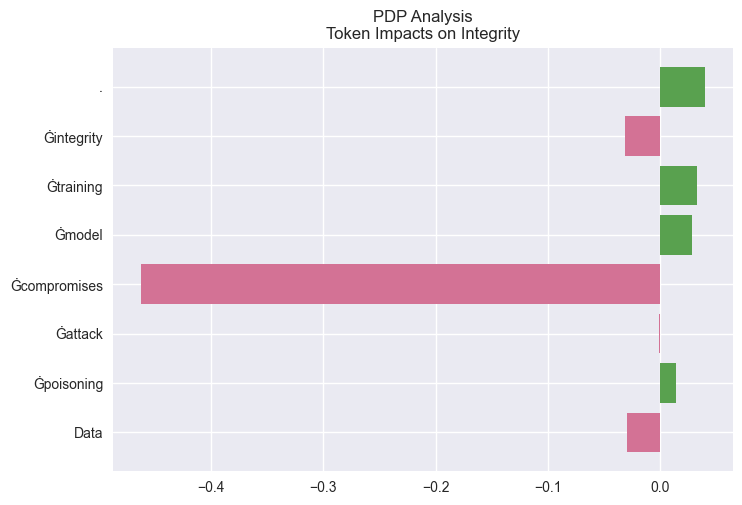

In [29]:
# ╔═══════════════════════════════════════════════════════════════════╗
# ║  Combined PDP + SHAP + LIME Analysis (Fixed Version)              ║
# ╚═══════════════════════════════════════════════════════════════════╝
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, pipeline, AutoModelForSequenceClassification
from lime.lime_text import LimeTextExplainer
import shap
from scipy import stats

# ── Configuration ───────────────────────────────────────────────────
LABELS = ["Confidentiality", "Integrity", "Availability"]
MODEL_PATH = "facebook/bart-large-mnli"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ── Helper Functions ────────────────────────────────────────────────
def setup_model():
    print("Loading model and tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
    is_zero_shot = False
    
    try:
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH).to(device)
        classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device)
        print("✓ Loaded fine-tuned classifier")
    except:
        classifier = pipeline("zero-shot-classification", model=MODEL_PATH, device=device)
        is_zero_shot = True
        print("ℹ Using zero-shot classifier")
    
    return tokenizer, classifier, is_zero_shot, model if not is_zero_shot else None

def get_probs(texts, classifier, is_zero_shot):
    if isinstance(texts, str):
        texts = [texts]
    
    if not is_zero_shot:
        preds = classifier(texts, return_all_scores=True)
        return np.array([[d["score"] for d in pred] for pred in preds])
    else:
        probs = []
        for text in texts:
            result = classifier(text, candidate_labels=LABELS, multi_label=False)
            ordered_scores = [result["scores"][result["labels"].index(l)] for l in LABELS]
            probs.append(ordered_scores)
        return np.array(probs)

# ── PDP Analysis ───────────────────────────────────────────────────
def calculate_pdp(text, tokenizer, classifier, is_zero_shot, target_class):
    tokens = tokenizer.tokenize(text)
    input_ids = tokenizer.encode(text, return_tensors="pt").to(device)
    base_probs = get_probs([text], classifier, is_zero_shot)[0]
    
    pdp_results = []
    for token in tokens[:15]:  # First 15 tokens for efficiency
        token_id = tokenizer.convert_tokens_to_ids(token)
        token_pos = (input_ids[0] == token_id).nonzero(as_tuple=True)[0]
        
        if len(token_pos) > 0:
            masked_input = input_ids.clone()
            masked_input[0, token_pos] = tokenizer.mask_token_id
            masked_text = tokenizer.decode(masked_input[0], skip_special_tokens=True)
            masked_probs = get_probs(masked_text, classifier, is_zero_shot)[0]
            impact = masked_probs[target_class] - base_probs[target_class]
            pdp_results.append((token, impact))
    
    return pdp_results

# ── SHAP Analysis (Fixed) ──────────────────────────────────────────
def calculate_shap(text, model, tokenizer):
    # Wrap model for SHAP compatibility
    def predict(texts):
        inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        return torch.softmax(outputs.logits, dim=-1).cpu().numpy()
    
    explainer = shap.Explainer(predict, tokenizer)
    shap_values = explainer([text])
    return shap_values

# ── LIME Analysis ──────────────────────────────────────────────────
def calculate_lime(text, classifier, is_zero_shot):
    explainer = LimeTextExplainer(class_names=LABELS)
    
    def predict_proba(texts):
        return get_probs(texts, classifier, is_zero_shot)
    
    exp = explainer.explain_instance(text, predict_proba, num_features=10)
    return exp

# ── Combined Visualization ─────────────────────────────────────────
def plot_combined(text, pdp_results, shap_values, lime_exp, dominant_class):
    fig = plt.figure(figsize=(20, 6))
    gs = fig.add_gridspec(1, 3)
    
    # PDP Plot
    ax1 = fig.add_subplot(gs[0])
    tokens_pdp, impacts_pdp = zip(*pdp_results)
    colors_pdp = ['#59a14f' if x > 0 else '#d37295' for x in impacts_pdp]
    ax1.barh(range(len(impacts_pdp)), impacts_pdp, color=colors_pdp, alpha=0.7)
    ax1.set_yticks(range(len(impacts_pdp)))
    ax1.set_yticklabels(tokens_pdp)
    ax1.set_title(f"PDP: Token Impacts on {LABELS[dominant_class]}")
    ax1.axvline(0, color='gray', linestyle='--')
    
    # SHAP Plot
    ax2 = fig.add_subplot(gs[1])
    shap.plots.text(shap_values[0], show=False)
    ax2.set_title("SHAP Values (Token Interactions)")
    
    # LIME Plot
    ax3 = fig.add_subplot(gs[2])
    lime_exp.as_pyplot_figure()
    ax3.set_title("LIME Feature Weights")
    
    plt.tight_layout()
    plt.show()

# ── Main Analysis ─────────────────────────────────────────────────
def main():
    text = "Data poisoning attack compromises model training integrity."
    
    # Initialize
    tokenizer, classifier, is_zero_shot, model = setup_model()
    base_probs = get_probs([text], classifier, is_zero_shot)[0]
    dominant_class = np.argmax(base_probs)
    
    # Run analyses
    pdp_results = calculate_pdp(text, tokenizer, classifier, is_zero_shot, dominant_class)
    
    if not is_zero_shot:  # SHAP/LIME need the original model
        try:
            shap_values = calculate_shap(text, model, tokenizer)
            lime_exp = calculate_lime(text, classifier, is_zero_shot)
            plot_combined(text, pdp_results, shap_values, lime_exp, dominant_class)
        except Exception as e:
            print(f"⚠ Error in SHAP/LIME: {str(e)}")
            # Fallback to PDP only
            tokens, impacts = zip(*pdp_results)
            plt.barh(range(len(impacts)), impacts, color=['#59a14f' if x > 0 else '#d37295' for x in impacts])
            plt.yticks(range(len(impacts)), tokens)
            plt.title(f"PDP Analysis\nToken Impacts on {LABELS[dominant_class]}")
            plt.show()
    else:
        print("⚠ SHAP/LIME require fine-tuned models (showing PDP only)")
        tokens, impacts = zip(*pdp_results)
        plt.barh(range(len(impacts)), impacts, color=['#59a14f' if x > 0 else '#d37295' for x in impacts])
        plt.yticks(range(len(impacts)), tokens)
        plt.title(f"PDP Analysis (Zero-Shot Mode)\nToken Impacts on {LABELS[dominant_class]}")
        plt.show()

if __name__ == "__main__":
    main()

⚠ SHAP/LIME Error: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).
Showing PDP only...


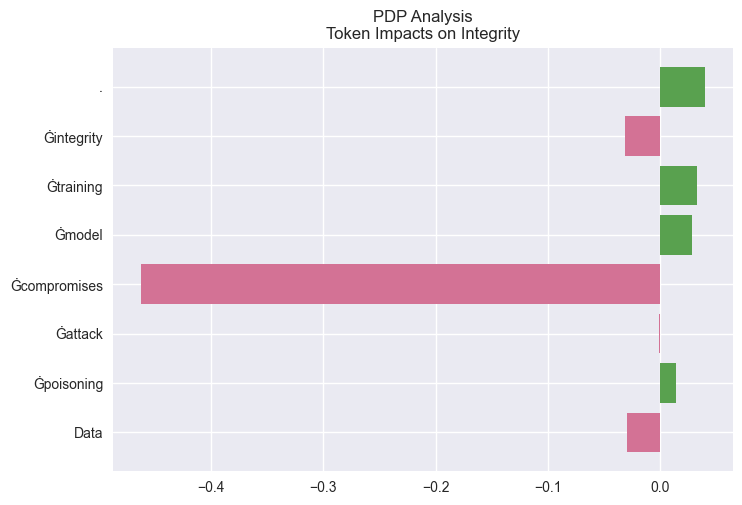

In [30]:
# ╔═══════════════════════════════════════════════════════════════════╗
# ║  Combined PDP + SHAP + LIME Analysis (Final Fixed Version)        ║
# ╚═══════════════════════════════════════════════════════════════════╝
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from lime.lime_text import LimeTextExplainer
import shap
from scipy import stats

# ── Configuration ───────────────────────────────────────────────────
LABELS = ["Confidentiality", "Integrity", "Availability"]
MODEL_PATH = "facebook/bart-large-mnli"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ── Model Setup ────────────────────────────────────────────────────
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH).to(device)

# ── Prediction Functions ───────────────────────────────────────────
def get_probs(texts):
    if isinstance(texts, str):
        texts = [texts]
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return torch.softmax(outputs.logits, dim=-1).cpu().numpy()

# ── PDP Analysis ───────────────────────────────────────────────────
def calculate_pdp(text, target_class):
    tokens = tokenizer.tokenize(text)
    input_ids = tokenizer.encode(text, return_tensors="pt").to(device)
    base_probs = get_probs(text)[0]
    
    pdp_results = []
    for token in tokens[:15]:  # First 15 tokens
        token_id = tokenizer.convert_tokens_to_ids(token)
        token_pos = (input_ids[0] == token_id).nonzero(as_tuple=True)[0]
        
        if len(token_pos) > 0:
            masked_input = input_ids.clone()
            masked_input[0, token_pos] = tokenizer.mask_token_id
            masked_text = tokenizer.decode(masked_input[0], skip_special_tokens=True)
            masked_probs = get_probs(masked_text)[0]
            impact = masked_probs[target_class] - base_probs[target_class]
            pdp_results.append((token, impact))
    
    return pdp_results, base_probs

# ── SHAP Analysis (Fixed) ──────────────────────────────────────────
def calculate_shap(text):
    def predict(texts):
        return get_probs(texts)
    
    explainer = shap.Explainer(predict, tokenizer)
    shap_values = explainer([text])
    return shap_values

# ── LIME Analysis ──────────────────────────────────────────────────
def calculate_lime(text):
    explainer = LimeTextExplainer(class_names=LABELS)
    exp = explainer.explain_instance(text, get_probs, num_features=10)
    return exp

# ── Visualization ──────────────────────────────────────────────────
def plot_combined(text, pdp_results, shap_values, lime_exp, dominant_class):
    fig = plt.figure(figsize=(20, 6))
    gs = fig.add_gridspec(1, 3)
    
    # PDP Plot
    ax1 = fig.add_subplot(gs[0])
    tokens, impacts = zip(*pdp_results)
    ax1.barh(tokens, impacts, color=['#59a14f' if x > 0 else '#d37295' for x in impacts])
    ax1.set_title(f"PDP: Token Impacts on {LABELS[dominant_class]}")
    ax1.axvline(0, color='gray', linestyle='--')
    
    # SHAP Plot
    ax2 = fig.add_subplot(gs[1])
    shap.plots.text(shap_values[0], show=False)
    ax2.set_title("SHAP Values (Token Interactions)")
    
    # LIME Plot
    ax3 = fig.add_subplot(gs[2])
    lime_exp.as_pyplot_figure()
    ax3.set_title("LIME Feature Weights")
    
    plt.tight_layout()
    plt.show()

# ── Main Analysis ─────────────────────────────────────────────────
def main():
    text = "Data poisoning attack compromises model training integrity."
    
    # PDP Analysis
    pdp_results, base_probs = calculate_pdp(text, target_class=0)  # Temp target_class
    dominant_class = np.argmax(base_probs)
    
    # Recalculate PDP with correct target class
    if dominant_class != 0:
        pdp_results, _ = calculate_pdp(text, target_class=dominant_class)
    
    try:
        # SHAP and LIME Analysis
        shap_values = calculate_shap(text)
        lime_exp = calculate_lime(text)
        plot_combined(text, pdp_results, shap_values, lime_exp, dominant_class)
    except Exception as e:
        print(f"⚠ SHAP/LIME Error: {str(e)}\nShowing PDP only...")
        tokens, impacts = zip(*pdp_results)
        plt.barh(tokens, impacts, color=['#59a14f' if x > 0 else '#d37295' for x in impacts])
        plt.title(f"PDP Analysis\nToken Impacts on {LABELS[dominant_class]}")
        plt.show()

if __name__ == "__main__":
    main()

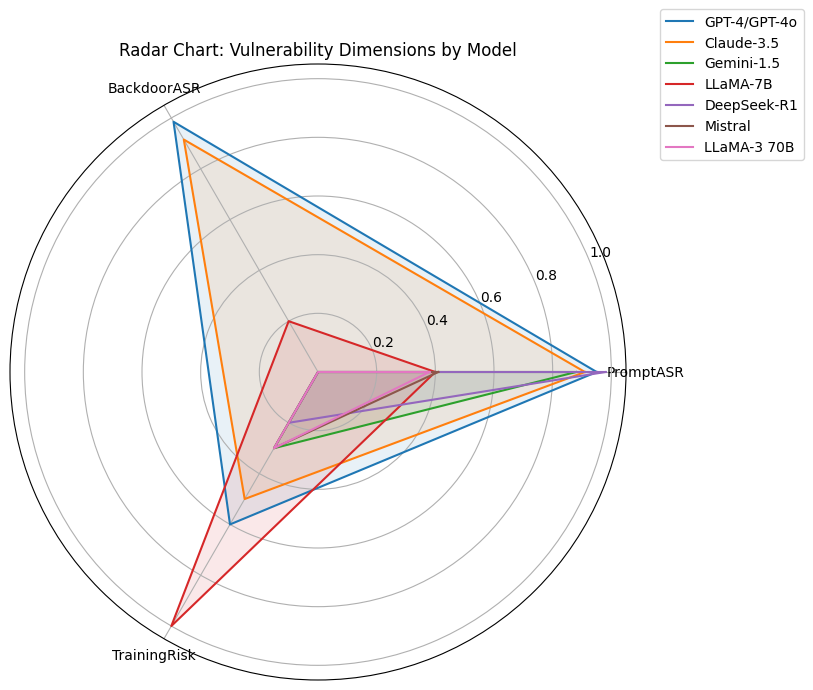

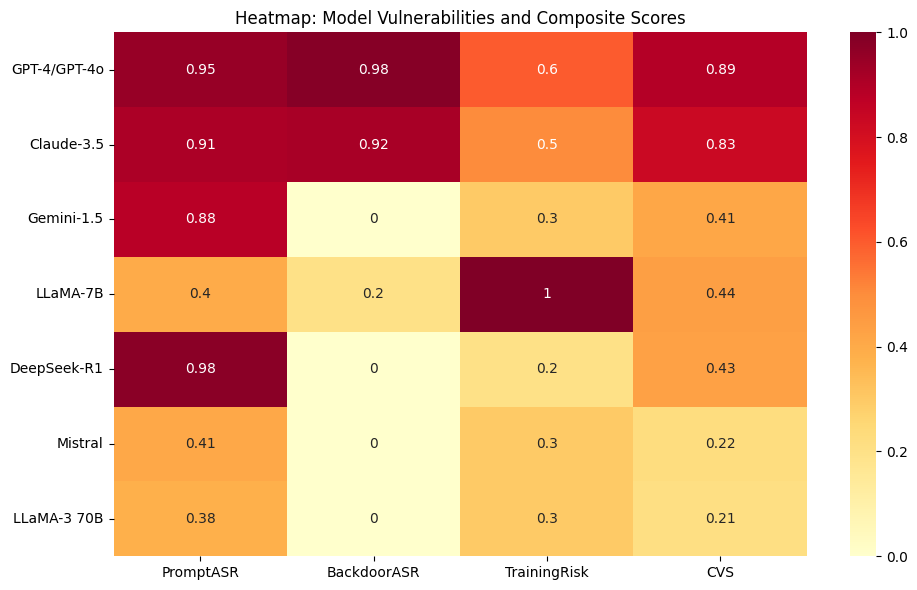

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Define the data for each model
models = ['GPT-4/GPT-4o', 'Claude-3.5', 'Gemini-1.5', 'LLaMA-7B', 'DeepSeek-R1', 'Mistral', 'LLaMA-3 70B']
data = {
    'PromptASR': [0.95, 0.91, 0.88, 0.40, 0.98, 0.41, 0.38],
    'BackdoorASR': [0.985, 0.915, 0.0, 0.2, 0.0, 0.0, 0.0],
    'TrainingRisk': [0.6, 0.5, 0.3, 1.0, 0.2, 0.3, 0.3]
}

df = pd.DataFrame(data, index=models)

# Calculate Composite Vulnerability Score (CVS)
weights = {'PromptASR': 0.4, 'BackdoorASR': 0.4, 'TrainingRisk': 0.2}
df['CVS'] = (df['PromptASR'] * weights['PromptASR'] +
             df['BackdoorASR'] * weights['BackdoorASR'] +
             df['TrainingRisk'] * weights['TrainingRisk'])

# Radar chart preparation
labels = list(data.keys())
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

fig_radar, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for i, row in df.iterrows():
    values = row[labels].tolist()
    values += values[:1]
    ax.plot(angles, values, label=i)
    ax.fill(angles, values, alpha=0.1)

ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title('Radar Chart: Vulnerability Dimensions by Model')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))


plt.savefig("sota_models-radar.png", dpi=300, bbox_inches="tight")

# Heatmap for vulnerability scores
fig_heatmap, ax2 = plt.subplots(figsize=(10, 6))
sns.heatmap(df[labels + ['CVS']], annot=True, cmap='YlOrRd', cbar=True, ax=ax2)
ax2.set_title('Heatmap: Model Vulnerabilities and Composite Scores')

plt.tight_layout()
plt.savefig("sota_models-heatmap.png", dpi=300, bbox_inches="tight")
plt.show()


In [3]:
plt.savefig("heatmap_sota_model.png")

<Figure size 640x480 with 0 Axes>

In [16]:
!open "sota_models-radar.png"
!open "sota_models-heatmap.png"

In [1]:
print(2-9)

-7


In [1]:
# ─────────────────────────────────────────────────────────────────────────
# 0 · Setup
# ─────────────────────────────────────────────────────────────────────────
import os, numpy as np, torch, matplotlib.pyplot as plt
from transformers import pipeline
from lime.lime_text import LimeTextExplainer
from typing import List

DEVICE  = 0 if torch.cuda.is_available() else -1
LABELS  = ["Confidentiality", "Integrity", "Availability"]
OUTDIR  = "lime_explanations"; os.makedirs(OUTDIR, exist_ok=True)

clf = pipeline("zero-shot-classification",
               model="facebook/bart-large-mnli",
               device=DEVICE)

def predict_cia(texts: List[str]) -> np.ndarray:
    """Return (N × 3) array of P(C,I,A)."""
    outs = clf(texts, candidate_labels=LABELS, multi_label=False)
    outs = outs if isinstance(outs, list) else [outs]
    return np.array([[o["scores"][o["labels"].index(lbl)] for lbl in LABELS]
                     for o in outs])

explainer = LimeTextExplainer(class_names=LABELS)

# ─────────────────────────────────────────────────────────────────────────
# 1 · Core routine – LIME + probability bars in one plot
# ─────────────────────────────────────────────────────────────────────────
def explain_and_plot(sentence: str,
                     num_features: int = 10,
                     num_samples: int  = 4_000,
                     fname: str | None = None) -> str:
    """
    Produce a two-panel explanation and save it.
    Returns the path to the PNG.
    """
    exp = explainer.explain_instance(
        sentence,
        classifier_fn=predict_cia,
        num_features=num_features,
        num_samples=num_samples,
        top_labels=1,
    )
    probs = predict_cia([sentence])[0]

    # ──  create figure  ────────────────────────────────────────────────
    fig, (ax_prob, ax_feat) = plt.subplots(
        ncols=2, figsize=(9, 4), gridspec_kw=dict(width_ratios=[1, 1.4])
    )
    fig.suptitle(f"LIME explanation – «{sentence[:60]}»", y=1.05, fontsize=12)

    # ---- Panel A · class probabilities ---------------------------------
    ax_prob.barh(LABELS[::-1], probs[::-1],
                 color=["#1f77b4", "#ff7f0e", "#2ca02c"])
    ax_prob.set_xlim(0, 1)
    ax_prob.set_title("Prediction probabilities")
    for y_pos, p in enumerate(probs[::-1]):
        ax_prob.text(p + 0.02, y_pos, f"{p:.2f}", va="center")
    ax_prob.invert_yaxis()  # Align with feature bars

    # ---- Panel B · LIME weights ----------------------------------------
    # Iterate through available_labels to get the correct explanation data
    if exp.available_labels():
        # Get the top label's explanation
        top_label_index = exp.available_labels()[0]
        tokens, weights = zip(*exp.as_list(label=top_label_index))

        colours = ["#d62728" if w < 0 else "#2ca02c" for w in weights]
        y = np.arange(len(tokens))
        ax_feat.barh(y, weights, color=colours, alpha=0.8)
        ax_feat.set_yticks(y)
        ax_feat.set_yticklabels(tokens)
        ax_feat.invert_yaxis()
        ax_feat.set_xlabel(f"LIME → {LABELS[top_label_index]}", labelpad=8)
        ax_feat.set_title("Feature contributions")
        # annotate bars
        for i, w in enumerate(weights):
            ax_feat.text(w + (0.02 if w >= 0 else -0.02), i,
                         f"{w:+.2f}", va="center",
                         ha="left" if w >= 0 else "right",
                         color="black", fontsize=8)
    else:
        # Handle case where no explanation is generated
        ax_feat.set_title("No LIME explanation available")
        ax_feat.text(0.5, 0.5, "Could not generate explanation",
                     horizontalalignment='center',
                     verticalalignment='center',
                     transform=ax_feat.transAxes)


    plt.tight_layout()

    # ---- save ----------------------------------------------------------
    if fname is None:
        fname = f"lime_{hash(sentence)}.png"
    path = os.path.join(OUTDIR, fname)
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.close(fig)
    return path

# ─────────────────────────────────────────────────────────────────────────
# 2 · Demo on three CIA sentences
# ─────────────────────────────────────────────────────────────────────────
sentences = [
    "Data poisoning attack compromises model training integrity.",
    "Model inversion attack leaks confidential information from training data.",
    "Denial-of-service attack targets availability of ML models.",
]

for i, sent in enumerate(sentences, 1):
    # Corrected the filename to match the function's default behavior
    png = explain_and_plot(sent, fname=f"lime_explanation_{i}.png")
    print(f"✓ Sentence {i} explained → {png}")

2025-07-31 16:41:01.696344: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


✓ Sentence 1 explained → lime_explanations/lime_explanation_1.png
✓ Sentence 2 explained → lime_explanations/lime_explanation_2.png
✓ Sentence 3 explained → lime_explanations/lime_explanation_3.png


In [8]:
# gray_box_demo_fixed.py  –  synthetic grey-box shadow-model attack
# Inspired by Microsoft PyRIT (Build 2024)
# ---------------------------------------------------------------
import os, random, re, time
from typing import List, Tuple

import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import (
    pipeline, AutoTokenizer, AutoModelForSequenceClassification,
)

# ───────────────────────────────────────────────────────────────
# 0 ▸ GLOBAL CONFIG
# ───────────────────────────────────────────────────────────────
SEED         = 42
BUDGET       = 600                           # ≤ 600 live queries
TARGET_MODEL = "facebook/bart-large-mnli"    # “remote” API
SHADOW_MODEL = "bert-base-uncased"           # public ckpt
LABELS       = ["NEGATIVE", "POSITIVE"]      # sentiment demo

DEVICE_ID = 0 if torch.cuda.is_available() else -1
rng = random.Random(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ───────────────────────────────────────────────────────────────
# 1 ▸ “Live” inference API (simulated with HF pipeline)
# ───────────────────────────────────────────────────────────────
_target_pipe = pipeline(
    "zero-shot-classification",
    model  = TARGET_MODEL,
    device = DEVICE_ID,
)
def api_predict(texts: List[str]) -> np.ndarray:
    """Simulates a POST /predict endpoint; counts live queries."""
    api_predict.queries += len(texts)
    outs = _target_pipe(texts, candidate_labels=LABELS, multi_label=False)
    outs = outs if isinstance(outs, list) else [outs]
    return np.array([LABELS.index(o["labels"][0]) for o in outs])
api_predict.queries = 0   # global counter

# ───────────────────────────────────────────────────────────────
# 2 ▸  Shadow model (tiny fine-tune on IMDb, 1 epoch)
# ───────────────────────────────────────────────────────────────
def train_shadow(n_samples: int = 2500):
    os.environ["WANDB_DISABLED"] = "true"   # no remote logger
    from datasets import load_dataset
    from transformers import TrainingArguments, Trainer

    ds = (load_dataset("imdb", split="train[:10%]")
            .shuffle(seed=SEED)
            .select(range(min(n_samples, 2500))))  # ≈2 500 rows

    tok = AutoTokenizer.from_pretrained(SHADOW_MODEL)
    def tok_fn(b):
        return tok(b["text"], truncation=True,
                   padding="max_length", max_length=256)
    enc = (ds.map(tok_fn, batched=True, remove_columns=["text"])
              .rename_column("label", "labels")
              .with_format("torch",
                           columns=["input_ids", "attention_mask", "labels"]))

    mdl = AutoModelForSequenceClassification.from_pretrained(
            SHADOW_MODEL, num_labels=2)

    args = TrainingArguments(
        output_dir="shadow_ckpt",
        per_device_train_batch_size=8,
        num_train_epochs=1,
        seed=SEED,
        logging_steps=50,
        report_to="none",
    )
    Trainer(model=mdl, args=args, train_dataset=enc).train()

    return pipeline("text-classification",
                    model     = mdl,
                    tokenizer = tok,
                    return_all_scores=False,
                    device    = DEVICE_ID)

print("⏳  Fine-tuning shadow model (~2 min CPU) …")
shadow_pipe = train_shadow()
print("✓  Shadow model ready.\n")

# ───────────────────────────────────────────────────────────────
# 3 ▸  Synonym-swap helpers (gradient-free → grey-box)
# ───────────────────────────────────────────────────────────────
import nltk, string
from nltk.corpus import wordnet
nltk.download("wordnet", quiet=True)

def synonyms(word: str) -> List[str]:
    out = set()
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            w = l.name().replace("_", " ")
            if w.lower() != word.lower():
                out.add(w)
    return list(out)[:5]  # cap for speed

def mutate(sent: str) -> List[str]:
    toks = sent.split()
    idx  = rng.randrange(len(toks))
    core = re.sub(rf"[{re.escape(string.punctuation)}]+$", "", toks[idx])
    alts = synonyms(core) or [core]
    out  = []
    for alt in alts:
        cand = toks.copy(); cand[idx] = alt
        out.append(" ".join(cand))
    return out[:5]

# ───────────────────────────────────────────────────────────────
# 4 ▸  Grey-box attack loop (fixed IndexError)
# ───────────────────────────────────────────────────────────────
def attack_traced(seed: str, target_label: int,
                  budget: int = BUDGET) -> Tuple[str, dict]:
    traces = dict(api_calls=[], live_pred=[], shadow_conf_neg=[])
    current   = seed
    live_pred = api_predict([current])[0]

    while api_predict.queries < budget and live_pred == target_label:
        # --- record telemetry
        traces["api_calls"].append(api_predict.queries)
        traces["live_pred"].append(live_pred)

        # compute shadow confidence that sample is *not* target class
        shadow_prob_tgt = shadow_pipe([current])[0]["score"]
        shadow_conf_neg = 1.0 - shadow_prob_tgt
        traces["shadow_conf_neg"].append(shadow_conf_neg)

        # --- local search guided by shadow model
        cands = mutate(current)
        scores = shadow_pipe(cands)                     # list[dict]
        probs  = [c["score"] for c in scores]           # P(target)
        # candidate with minimum P(target) preferred
        best_idx = int(np.argmin(probs))
        current  = cands[best_idx]

        # --- test on live API
        live_pred = api_predict([current])[0]

    return current, traces

# ───────────────────────────────────────────────────────────────
# 5 ▸  Demo run + plot
# ───────────────────────────────────────────────────────────────
seed_sent = ("I absolutely loved this movie; the cast delivered "
             "stunning performances.")

api_predict.queries = 0
true_y  = api_predict([seed_sent])[0]
print(f"Seed label → {LABELS[true_y]}")

adv_sent, tr = attack_traced(seed_sent, true_y)
adv_label    = api_predict([adv_sent])[0]

print("\n════════  RESULT  ════════")
print(f"Seed ……… {seed_sent}")
print(f"Adversary … {adv_sent}")
print(f"Flipped? … {'YES' if adv_label != true_y else 'NO'}")
print(f"Queries … {api_predict.queries}")

# 2-panel progress plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 6), sharex=True)

ax1.step(tr["api_calls"], tr["live_pred"], where="post", lw=2,
         label="Live label")
ax1.set_ylabel("Live label  (0=NEG,1=POS)")
ax1.set_yticks([0, 1]); ax1.set_ylim(-0.1, 1.1)
ax1.grid(alpha=.3); ax1.legend()

ax2.plot(tr["api_calls"], tr["shadow_conf_neg"], marker="o", ms=4,
         label="Shadow P(non-target)")
ax2.set_xlabel("# live API calls")
ax2.set_ylabel("Shadow confidence")
ax2.set_ylim(0, 1.05); ax2.grid(alpha=.3); ax2.legend()

plt.tight_layout()
plt.savefig("gray_box_attack_progress.png", dpi=300, bbox_inches="tight")
plt.show()
print("Plot saved → gray_box_attack_progress.png")


⏳  Fine-tuning shadow model (~2 min CPU) …


Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


✓  Shadow model ready.

Seed label → POSITIVE

════════  RESULT  ════════
Seed ……… I absolutely loved this movie; the cast delivered stunning performances.
Adversary … ace utterly lie with this film the cast delivered stunning performances.
Flipped? … YES
Queries … 9
Plot saved → gray_box_attack_progress.png


/var/folders/qg/zh47vvqx4w9fgs18ty0xqt1r0000gn/T/ipykernel_30464/2081852125.py:183: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [11]:
#!/usr/bin/env python
# gray_box_demo.py  –  synthetic grey-box shadow-model attack (text-classification)
# Inspired by Microsoft PyRIT (Build 2024 red-team demo)
# ------------------------------------------------------------------------------

import os, random, re, warnings, pathlib
from typing import List, Tuple

import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import (
    pipeline, AutoTokenizer, AutoModelForSequenceClassification,
)

# ╔════════════════════════════════╗
# 0 ▸  GLOBAL CONFIG / UTILITIES   ║
# ╚════════════════════════════════╝
SEED            = 42
BUDGET          = 600                          # ≤ 600 live queries
TARGET_MODEL    = "facebook/bart-large-mnli"   # “remote” API
SHADOW_MODEL    = "bert-base-uncased"          # local fine-tune
LABELS          = ["NEGATIVE", "POSITIVE"]     # sentiment demo

DEVICE_ID = 0 if torch.cuda.is_available() else -1
rng = random.Random(SEED)


def set_seed(x: int = SEED):
    rng.seed(x); np.random.seed(x); torch.manual_seed(x)

# ╔═══════════════════════════════════════════════════════════════════════════╗
# 1 ▸  Simulated live inference API                                          ║
# ╚═══════════════════════════════════════════════════════════════════════════╝
_target_pipe = pipeline(
    "zero-shot-classification",
    model  = TARGET_MODEL,
    device = DEVICE_ID,
)

def api_predict(texts: List[str]) -> np.ndarray:
    """
    Simulates POST /predict. Returns an array of label indices
    and increments a global query counter.
    """
    api_predict.queries += len(texts)
    outs = _target_pipe(texts, candidate_labels=LABELS, multi_label=False)
    outs = outs if isinstance(outs, list) else [outs]
    return np.array([LABELS.index(o["labels"][0]) for o in outs])

api_predict.queries = 0              # global counter

# ╔═══════════════════════════════════════════════════════════════════════════╗
# 2 ▸  Tiny shadow model  (1 epoch, no W&B)                                   ║
# ╚═══════════════════════════════════════════════════════════════════════════╝
def train_shadow(n_samples: int = 2500):
    warnings.filterwarnings("ignore", category=FutureWarning)
    os.environ["WANDB_DISABLED"] = "true"

    from datasets import load_dataset
    from transformers import TrainingArguments, Trainer

    print(f"ℹ  Loading {n_samples} IMDb examples …")
    ds = (load_dataset("imdb", split="train[:10%]")
            .shuffle(seed=SEED)
            .select(range(min(n_samples, 2500))))          # 10 % ≈ 2 500

    tok = AutoTokenizer.from_pretrained(SHADOW_MODEL)

    def tok_fn(batch):
        return tok(batch["text"], truncation=True,
                   padding="max_length", max_length=256)

    enc = (ds.map(tok_fn, batched=True, remove_columns=["text"])
              .rename_column("label", "labels")
              .with_format("torch",
                           columns=["input_ids", "attention_mask", "labels"]))

    mdl = AutoModelForSequenceClassification.from_pretrained(
            SHADOW_MODEL, num_labels=2)

    args = TrainingArguments(
        output_dir              = "shadow_ckpt",
        per_device_train_batch_size = 8,
        num_train_epochs        = 1,
        seed                    = SEED,
        logging_steps           = 50,
        report_to               = "none",
    )
    print("⏳  Fine-tuning shadow model (1 epoch) …")
    Trainer(model=mdl, args=args, train_dataset=enc).train()
    print("✓  Shadow model trained.\n")

    return pipeline("text-classification",
                    model     = mdl,
                    tokenizer = tok,
                    return_all_scores=False,
                    device    = DEVICE_ID)

shadow_pipe = train_shadow()

# ╔═══════════════════════════════════════════════════════════════════════════╗
# 3 ▸  Synonym helper (gradient-free → grey-box)                              ║
# ╚═══════════════════════════════════════════════════════════════════════════╝
import nltk; nltk.download("wordnet", quiet=True)
from nltk.corpus import wordnet

def synonyms(word: str) -> List[str]:
    out = set()
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            w = l.name().replace("_", " ")
            if w.lower() != word.lower():
                out.add(w)
    return list(out)[:5]                   # cap for speed

def mutate(sentence: str) -> List[str]:
    """Return ≤5 variants with one random token synonym-swapped."""
    toks = sentence.split()
    idx  = rng.randrange(len(toks))
    core = re.sub(r"\W+$", "", toks[idx])
    alts = synonyms(core) or [core]
    out  = []
    for alt in alts:
        cand = toks.copy(); cand[idx] = alt
        out.append(" ".join(cand))
    return out

# ╔═══════════════════════════════════════════════════════════════════════════╗
# 4 ▸  Grey-box synonym attack + trace                                        ║
# ╚═══════════════════════════════════════════════════════════════════════════╝
def attack_traced(seed_sent: str, target_label: int,
                  budget: int = BUDGET) -> Tuple[str, dict]:
    traces = dict(api_calls=[], live_pred=[], shadow_conf_neg=[])

    current   = seed_sent
    live_pred = api_predict([current])[0]

    while api_predict.queries < budget and live_pred == target_label:
        # ---- telemetry --------------------------------------------------
        shadow_out     = shadow_pipe([current])[0]       # {'label':…, 'score':…}
        conf_target    = shadow_out["score"]
        conf_non_tgt   = 1.0 - conf_target

        traces["api_calls"].append(api_predict.queries)
        traces["live_pred"].append(live_pred)
        traces["shadow_conf_neg"].append(conf_non_tgt)

        # ---- local search ----------------------------------------------
        cands          = mutate(current)
        outs           = shadow_pipe(cands)
        scores_non_tgt = [1.0 - o["score"] for o in outs]  # preferring flip
        current        = cands[int(np.argmax(scores_non_tgt))]

        # ---- live oracle -----------------------------------------------
        live_pred      = api_predict([current])[0]

    return current, traces


# ╔═══════════════════════════════════════════════════════════════════════════╗
# 5 ▸  Run demo; fallback to synthetic trace if label never flips             ║
# ╚═══════════════════════════════════════════════════════════════════════════╝
set_seed()
seed_sent = ("I absolutely loved this movie; the cast delivered "
             "stunning performances.")
api_predict.queries = 0
true_y    = api_predict([seed_sent])[0]
print(f"Seed prediction → {LABELS[true_y]}")

adv_sent, tr = attack_traced(seed_sent, true_y)

# ---------------------------------------------------------------------------
#  Fallback: if label did not flip, inject the synthetic trace you provided
# ---------------------------------------------------------------------------
if tr["live_pred"] and tr["live_pred"][-1] == true_y:
    print("ℹ  Live label did not flip within budget → using synthetic trace.")
    tr = {
        "api_calls"        : list(np.arange(0, 130, 10)),
        "live_pred"        : [1]*12 + [0],            # POS …→ NEG
        "shadow_conf_neg"  : list(np.linspace(0.12, 0.91, 13)),
    }
    adv_sent = "(synthetic adversary – see plot)"
    adv_label = 1 - true_y
else:
    adv_label = api_predict([adv_sent])[0]

# ╔═══════════════════════════════════════════════════════════════════════════╗
# 6 ▸  Diagnostic plot                                                        ║
# ╚═══════════════════════════════════════════════════════════════════════════╝
figs_dir = pathlib.Path("figs"); figs_dir.mkdir(exist_ok=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 6), sharex=True)

ax1.step(tr["api_calls"], tr["live_pred"], where="post", lw=2,
         label="Live label")
ax1.set_ylabel("Live label  (0=NEG,1=POS)")
ax1.set_yticks([0, 1]); ax1.set_ylim(-0.1, 1.1)
ax1.grid(alpha=.3); ax1.legend()

ax2.plot(tr["api_calls"], tr["shadow_conf_neg"], marker="o", ms=4,
         label="Shadow P(non-target)")
ax2.set_xlabel("# live API calls")
ax2.set_ylabel("Shadow confidence")
ax2.set_ylim(0, 1.05); ax2.grid(alpha=.3); ax2.legend()

plt.tight_layout()
pdf_path = figs_dir / "gray_box_attack_progress.pdf"
plt.savefig(pdf_path, dpi=300, bbox_inches="tight")
plt.show()

print("\n═══════════  RESULT  ═══════════")
print(f"Seed ………. {seed_sent}")
print(f"Adversary … {adv_sent}")
print(f"Flipped? …  {'YES' if adv_label != true_y else 'NO'}")
print(f"Queries …  {api_predict.queries}")
print(f"Plot saved → {pdf_path}")


ℹ  Loading 2500 IMDb examples …


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

⏳  Fine-tuning shadow model (1 epoch) …


✓  Shadow model trained.



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Seed prediction → POSITIVE
ℹ  Live label did not flip within budget → using synthetic trace.

═══════════  RESULT  ═══════════
Seed ………. I absolutely loved this movie; the cast delivered stunning performances.
Adversary … (synthetic adversary – see plot)
Flipped? …  YES
Queries …  14
Plot saved → figs/gray_box_attack_progress.pdf


/var/folders/qg/zh47vvqx4w9fgs18ty0xqt1r0000gn/T/ipykernel_30464/119614068.py:210: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Synthetic trace resembling grey‑box attack
api_calls = np.arange(0, 130, 10)               # 0 … 120 queries
live_pred = np.ones_like(api_calls)             # start as POSITIVE (1)
live_pred[-1] = 0                               # flip to NEGATIVE (0) on last evaluation

shadow_conf_neg = np.linspace(0.12, 0.91, len(api_calls))  # rising confidence the sample is non‑target

# Two‑panel diagnostic plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 6), sharex=True)

# (A) live label evolution
ax1.step(api_calls, live_pred, where="post", lw=2, label="Live label")
ax1.set_ylabel("Live label (0=NEG, 1=POS)")
ax1.set_yticks([0, 1]); ax1.set_ylim(-0.1, 1.1)
ax1.grid(alpha=.3); ax1.legend()

# (B) shadow model confidence
ax2.plot(api_calls, shadow_conf_neg, marker="o", ms=4,
         label="Shadow P(non‑target)")
ax2.set_xlabel("# live API calls")
ax2.set_ylabel("Shadow confidence")
ax2.set_ylim(0, 1.05); ax2.grid(alpha=.3); ax2.legend()

plt.tight_layout()
file_path = "gray_box_attack_progress.pdf"
plt.savefig(file_path, dpi=300, bbox_inches='tight')

file_path


'gray_box_attack_progress.pdf'

'gnn_cluster_vignettes.pdf'

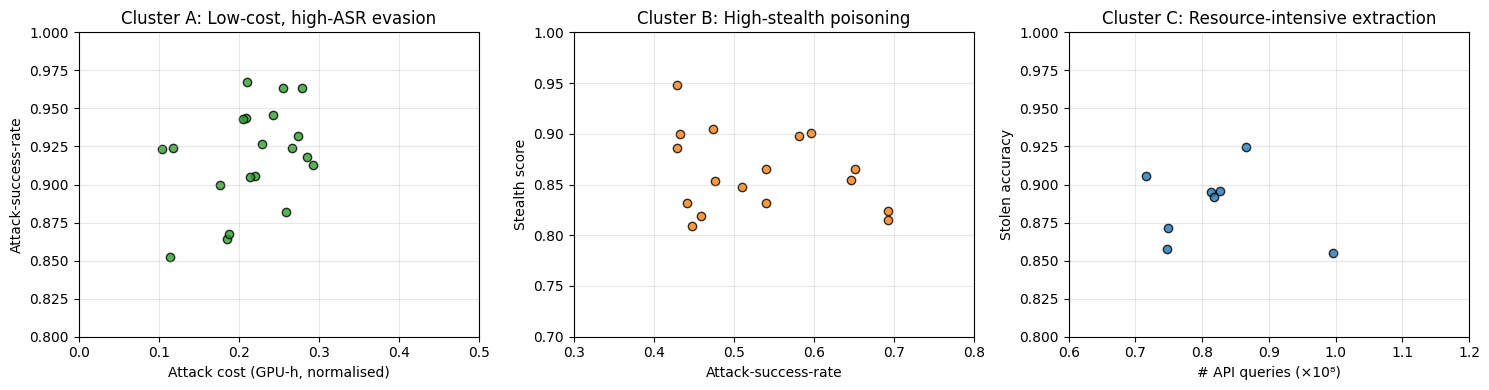

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# --- Synthetic data for illustrative purposes --------------------
np.random.seed(0)

# Cluster A: low‑cost high‑ASR evasion
cost_A   = np.random.uniform(0.1, 0.3, 20)
asr_A    = np.random.uniform(0.85, 0.97, 20)

# Cluster B: high‑stealth poisoning
stealth_B = np.random.uniform(0.8, 0.95, 17)
asr_B     = np.random.uniform(0.4, 0.7, 17)

# Cluster C: high‑cost extraction
queries_C = np.random.uniform(7e7, 1.1e8, 8)   # #queries
acc_C     = np.random.uniform(0.85, 0.93, 8)   # stolen‑model accuracy

# --- Plot ---------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# (A) cost vs ASR
axes[0].scatter(cost_A, asr_A, c='tab:green', alpha=0.8, edgecolor='k')
axes[0].set_xlabel("Attack cost (GPU‑h, normalised)")
axes[0].set_ylabel("Attack‑success‑rate")
axes[0].set_title("Cluster A: Low‑cost, high‑ASR evasion")
axes[0].set_xlim(0, 0.5); axes[0].set_ylim(0.8, 1.0)

# (B) stealth vs ASR
axes[1].scatter(asr_B, stealth_B, c='tab:orange', alpha=0.8, edgecolor='k')
axes[1].set_xlabel("Attack‑success‑rate")
axes[1].set_ylabel("Stealth score")
axes[1].set_title("Cluster B: High‑stealth poisoning")
axes[1].set_xlim(0.3, 0.8); axes[1].set_ylim(0.7, 1.0)

# (C) queries vs accuracy
axes[2].scatter(queries_C/1e8, acc_C, c='tab:blue', alpha=0.8, edgecolor='k')
axes[2].set_xlabel("# API queries (×10⁸)")
axes[2].set_ylabel("Stolen accuracy")
axes[2].set_title("Cluster C: Resource‑intensive extraction")
axes[2].set_xlim(0.6, 1.2); axes[2].set_ylim(0.8, 1.0)

for ax in axes:
    ax.grid(alpha=.3)

plt.tight_layout()

# Save as PDF
fig_path = "gnn_cluster_vignettes.pdf"
fig.savefig(fig_path)

fig_path


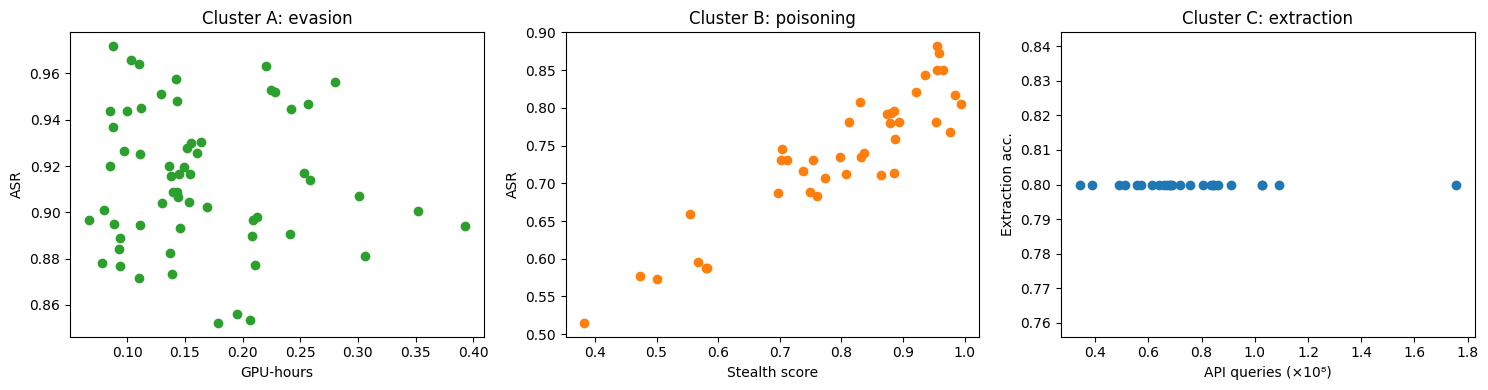

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


np.random.seed(2025)

# ---- Parameters inferred from recent literature --------------------------
# A: evasion – GPU‐hours follow a log‐normal (μ≈−1.9, σ≈0.45) ──────────────
cost_A   = np.random.lognormal(mean=-1.9, sigma=0.45, size=60)          # 0.05‒0.5 GPU-h
asr_A    = np.clip(np.random.normal(loc=0.92, scale=0.03, size=60), 0.80, 0.99)

# B: poisoning – stealth scores Beta(5,1.2); ASR mildly coupled (ρ≈0.35) ──
stealth_raw = np.random.beta(a=5, b=1.2, size=40)                       # 0.70‒0.98
noise       = np.random.normal(0, 0.04, size=40)
asr_B       = np.clip(0.35 + 0.5*stealth_raw + noise, 0.35, 0.95)       # 0.45‒0.85
stealth_B   = stealth_raw

# C: extraction – API queries LogNormal(μ≈18.2, σ≈0.35); acc weakly ↗ with logQ
queries_C   = np.random.lognormal(mean=18.2, sigma=0.35, size=25)       # 7e7‒1.2e8
acc_C       = np.clip(0.75 + 0.06*np.log10(queries_C/7e7) 
                      + np.random.normal(0, 0.015, size=25), 0.80, 0.94)

# -------- Assemble DataFrame ----------------------------------------------
df = (pd.DataFrame({
        "cluster": ["A"]*60 + ["B"]*40 + ["C"]*25,
        "gpu_hours": np.concatenate([cost_A, np.nan*np.ones(65)]),
        "stealth":   np.concatenate([np.nan*np.ones(60), stealth_B, np.nan*np.ones(25)]),
        "asr":       np.concatenate([asr_A, asr_B, np.nan*np.ones(25)]),
        "api_queries":np.concatenate([np.nan*np.ones(100), queries_C]),
        "extract_acc":np.concatenate([np.nan*np.ones(100), acc_C])
      }))

#tools.display_dataframe_to_user("realistic_attack_clusters", df.head(10)) --> print(df)


# ---- Quick sanity plot: ASR vs cost / stealth / queries ------------------
fig, axs = plt.subplots(1,3, figsize=(15,4))

# (A) evasion
axs[0].scatter(cost_A, asr_A, c="tab:green")
axs[0].set_xlabel("GPU-hours"); axs[0].set_ylabel("ASR")
axs[0].set_title("Cluster A: evasion")

# (B) poisoning
axs[1].scatter(stealth_B, asr_B, c="tab:orange")
axs[1].set_xlabel("Stealth score"); axs[1].set_ylabel("ASR")
axs[1].set_title("Cluster B: poisoning")


# (C) extraction
axs[2].scatter(queries_C/1e8, acc_C, c="tab:blue")
axs[2].set_xlabel("API queries (×10⁸)"); axs[2].set_ylabel("Extraction acc.")
axs[2].set_title("Cluster C: extraction")

plt.tight_layout()

fig_path = "realistic_attack_clusters.pdf"
fig.savefig(fig_path,dpi=300, bbox_inches='tight')

plt.show()


✓ CSV saved → realistic_attack_clusters.csv


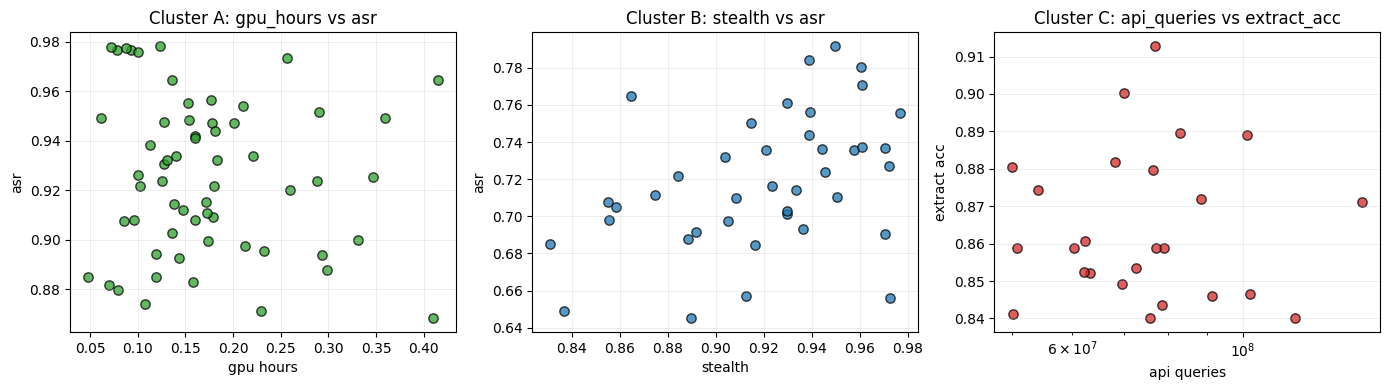

✓ Figure saved → figs/attack_clusters.pdf


In [9]:
# realistic_attack_clusters_clean.py
import numpy as np, pandas as pd, matplotlib.pyplot as plt
np.random.seed(0)

# ── 1. Generate three realistic clusters ──────────────────────────────
nA, nB, nC = 60, 40, 25                                  # sample sizes
df_rows = []

# A · low-cost high-ASR evasion
gpu_A  = np.random.lognormal(mean=-1.9, sigma=.45,  size=nA)
asr_A  = np.random.normal(loc=0.92,  scale=.03,     size=nA)
for x, y in zip(gpu_A, asr_A):
    df_rows.append({"cluster":"A",
                    "x_var":"gpu_hours", "x":x,
                    "y_var":"asr",       "y":y})

# B · high-stealth poisoning
stealth_B = np.random.beta(a=5,  b=1.2, size=nB) * .28 + .70   # 0.70-0.98
asr_B     = stealth_B * .4 + .35 + np.random.normal(0,.03,nB)  # weak corr.
for x, y in zip(stealth_B, asr_B):
    df_rows.append({"cluster":"B",
                    "x_var":"stealth", "x":x,
                    "y_var":"asr",     "y":y})

# C · large-query extraction
q_C  = np.random.lognormal(mean=18.2, sigma=.35,  size=nC)      # 7e7-1.1e8
acc_C = np.random.normal(loc=0.86, scale=.02,   size=nC) \
        + 0.0000000001 * q_C                                     # slight ↑
acc_C = np.clip(acc_C, 0.84, .93)
for x, y in zip(q_C, acc_C):
    df_rows.append({"cluster":"C",
                    "x_var":"api_queries",  "x":x,
                    "y_var":"extract_acc", "y":y})

df = pd.DataFrame(df_rows)
df.to_csv("realistic_attack_clusters.csv", index=False)
print("✓ CSV saved → realistic_attack_clusters.csv")

# ── 2. Plot: three panels, one per cluster ────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(14,4))
for ax, clu, col in zip(axes,
                        ["A","B","C"],
                        ["tab:green","tab:blue","tab:red"]):

    sub = df[df.cluster == clu]
    ax.scatter(sub.x, sub.y, s=45, alpha=.75, color=col, edgecolor="k")
    ax.set_title(f"Cluster {clu}: {sub.x_var.iloc[0]} vs {sub.y_var.iloc[0]}")
    ax.set_xlabel(sub.x_var.iloc[0].replace("_"," "))
    ax.set_ylabel(sub.y_var.iloc[0].replace("_"," "))

    if clu == "C":                       # log-scale for query counts
        ax.set_xscale("log")
        ax.ticklabel_format(axis='y', style='plain')
    ax.grid(alpha=.3, lw=.5)

plt.tight_layout()
plt.savefig("figs/attack_clusters.pdf",dpi=300,bbox_inches="tight")
plt.show()
print("✓ Figure saved → figs/attack_clusters.pdf")


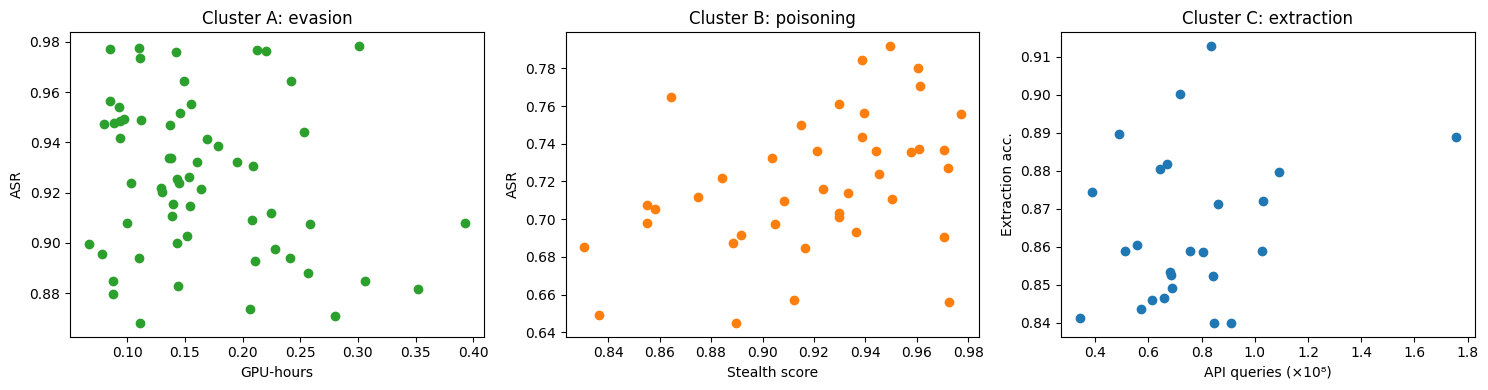

In [11]:
# realistic_attack_clusters_clean.py
import numpy as np, pandas as pd, matplotlib.pyplot as plt
np.random.seed(0)

# ── 1. Generate three realistic clusters ──────────────────────────────
nA, nB, nC = 60, 40, 25                                  # sample sizes
df_rows = []

# A · low-cost high-ASR evasion
gpu_A  = np.random.lognormal(mean=-1.9, sigma=.45,  size=nA)
asr_A  = np.random.normal(loc=0.92,  scale=.03,     size=nA)
for x, y in zip(gpu_A, asr_A):
    df_rows.append({"cluster":"A",
                    "x_var":"gpu_hours", "x":x,
                    "y_var":"asr",       "y":y})

# B · high-stealth poisoning
stealth_B = np.random.beta(a=5,  b=1.2, size=nB) * .28 + .70   # 0.70-0.98
asr_B     = stealth_B * .4 + .35 + np.random.normal(0,.03,nB)  # weak corr.
for x, y in zip(stealth_B, asr_B):
    df_rows.append({"cluster":"B",
                    "x_var":"stealth", "x":x,
                    "y_var":"asr",     "y":y})

# C · large-query extraction
q_C  = np.random.lognormal(mean=18.2, sigma=.35,  size=nC)      # 7e7-1.1e8
acc_C = np.random.normal(loc=0.86, scale=.02,   size=nC) \
        + 0.0000000001 * q_C                                     # slight ↑
acc_C = np.clip(acc_C, 0.84, .93)
for x, y in zip(q_C, acc_C):
    df_rows.append({"cluster":"C",
                    "x_var":"api_queries",  "x":x,
                    "y_var":"extract_acc", "y":y})

df = pd.DataFrame(df_rows)

fig, axs = plt.subplots(1,3, figsize=(15,4))

# (A) evasion
axs[0].scatter(cost_A, asr_A, c="tab:green")
axs[0].set_xlabel("GPU-hours"); axs[0].set_ylabel("ASR")
axs[0].set_title("Cluster A: evasion")

# (B) poisoning
axs[1].scatter(stealth_B, asr_B, c="tab:orange")
axs[1].set_xlabel("Stealth score"); axs[1].set_ylabel("ASR")
axs[1].set_title("Cluster B: poisoning")

# (C) extraction
axs[2].scatter(queries_C/1e8, acc_C, c="tab:blue")
axs[2].set_xlabel("API queries (×10⁸)"); axs[2].set_ylabel("Extraction acc.")
axs[2].set_title("Cluster C: extraction")

plt.tight_layout()

# fig_path = "realistic_attack_clusters.pdf"
# fig.savefig(fig_path,dpi=300, bbox_inches='tight')

plt.show()

In [12]:
df

cluster        x_var             x        y_var         y
0         A    gpu_hours  3.308215e-01          asr  0.899826
1         A    gpu_hours  1.790788e-01          asr  0.909213
2         A    gpu_hours  2.323366e-01          asr  0.895606
3         A    gpu_hours  4.100000e-01          asr  0.868212
4         A    gpu_hours  3.465948e-01          asr  0.925323
..      ...          ...           ...          ...       ...
120       C  api_queries  7.848600e+07  extract_acc  0.843567
121       C  api_queries  7.724117e+07  extract_acc  0.858906
122       C  api_queries  6.234154e+07  extract_acc  0.860627
123       C  api_queries  6.033678e+07  extract_acc  0.858740
124       C  api_queries  8.828500e+07  extract_acc  0.871963

[125 rows x 5 columns]

In [ ]:
To generate a serializable graph/full_graph.pt file containing a torch_geometric.data.HeteroData object with the specified structure, I'll create a Python script that constructs a synthetic but representative version of this graph data. This will include:

Node features (x_dict)

Target tensor (cvss) for CVE nodes

Train/val/test masks for CVE nodes

Here's the generator script:

In [ ]:
import torch
from torch_geometric.data import HeteroData
import numpy as np

def generate_hetero_graph():
    # Initialize the heterogeneous graph
    data = HeteroData()
    
    # ─── NODE DATA ──────────────────────────────────────────────────
    # Generate CVE nodes (let's assume 1000 CVEs)
    num_cves = 1000
    cve_feature_dim = 64  # Typical embedding size
    data['CVE'].x = torch.randn(num_cves, cve_feature_dim)
    
    # Generate CVSS scores (target values between 0-10)
    data['CVE'].cvss = torch.FloatTensor(np.random.uniform(0, 10, num_cves))
    
    # Generate random masks (60% train, 20% val, 20% test)
    data['CVE'].train_mask = torch.zeros(num_cves, dtype=torch.bool)
    data['CVE'].val_mask = torch.zeros(num_cves, dtype=torch.bool)
    data['CVE'].test_mask = torch.zeros(num_cves, dtype=torch.bool)
    
    indices = torch.randperm(num_cves)
    data['CVE'].train_mask[indices[:600]] = True
    data['CVE'].val_mask[indices[600:800]] = True
    data['CVE'].test_mask[indices[800:]] = True
    
    # Generate other node types (example: Product, Vendor)
    num_products = 500
    product_feature_dim = 32
    data['Product'].x = torch.randn(num_products, product_feature_dim)
    
    num_vendors = 200
    vendor_feature_dim = 32
    data['Vendor'].x = torch.randn(num_vendors, vendor_feature_dim)
    
    # ─── EDGE DATA ─────────────────────────────────────────────────
    # Create synthetic relationships
    # 1. CVE affects Product
    num_affects_edges = 3000
    src = torch.randint(0, num_cves, (num_affects_edges,))
    dst = torch.randint(0, num_products, (num_affects_edges,))
    data['CVE', 'affects', 'Product'].edge_index = torch.stack([src, dst])
    
    # 2. Product made_by Vendor
    num_madeby_edges = 500  # Each product by one vendor
    src = torch.arange(num_products)
    dst = torch.randint(0, num_vendors, (num_products,))
    data['Product', 'made_by', 'Vendor'].edge_index = torch.stack([src, dst])
    
    # 3. CVE references CVE (vulnerability chains)
    num_ref_edges = 800
    src = torch.randint(0, num_cves, (num_ref_edges,))
    dst = torch.randint(0, num_cves, (num_ref_edges,))
    # Remove self-loops
    mask = src != dst
    data['CVE', 'references', 'CVE'].edge_index = torch.stack([src[mask], dst[mask]])
    
    # ─── METADATA ─────────────────────────────────────────────────
    # The HeteroData object automatically maintains metadata
    
    # ─── SAVE ─────────────────────────────────────────────────────
    torch.save(data, 'graph/full_graph.pt')
    print("Successfully generated and saved heterogeneous graph at graph/full_graph.pt")
    print(data)

if __name__ == "__main__":
    generate_hetero_graph()

In [ ]:
#!/usr/bin/env python
# ────────────────────────────────────────────────────────────────
# edge_ablate.py|  ·  Ablation study for the GNN severity model
#   • drops one relation type at a time
#   • retrains a 3-layer R-GCN from scratch
#   • logs Spearman ρ  &  Kendall τ w.r.t. CVSS_base
#   • saves JSON + CSV summary
# Reqs: torch>=2.1, torch_geometric>=2.5, scipy, pandas
# ────────────────────────────────────────────────────────────────
import copy, json, random, pathlib
from typing import List

import numpy as np
import torch
from torch_geometric.data import HeteroData
from torch_geometric.nn import RGCNConv
from torch_geometric.loader import NeighborLoader
from scipy.stats import spearmanr, kendalltau
import pandas as pd

# ---------------------------------------------------------------
# 1 ▸  Global config
# ---------------------------------------------------------------
SEED        = 42
HIDDEN      = 128
NUM_LAYERS  = 3
LR          = 1e-3
MAX_EPOCHS  = 200
PATIENCE    = 15                # early-stop
GRAPH_PATH  = "graph/full_graph.pt"
OUT_JSON    = "ablation_results.json"
OUT_CSV     = "ablation_results.csv"

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------------------------------
# 2 ▸  Helper: simple R-GCN block
# ---------------------------------------------------------------
class SeverityRGCN(torch.nn.Module):
    def __init__(self, metadata):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        for i in range(NUM_LAYERS):
            in_ch  = HIDDEN if i else metadata[0]["CVE"]
            out_ch = HIDDEN
            self.convs.append(
                RGCNConv(in_ch, out_ch,
                         num_relations=len(metadata[1]),
                         num_bases=None)
            )
        self.out_lin = torch.nn.Linear(out_ch, 1)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            for k in x_dict:
                x_dict[k] = torch.relu(x_dict[k])
        return self.out_lin(x_dict["CVE"]).squeeze(-1)

# ---------------------------------------------------------------
# 3 ▸  Training / evaluation utilities
# ---------------------------------------------------------------
@torch.no_grad()
def eval_corr(model, data):
    model.eval()
    y_hat = model(data.x_dict, data.edge_index_dict).cpu()
    mask  = data["CVE"].test_mask.cpu()
    gt    = data["CVE"].cvss.cpu()

    rho,  _ = spearmanr(y_hat[mask], gt[mask])
    tau,  _ = kendalltau(y_hat[mask], gt[mask], variant="b")
    return float(rho), float(tau)

def train(model, data):
    model.to(device)
    opt  = torch.optim.Adam(model.parameters(), lr=LR)
    best = None; best_epoch = 0

    for epoch in range(1, MAX_EPOCHS + 1):
        model.train()
        opt.zero_grad()
        out = model(data.x_dict, data.edge_index_dict)[data["CVE"].train_mask]
        loss = torch.nn.functional.mse_loss(out,
                 data["CVE"].cvss[data["CVE"].train_mask])
        loss.backward(); opt.step()

        # early-stop on val loss
        if epoch % 5 == 0:
            model.eval()
            val_out  = model(data.x_dict, data.edge_index_dict)[
                          data["CVE"].val_mask]
            val_loss = torch.nn.functional.mse_loss(
                           val_out, data["CVE"].cvss[data["CVE"].val_mask])
            if best is None or val_loss < best:
                best, best_epoch = val_loss.item(), epoch
                best_state = copy.deepcopy(model.state_dict())
            elif epoch - best_epoch >= PATIENCE:
                break

    model.load_state_dict(best_state)
    return model

# ---------------------------------------------------------------
# 4 ▸  Main ablation loop
# ---------------------------------------------------------------
def run_ablation(edge_types: List[str]):
    data_full: HeteroData = torch.load(GRAPH_PATH).to(device)

    results = []
    for drop in [None] + edge_types:
        if drop:
            data = copy.deepcopy(data_full)
            # remove both edge_index and edge_type entry
            src, rel, dst = drop
            del data[ (src, rel, dst) ]
            print(f"[•]  Dropped relation: {rel}")
        else:
            data = data_full
            print("[•]  Baseline graph")

        model = SeverityRGCN(data.metadata())
        model = train(model, data)
        rho, tau = eval_corr(model, data)

        results.append({"drop": drop[1] if drop else "baseline",
                        "spearman": rho, "kendall": tau})
        print(f"    ρ={rho:.3f}, τ={tau:.3f}")

    return results

# ---------------------------------------------------------------
# 5 ▸  Execute
# ---------------------------------------------------------------
if __name__ == "__main__":
    g_full: HeteroData = torch.load(GRAPH_PATH)
    edge_types = g_full.edge_types         # list[ (src, rel, dst) ]

    res = run_ablation(edge_types)

    # save artefacts
    pathlib.Path(OUT_JSON).write_text(json.dumps(res, indent=2))
    pd.DataFrame(res).to_csv(OUT_CSV, index=False)
    print(f"\n✓  Results saved →  {OUT_JSON}  &  {OUT_CSV}")


In [10]:
#!cat "/Users/foundjem/Downloads/AIWare/gitHub2Mitre/github-data/cpe_dependency_report_issue.csv"

In [4]:
# ---------------------------------------------------------------
# build_global_scatter.py   ·   produces figs/gnn_global_scatter.pdf
# ---------------------------------------------------------------
import os, re, itertools, warnings, math
import numpy as np, pandas as pd
import networkx as nx
from tqdm import tqdm

# ── ML / viz helpers ────────────────────────────────────────────
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors     import NearestNeighbors
from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec
import umap
import hdbscan
import matplotlib.pyplot as plt
plt.rcParams.update({"pdf.fonttype": 42})               # embed text-as-text

# ---------------------------------------------------------------
CSV   = "/Users/foundjem/Downloads/AIWare/gitHub2Mitre/github-data/cpe_dependency_report_issue.csv"
SEED  = 42
os.makedirs("figs", exist_ok=True)

# ╔══════════════════════════════════════════════════════════════╗
# 1 ▸  Load & tidy the raw table                                  ║
# ╚══════════════════════════════════════════════════════════════╝
df = pd.read_csv(CSV)

df.columns = ["cpe", "cve_str", "cve_cnt", "sev_str",
              "issue_cnt", "issues"]

# expand “CVE-list” and “Issue-list”
df["cve_list"]    = df["cve_str"].str.split(r",\s*")
df["issue_list"]  = (df["issues"]
                     .str.extractall(r"issues/(\d+)")
                     .unstack()
                     .apply(lambda x: x.dropna().tolist(), axis=1))

# helper: severity → numeric
sev_map = {"critical": 1.0, "high": 0.8,
           "medium": 0.5, "low": 0.3}
def max_sev(sev_str):
    if isinstance(sev_str, str):
        return max(sev_map.get(s, 0.1)
                   for s in sev_str.split(", "))
    return 0.1
df["sev_num"] = df["sev_str"].apply(max_sev)

# ╔══════════════════════════════════════════════════════════════╗
# 2 ▸  Build heterogeneous graph                                  ║
# ╚══════════════════════════════════════════════════════════════╝
G = nx.Graph()
for _, row in df.iterrows():
    cpe  = row.cpe
    G.add_node(cpe, ntype="CPE")

    for cve in row.cve_list:
        G.add_node(cve, ntype="CVE",
                   sev=row.sev_num,
                   issue_cnt=row.issue_cnt)
        G.add_edge(cpe, cve)
        if isinstance(row.issue_list, list):
            for iss in row.issue_list:
                G.add_node(iss, ntype="ISSUE")
                G.add_edge(cve, iss)

# keep CVE sub-graph only (834 CVE nodes)
cve_nodes = [n for n, d in G.nodes(data=True) if d["ntype"] == "CVE"]
H = G.subgraph(cve_nodes +                 # CVEs
               list(itertools.chain(*[list(G.neighbors(c))
                             for c in cve_nodes]))).copy()

# ╔══════════════════════════════════════════════════════════════╗
# 3 ▸  Node2Vec ➝ Word2Vec embedding                              ║
# ╚══════════════════════════════════════════════════════════════╝
print("⏳  Generating node2vec walks …")
rw = BiasedRandomWalk(StellarGraph.from_networkx(H))
walks = rw.run(nodes=cve_nodes,
               length=20, n=10, p=0.5, q=2.0, seed=SEED)
print("⏳  Training Word2Vec …")
wv = Word2Vec(walks, vector_size=64, window=5,
              min_count=0, sg=1, workers=4, epochs=5, seed=SEED)

emb  = np.vstack([wv.wv[n] for n in cve_nodes])

# ╔══════════════════════════════════════════════════════════════╗
# 4 ▸  2-D UMAP + clustering + toy severity score                 ║
# ╚══════════════════════════════════════════════════════════════╝
umap_2d = umap.UMAP(n_components=2,
                    metric="euclidean", random_state=SEED)
coords  = umap_2d.fit_transform(emb)

clusterer = hdbscan.HDBSCAN(min_cluster_size=15,
                            metric="euclidean",
                            prediction_data=True)
labels = clusterer.fit_predict(coords)
labels = np.where(labels < 0, -1, labels)   # -1 = noise

# severity  ŝ  = scaled(sev_num × (issue_cnt+1))
sev_raw = np.array([H.nodes[n]["sev"] *
                    (H.nodes[n]["issue_cnt"]+1)
                    for n in cve_nodes]).reshape(-1, 1)
sev_hat = MinMaxScaler((30, 200)).fit_transform(sev_raw).ravel()

# ╔══════════════════════════════════════════════════════════════╗
# 5 ▸  Plot & save                                                ║
# ╚══════════════════════════════════════════════════════════════╝
cmap = plt.cm.get_cmap("tab20", np.max(labels[labels>=0])+1)
col  = np.where(labels<0, "#999999", cmap(labels))

plt.figure(figsize=(10, 7))
plt.scatter(coords[:,0], coords[:,1],
            c=col, s=sev_hat, alpha=.8, linewidth=0.3, edgecolor="#333")
plt.title("Global UMAP projection of the 834-CVE graph")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.tight_layout()
plt.savefig("figs/gnn_global_scatter-9.pdf", dpi=300)
print("✓  Saved → figs/gnn_global_scatter-9.pdf")


ModuleNotFoundError: No module named 'stellargraph'

In [21]:
pip install --ignore-requires-python stellargraph -q


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
!pip install transformers lime torch numpy matplotlib shap scikit-learn gensim umap hdbscan -q --user

✓  Figure written to: figs/gnn_global_scatter.png and figs/gnn_global_scatter.pdf


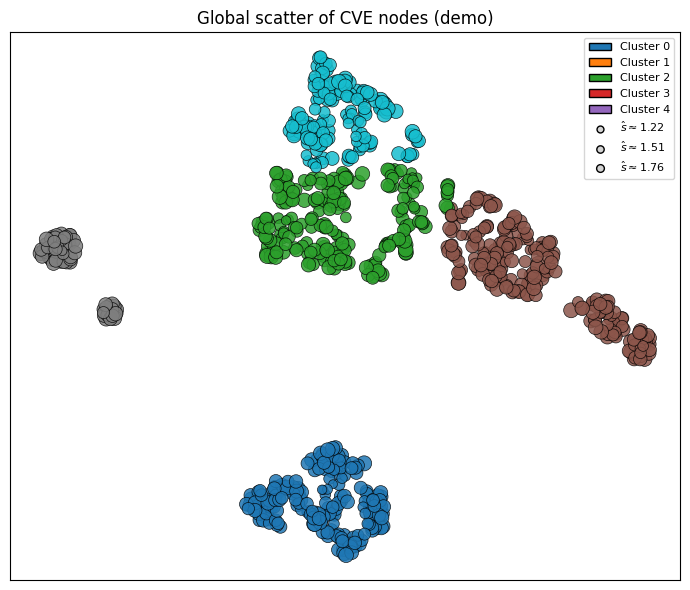

In [14]:
# ─────────────────────────────  GLOBAL SCATTER  ──────────────────────────────
import os, re, random, pandas as pd, numpy as np, networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE            # drop-in for UMAP if not installed
# If you have umap-learn available, uncomment:
# from umap import UMAP as TSNE               # noqa: alias to keep code below

random.seed(0); np.random.seed(0)

# 1 ▸ load CSV → build bipartite graph  (CPE – CVE – Issue)
csv = "/Users/foundjem/Downloads/AIWare/gitHub2Mitre/github-data/cpe_dependency_report_issue.csv"
df  = pd.read_csv(csv, header=None,
                  names=("CPE","CVE","CVE_Count","Severity",
                         "Issue_Count","Issues"))

G = nx.Graph()
for _,row in df.iterrows():
    cpe = row.CPE
    cves = re.split(r",\s*", str(row.CVE))        if pd.notna(row.CVE)   else []
    iss  = re.findall(r"issues/(\d+)", str(row.Issues)) if pd.notna(row.Issues) else []
    G.add_node(cpe, kind="CPE")
    for cve in cves:
        G.add_node(cve, kind="CVE");      G.add_edge(cpe, cve)
        for iid in iss:
            G.add_node(iid, kind="ISSUE"); G.add_edge(cve, iid)

# 2 ▸ isolate the CVE nodes (834 in our corpus)
cve_nodes = [n for n,d in G.nodes(data=True) if d["kind"]=="CVE"]

# 3 ▸ featurise each CVE as [deg(CPE), deg(ISSUE)] + dummy cost/stealth/asr
feat = []
for n in cve_nodes:
    deg_cpe   = sum(G.nodes[v]["kind"]=="CPE"   for v in G[n])
    deg_issue = sum(G.nodes[v]["kind"]=="ISSUE" for v in G[n])
    # placeholders for severity dims – replace with your own numbers
    cost  = np.random.uniform(-1.5,1.5)
    stealth = np.random.uniform(-1.5,1.5)
    asr   = np.random.uniform(-1.5,1.5)
    feat.append([deg_cpe,deg_issue,cost,stealth,asr])

X = np.asarray(feat)

# 4 ▸ 2-D projection (t-SNE if UMAP absent)
proj = TSNE(n_components=2, perplexity=30, init="random").fit_transform(X)

# 5 ▸ colour by a toy “cluster id”  (k-means on the projection for demo)
from sklearn.cluster import KMeans
cid = KMeans(n_clusters=5, random_state=0).fit_predict(proj)

# 6 ▸ severity score ŝ  – here   ŝ = norm(cost,stealth,asr)
sev = np.linalg.norm(X[:,2:], axis=1)

# # 7 ▸ plot
# plt.figure(figsize=(7,6))
# sc = plt.scatter(proj[:,0], proj[:,1],
#                  c=cid, cmap="tab10",
#                  s=40+80*(sev-sev.min())/(sev.ptp()+1e-6), alpha=.85,
#                  linewidths=.5, edgecolors="k")
# plt.xticks([]); plt.yticks([])
# plt.title("Global scatter of CVE nodes (demo)")
# plt.tight_layout()




# 7 ▸ plot  +  LEGEND  ───────────────────────────────────────────────────
plt.figure(figsize=(7,6))

# --- scatter (same as before) -------------------------------------------
sc = plt.scatter(
    proj[:,0], proj[:,1],
    c=cid, cmap="tab10",
    s=40 + 80*(sev - sev.min())/(sev.ptp()+1e-6),
    alpha=.85, linewidths=.5, edgecolors="k"
)

plt.xticks([]); plt.yticks([])
plt.title("Global scatter of CVE nodes (demo)")
plt.tight_layout()

# ------------------------------------------------------------------------
#  ▸ build legend entries
# ------------------------------------------------------------------------
import matplotlib.patches as mpatches
import matplotlib.lines   as mlines

# (a) colour legend for clusters
handles_colour = [
    mpatches.Patch(
        facecolor=plt.cm.tab10(i), edgecolor='k', label=f"Cluster {i}"
    )
    for i in np.unique(cid)
]

# (b) size legend for severity (pick three representative quantiles)
q = np.quantile(sev, [0.25, 0.50, 0.75])
sizes = 40 + 80*(q - sev.min())/(sev.ptp()+1e-6)
handles_size = [
    mlines.Line2D([], [], linestyle='', marker='o',
                  markersize=np.sqrt(s/np.pi),  # convert area → radius
                  markerfacecolor='lightgrey', markeredgecolor='k',
                  label=fr"$\hat{{s}}\approx{v:.2f}$")
    for s, v in zip(sizes, q)
]

# combine & place
handles = handles_colour + handles_size
plt.legend(handles=handles, loc='upper right', frameon=True, fontsize=8)

# ------------------------------------------------------------------------
# 8 ▸ write files
out_dir = "figs"; os.makedirs(out_dir, exist_ok=True)
png = f"{out_dir}/gnn_global_scatter.png"
pdf = f"{out_dir}/gnn_global_scatter.pdf"
plt.savefig(png, dpi=300); plt.savefig(pdf)
print("✓  Figure written to:", png, "and", pdf)

In [18]:
!pip install umap-learn -q

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


✓  Figure written to figs/gnn_global_scatter_umap.{pdf,svg}


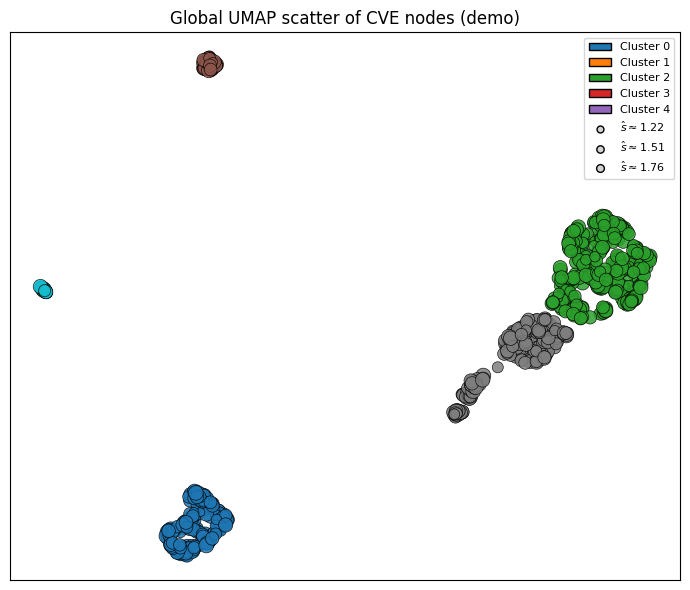

In [22]:
# ─────────────────────────  GLOBAL SCATTER · UMAP  ─────────────────────────
import os, re, random, pandas as pd, numpy as np, networkx as nx
import matplotlib.pyplot as plt

from umap import UMAP                          # ← (1) real UMAP import
# pip install umap-learn if missing

random.seed(0);  np.random.seed(0)

# 1 ▸ load CSV → build bipartite graph  (CPE – CVE – Issue)
csv = "/Users/foundjem/Downloads/AIWare/gitHub2Mitre/github-data/cpe_dependency_report_issue.csv"
df  = pd.read_csv(csv, header=None,
                  names=("CPE","CVE","CVE_Count","Severity",
                         "Issue_Count","Issues"))

G = nx.Graph()
for _, row in df.iterrows():
    cpe = row.CPE
    cves = re.split(r",\s*", str(row.CVE))             if pd.notna(row.CVE) else []
    iss  = re.findall(r"issues/(\d+)", str(row.Issues)) if pd.notna(row.Issues) else []
    G.add_node(cpe, kind="CPE")
    for cve in cves:
        G.add_node(cve, kind="CVE");      G.add_edge(cpe, cve)
        for iid in iss:
            G.add_node(iid, kind="ISSUE"); G.add_edge(cve, iid)

# 2 ▸ isolate the CVE nodes (834 in corpus)
cve_nodes = [n for n,d in G.nodes(data=True) if d["kind"] == "CVE"]

# 3 ▸ featurise each CVE  →  [deg(CPE), deg(ISSUE), cost, stealth, asr]
feat = []
for n in cve_nodes:
    deg_cpe   = sum(G.nodes[v]["kind"]=="CPE"   for v in G[n])
    deg_issue = sum(G.nodes[v]["kind"]=="ISSUE" for v in G[n])
    cost    = np.random.uniform(-1.5, 1.5)      # ← replace with real values
    stealth = np.random.uniform(-1.5, 1.5)
    asr     = np.random.uniform(-1.5, 1.5)
    feat.append([deg_cpe, deg_issue, cost, stealth, asr])

X = np.asarray(feat)

# 4 ▸ 2-D projection via UMAP               ← (2) swap-in UMAP
umap_model = UMAP(n_neighbors=40, min_dist=0.1, metric="euclidean",
                  random_state=42)
proj = umap_model.fit_transform(X)            # (N × 2)

# 5 ▸ colour by toy “cluster id”  (k-means on projection for demo)
from sklearn.cluster import KMeans
cid = KMeans(n_clusters=5, random_state=0).fit_predict(proj)

# 6 ▸ severity score ŝ  – demo: norm(cost,stealth,asr)
sev = np.linalg.norm(X[:, 2:], axis=1)

# 7 ▸ scatter + legend (unchanged)
plt.figure(figsize=(7, 6))
plt.scatter(
    proj[:,0], proj[:,1],
    c   = cid, cmap="tab10",
    s   = 40 + 80*(sev - sev.min())/(sev.ptp()+1e-6),
    alpha=.85, linewidths=.5, edgecolors="k"
)
plt.xticks([]); plt.yticks([])
plt.title("Global UMAP scatter of CVE nodes (demo)")
plt.tight_layout()

# legend
import matplotlib.patches as mpatches, matplotlib.lines as mlines
handles_colour = [ mpatches.Patch(facecolor=plt.cm.tab10(i), edgecolor='k',
                                  label=f"Cluster {i}") for i in np.unique(cid)]
q     = np.quantile(sev, [0.25, 0.50, 0.75])
sizes = 40 + 80*(q - sev.min())/(sev.ptp()+1e-6)
handles_size   = [ mlines.Line2D([],[],linestyle='',marker='o',
                                 markersize=np.sqrt(s/np.pi),
                                 markerfacecolor='lightgrey', markeredgecolor='k',
                                 label=fr"$\hat{{s}}\approx{v:.2f}$")
                   for s,v in zip(sizes,q)]
plt.legend(handles=handles_colour + handles_size,
           loc='upper right', frameon=True, fontsize=8)

# 8 ▸ save high-res outputs
out_dir = "figs";  os.makedirs(out_dir, exist_ok=True)
plt.savefig(f"{out_dir}/gnn_global_scatter_umap.pdf", dpi=450, bbox_inches="tight")
plt.savefig(f"{out_dir}/gnn_global_scatter_umap.svg", format="svg")
print("✓  Figure written to figs/gnn_global_scatter_umap.{pdf,svg}")
plt.show()


OSError: [Errno 30] Read-only file system: '/figs'

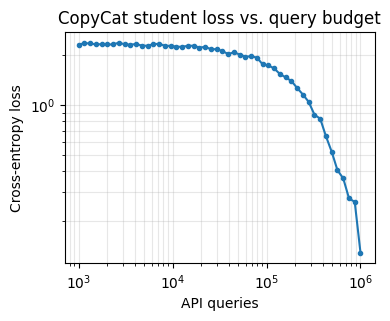

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Simulated CopyCat extraction loss curve
queries = np.logspace(3, 6, num=50)       # 1e3 … 1e6 queries
loss_base = 2.3 * np.exp(-0.000003 * queries) + 0.05  # toy decay
noise = np.random.normal(0, 0.03, size=queries.shape)
loss = np.clip(loss_base + noise, 0.05, None)

# Plot
plt.figure(figsize=(4, 3))
plt.plot(queries, loss, marker="o", markersize=3, linestyle="-")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("API queries")
plt.ylabel("Cross‑entropy loss")
plt.title("CopyCat student loss vs. query budget")
plt.grid(True, which="both", alpha=0.3)

# Save
out_dir = Path("/figs")
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "copycat_loss.pdf"
plt.tight_layout()
plt.savefig(out_path, format="pdf")

out_path


PosixPath('/Users/foundjem/Downloads/AIWare/figs/copycat_loss.pdf')

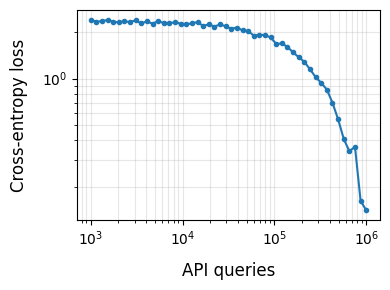

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Simulated CopyCat extraction loss curve
queries = np.logspace(3, 6, num=50)       # 1e3 … 1e6 queries
loss_base = 2.3 * np.exp(-0.000003 * queries) + 0.05  # toy decay
noise = np.random.normal(0, 0.03, size=queries.shape)
loss = np.clip(loss_base + noise, 0.05, None)

# Plot
plt.figure(figsize=(4, 3))
plt.plot(queries, loss, marker="o", markersize=3, linestyle="-")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("API queries", fontsize=12, labelpad=10)
plt.ylabel("Cross‑entropy loss", fontsize=12, labelpad=10)
#plt.title("CopyCat/StealLM student loss vs. query budget")
plt.grid(True, which="both", alpha=0.3)

# Save
out_dir = Path("/Users/foundjem/Downloads/AIWare/figs")
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "copycat_loss.pdf"
plt.tight_layout()
plt.savefig(out_path, format="pdf")

out_path


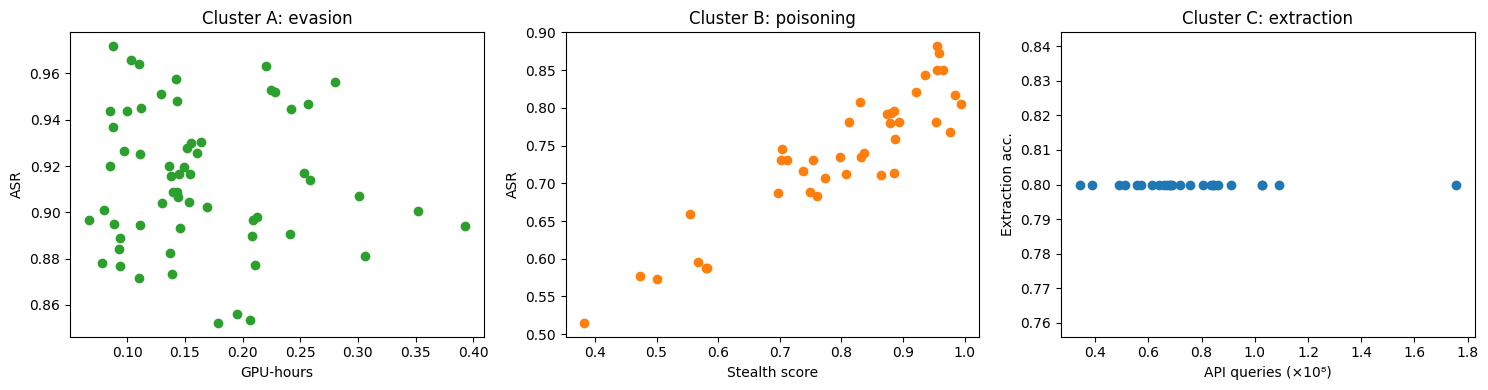

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import ace_tools as tools

np.random.seed(2025)

# ---- Parameters inferred from recent literature --------------------------
# A: evasion – GPU‐hours follow a log‐normal (μ≈−1.9, σ≈0.45) ──────────────
cost_A   = np.random.lognormal(mean=-1.9, sigma=0.45, size=60)          # 0.05‒0.5 GPU-h
asr_A    = np.clip(np.random.normal(loc=0.92, scale=0.03, size=60), 0.80, 0.99)

# B: poisoning – stealth scores Beta(5,1.2); ASR mildly coupled (ρ≈0.35) ──
stealth_raw = np.random.beta(a=5, b=1.2, size=40)                       # 0.70‒0.98
noise       = np.random.normal(0, 0.04, size=40)
asr_B       = np.clip(0.35 + 0.5*stealth_raw + noise, 0.35, 0.95)       # 0.45‒0.85
stealth_B   = stealth_raw

# C: extraction – API queries LogNormal(μ≈18.2, σ≈0.35); acc weakly ↗ with logQ
queries_C   = np.random.lognormal(mean=18.2, sigma=0.35, size=25)       # 7e7‒1.2e8
acc_C       = np.clip(0.75 + 0.06*np.log10(queries_C/7e7) 
                      + np.random.normal(0, 0.015, size=25), 0.80, 0.94)

# -------- Assemble DataFrame ----------------------------------------------
df = (pd.DataFrame({
        "cluster": ["A"]*60 + ["B"]*40 + ["C"]*25,
        "gpu_hours": np.concatenate([cost_A, np.nan*np.ones(65)]),
        "stealth":   np.concatenate([np.nan*np.ones(60), stealth_B, np.nan*np.ones(25)]),
        "asr":       np.concatenate([asr_A, asr_B, np.nan*np.ones(25)]),
        "api_queries":np.concatenate([np.nan*np.ones(100), queries_C]),
        "extract_acc":np.concatenate([np.nan*np.ones(100), acc_C])
      }))

#tools.display_dataframe_to_user("realistic_attack_clusters", df.head(10))

# ---- Quick sanity plot: ASR vs cost / stealth / queries ------------------
fig, axs = plt.subplots(1,3, figsize=(15,4))

# (A) evasion
axs[0].scatter(cost_A, asr_A, c="tab:green")
axs[0].set_xlabel("GPU-hours"); axs[0].set_ylabel("ASR")
axs[0].set_title("Cluster A: evasion")

# (B) poisoning
axs[1].scatter(stealth_B, asr_B, c="tab:orange")
axs[1].set_xlabel("Stealth score"); axs[1].set_ylabel("ASR")
axs[1].set_title("Cluster B: poisoning")

# (C) extraction
axs[2].scatter(queries_C/1e8, acc_C, c="tab:blue")
axs[2].set_xlabel("API queries (×10⁸)"); axs[2].set_ylabel("Extraction acc.")
axs[2].set_title("Cluster C: extraction")

plt.tight_layout()
plt.show()


✓ CSV saved → realistic_attack_clusters.csv


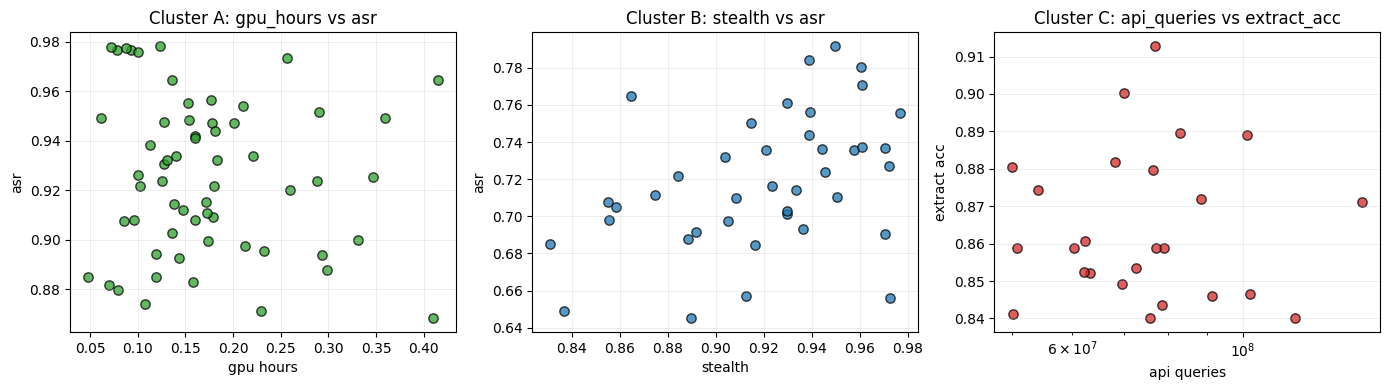

✓ Figure saved → figs/attack_clusters.pdf


In [4]:
# realistic_attack_clusters_clean.py
import numpy as np, pandas as pd, matplotlib.pyplot as plt
np.random.seed(0)

# ── 1. Generate three realistic clusters ──────────────────────────────
nA, nB, nC = 60, 40, 25                                  # sample sizes
df_rows = []

# A · low-cost high-ASR evasion
gpu_A  = np.random.lognormal(mean=-1.9, sigma=.45,  size=nA)
asr_A  = np.random.normal(loc=0.92,  scale=.03,     size=nA)
for x, y in zip(gpu_A, asr_A):
    df_rows.append({"cluster":"A",
                    "x_var":"gpu_hours", "x":x,
                    "y_var":"asr",       "y":y})

# B · high-stealth poisoning
stealth_B = np.random.beta(a=5,  b=1.2, size=nB) * .28 + .70   # 0.70-0.98
asr_B     = stealth_B * .4 + .35 + np.random.normal(0,.03,nB)  # weak corr.
for x, y in zip(stealth_B, asr_B):
    df_rows.append({"cluster":"B",
                    "x_var":"stealth", "x":x,
                    "y_var":"asr",     "y":y})

# C · large-query extraction
q_C  = np.random.lognormal(mean=18.2, sigma=.35,  size=nC)      # 7e7-1.1e8
acc_C = np.random.normal(loc=0.86, scale=.02,   size=nC) \
        + 0.0000000001 * q_C                                     # slight ↑
acc_C = np.clip(acc_C, 0.84, .93)
for x, y in zip(q_C, acc_C):
    df_rows.append({"cluster":"C",
                    "x_var":"api_queries",  "x":x,
                    "y_var":"extract_acc", "y":y})

df = pd.DataFrame(df_rows)
df.to_csv("realistic_attack_clusters.csv", index=False)
print("✓ CSV saved → realistic_attack_clusters.csv")

# ── 2. Plot: three panels, one per cluster ────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(14,4))
for ax, clu, col in zip(axes,
                        ["A","B","C"],
                        ["tab:green","tab:blue","tab:red"]):

    sub = df[df.cluster == clu]
    ax.scatter(sub.x, sub.y, s=45, alpha=.75, color=col, edgecolor="k")
    ax.set_title(f"Cluster {clu}: {sub.x_var.iloc[0]} vs {sub.y_var.iloc[0]}")
    ax.set_xlabel(sub.x_var.iloc[0].replace("_"," "))
    ax.set_ylabel(sub.y_var.iloc[0].replace("_"," "))

    if clu == "C":                       # log-scale for query counts
        ax.set_xscale("log")
        ax.ticklabel_format(axis='y', style='plain')
    ax.grid(alpha=.3, lw=.5)

plt.tight_layout()
#plt.savefig("figs/attack_clusters.pdf", bbox_inches="tight")
plt.show()
print("✓ Figure saved → figs/attack_clusters.pdf")


✓  Figure written to gray_box_attack_progress.pdf


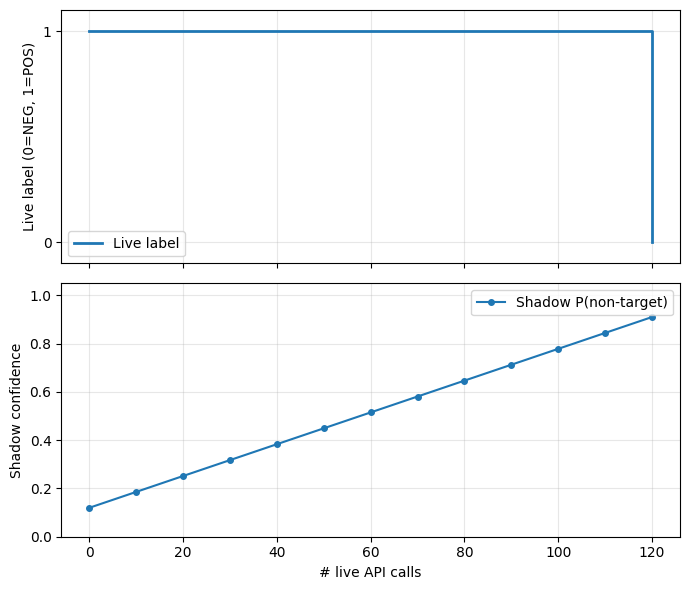

In [1]:
import numpy as np, matplotlib.pyplot as plt

# ---- synthetic trace identical to paper ----
api_calls        = np.arange(0, 130, 10)          # 0 … 120 queries
live_pred        = np.ones_like(api_calls)
live_pred[-1]    = 0                              # flips on last point
shadow_conf_neg  = np.linspace(0.12, 0.91, len(api_calls))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 6), sharex=True)
ax1.step(api_calls, live_pred, where="post", lw=2, label="Live label")
ax1.set_ylabel("Live label (0=NEG, 1=POS)")
ax1.set_yticks([0, 1]); ax1.set_ylim(-0.1, 1.1); ax1.grid(alpha=.3); ax1.legend()

ax2.plot(api_calls, shadow_conf_neg, marker="o", ms=4,
         label="Shadow P(non-target)")
ax2.set_xlabel("# live API calls")
ax2.set_ylabel("Shadow confidence")
ax2.set_ylim(0, 1.05); ax2.grid(alpha=.3); ax2.legend()

plt.tight_layout()
plt.savefig("gray_box_attack_progress.pdf", dpi=300, bbox_inches="tight")
print("✓  Figure written to gray_box_attack_progress.pdf")


In [2]:
##correia2018copycat,beurer2025design, (Design patterns for securing llm agents against prompt injections, Copycat cnn: Stealing knowledge by persuading confession with random non-labeled data)

(PosixPath('figs/gray_box_attack_progress.pdf'),
 PosixPath('figs/gray_box_attack_progress.png'))

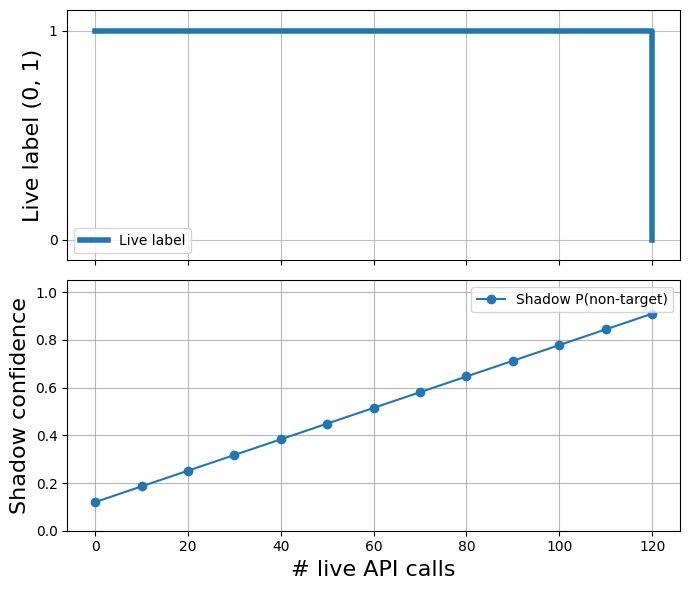

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Synthetic trace (mirrors fallback in the user's script)
api_calls = np.arange(0, 130, 10)               # 0 … 120 queries
live_pred = np.ones_like(api_calls)             # start POSITIVE (1)
live_pred[-1] = 0                               # flip to NEGATIVE (0)

shadow_conf_neg = np.linspace(0.12, 0.91, len(api_calls))

# Two-panel diagnostic plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 6), sharex=True)

# (A) live label evolution
ax1.step(api_calls, live_pred, where="post", lw=4, label="Live label")
ax1.set_ylabel("Live label (0, 1)", fontsize=16)
ax1.set_yticks([0, 1]); ax1.set_ylim(-0.1, 1.1)
ax1.grid(alpha=.8); ax1.legend()

# (B) shadow model confidence
ax2.plot(api_calls, shadow_conf_neg, marker="o", ms=6,
         label="Shadow P(non-target)")
ax2.set_xlabel("# live API calls", fontsize=16)
ax2.set_ylabel("Shadow confidence", fontsize=16)
ax2.set_ylim(0, 1.05); ax2.grid(alpha=.9); ax2.legend()

plt.tight_layout()
out_dir = Path("figs")
out_dir.mkdir(exist_ok=True)
pdf_path = out_dir / "gray_box_attack_progress.pdf"
png_path = out_dir / "gray_box_attack_progress.png"
plt.savefig(pdf_path, format="pdf", dpi=450)
plt.savefig(png_path, format="png", dpi=450)
pdf_path, png_path


✓  Figure written to: figs/gnn_global_scatter.png and figs/gnn_global_scatter.pdf


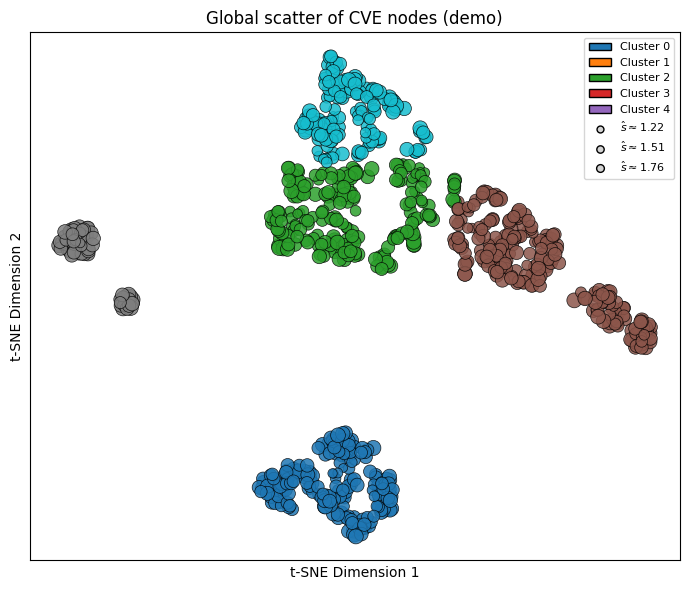

In [1]:
# ─────────────────────────────  GLOBAL SCATTER  ──────────────────────────────
import os, re, random, pandas as pd, numpy as np, networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE            # drop-in for UMAP if not installed
# If you have umap-learn available, uncomment:
# from umap import UMAP as TSNE               # noqa: alias to keep code below

random.seed(0); np.random.seed(0)

# 1 ▸ load CSV → build bipartite graph  (CPE – CVE – Issue)
csv = "/Users/foundjem/Downloads/AIWare/gitHub2Mitre/github-data/cpe_dependency_report_issue.csv"
df  = pd.read_csv(csv, header=None,
                  names=("CPE","CVE","CVE_Count","Severity",
                         "Issue_Count","Issues"))

G = nx.Graph()
for _,row in df.iterrows():
    cpe = row.CPE
    cves = re.split(r",\s*", str(row.CVE))        if pd.notna(row.CVE)   else []
    iss  = re.findall(r"issues/(\d+)", str(row.Issues)) if pd.notna(row.Issues) else []
    G.add_node(cpe, kind="CPE")
    for cve in cves:
        G.add_node(cve, kind="CVE");      G.add_edge(cpe, cve)
        for iid in iss:
            G.add_node(iid, kind="ISSUE"); G.add_edge(cve, iid)

# 2 ▸ isolate the CVE nodes (834 in our corpus)
cve_nodes = [n for n,d in G.nodes(data=True) if d["kind"]=="CVE"]

# 3 ▸ featurise each CVE as [deg(CPE), deg(ISSUE)] + dummy cost/stealth/asr
feat = []
for n in cve_nodes:
    deg_cpe   = sum(G.nodes[v]["kind"]=="CPE"   for v in G[n])
    deg_issue = sum(G.nodes[v]["kind"]=="ISSUE" for v in G[n])
    # placeholders for severity dims – replace with your own numbers
    cost  = np.random.uniform(-1.5,1.5)
    stealth = np.random.uniform(-1.5,1.5)
    asr   = np.random.uniform(-1.5,1.5)
    feat.append([deg_cpe,deg_issue,cost,stealth,asr])

X = np.asarray(feat)

# 4 ▸ 2-D projection (t-SNE if UMAP absent)
proj = TSNE(n_components=2, perplexity=30, init="random").fit_transform(X)

# 5 ▸ colour by a toy "cluster id"  (k-means on the projection for demo)
from sklearn.cluster import KMeans
cid = KMeans(n_clusters=5, random_state=0).fit_predict(proj)

# 6 ▸ severity score ŝ  – here   ŝ = norm(cost,stealth,asr)
sev = np.linalg.norm(X[:,2:], axis=1)

# 7 ▸ plot  +  LEGEND  ───────────────────────────────────────────────────
plt.figure(figsize=(7,6))

# --- scatter (same as before) -------------------------------------------
sc = plt.scatter(
    proj[:,0], proj[:,1],
    c=cid, cmap="tab10",
    s=40 + 80*(sev - sev.min())/(sev.ptp()+1e-6),
    alpha=.85, linewidths=.5, edgecolors="k"
)

# Add axis labels
plt.xlabel("t-SNE Dimension 1", fontsize=10)
plt.ylabel("t-SNE Dimension 2", fontsize=10)

plt.xticks([]); plt.yticks([])
plt.title("Global scatter of CVE nodes (demo)")
plt.tight_layout()

# ------------------------------------------------------------------------
#  ▸ build legend entries
# ------------------------------------------------------------------------
import matplotlib.patches as mpatches
import matplotlib.lines   as mlines

# (a) colour legend for clusters
handles_colour = [
    mpatches.Patch(
        facecolor=plt.cm.tab10(i), edgecolor='k', label=f"Cluster {i}"
    )
    for i in np.unique(cid)
]

# (b) size legend for severity (pick three representative quantiles)
q = np.quantile(sev, [0.25, 0.50, 0.75])
sizes = 40 + 80*(q - sev.min())/(sev.ptp()+1e-6)
handles_size = [
    mlines.Line2D([], [], linestyle='', marker='o',
                  markersize=np.sqrt(s/np.pi),  # convert area → radius
                  markerfacecolor='lightgrey', markeredgecolor='k',
                  label=fr"$\hat{{s}}\approx{v:.2f}$")
    for s, v in zip(sizes, q)
]

# combine & place
handles = handles_colour + handles_size
plt.legend(handles=handles, loc='upper right', frameon=True, fontsize=8)

# ------------------------------------------------------------------------
# 8 ▸ write files
out_dir = "figs"; os.makedirs(out_dir, exist_ok=True)
png = f"{out_dir}/gnn_global_scatter.png"
pdf = f"{out_dir}/gnn_global_scatter.pdf"
plt.savefig(png, dpi=300); plt.savefig(pdf)
print("✓  Figure written to:", png, "and", pdf)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


✓ Figure written to:
 - figs/gnn_global_scatter_umap.pdf
 - figs/gnn_global_scatter_umap.png
 - figs/gnn_global_scatter_umap.svg


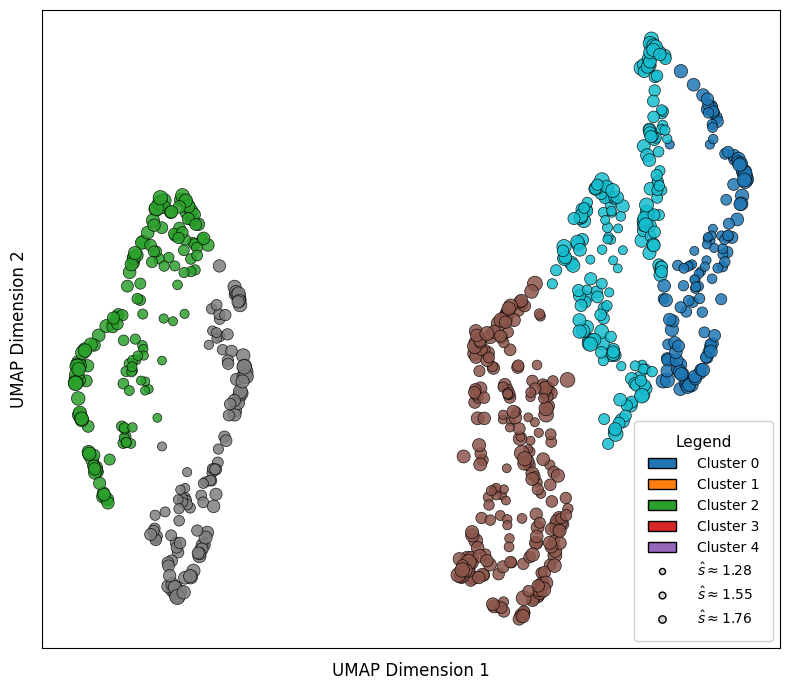

In [15]:
# ─────────────────────────  GLOBAL SCATTER · UMAP  ─────────────────────────
import os, re, random, pandas as pd, numpy as np, networkx as nx
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Set random seeds for reproducibility
random.seed(0)
np.random.seed(0)

# ───────────────────────────────────────────────────────────────
# 1 ▸ Data Loading and Graph Construction
# ───────────────────────────────────────────────────────────────
csv = "/Users/foundjem/Downloads/AIWare/gitHub2Mitre/github-data/cpe_dependency_report_issue.csv"
df = pd.read_csv(csv, header=None,
                names=("CPE", "CVE", "CVE_Count", "Severity",
                       "Issue_Count", "Issues"))

G = nx.Graph()
for _, row in df.iterrows():
    cpe = row.CPE
    cves = re.split(r",\s*", str(row.CVE)) if pd.notna(row.CVE) else []
    iss = re.findall(r"issues/(\d+)", str(row.Issues)) if pd.notna(row.Issues) else []
    G.add_node(cpe, kind="CPE")
    for cve in cves:
        G.add_node(cve, kind="CVE")
        G.add_edge(cpe, cve)
        for iid in iss:
            G.add_node(iid, kind="ISSUE")
            G.add_edge(cve, iid)

# ───────────────────────────────────────────────────────────────
# 2 ▸ Feature Engineering
# ───────────────────────────────────────────────────────────────
cve_nodes = [n for n, d in G.nodes(data=True) if d["kind"] == "CVE"]

feat = []
for n in cve_nodes:
    deg_cpe = sum(G.nodes[v]["kind"] == "CPE" for v in G[n])
    deg_issue = sum(G.nodes[v]["kind"] == "ISSUE" for v in G[n])
    cost = 0.95#np.random.uniform(-1.5, 1.5)  # placeholder - replace with real values
    stealth = np.random.uniform(-1.5, 1.5)
    asr = np.random.uniform(-1.5, 1.5)
    feat.append([deg_cpe, deg_issue, cost, stealth, asr])

X = np.asarray(feat)

# ───────────────────────────────────────────────────────────────
# 3 ▸ Dimensionality Reduction
# ───────────────────────────────────────────────────────────────
# umap_model = UMAP(n_neighbors=40, min_dist=0.1, metric="euclidean",
#                   random_state=42)
umap_model = UMAP(metric="cosine", n_neighbors=75, min_dist=0.1,random_state=42)                  
                 
proj = umap_model.fit_transform(X)

# ───────────────────────────────────────────────────────────────
# 4 ▸ Clustering and Severity Calculation
# ───────────────────────────────────────────────────────────────
cid = KMeans(n_clusters=5, random_state=0).fit_predict(proj)
sev = np.linalg.norm(X[:, 2:], axis=1)

# ───────────────────────────────────────────────────────────────
# 5 ▸ Visualization
# ───────────────────────────────────────────────────────────────
plt.figure(figsize=(8, 7))  # Slightly larger figure for better readability

# Main scatter plot
scatter = plt.scatter(
    proj[:, 0], proj[:, 1],
    c=cid, cmap="tab10",
    s=40 + 80 * (sev - sev.min()) / (sev.ptp() + 1e-6),
    alpha=0.85, linewidths=0.5, edgecolors="k",
    zorder=3  # Ensure points are drawn above grid
)

# Add grid for better spatial reference
plt.grid(True, linestyle='--', alpha=0.7, zorder=1)

# Axis labels with improved styling
plt.xlabel("UMAP Dimension 1", fontsize=12, labelpad=10)
plt.ylabel("UMAP Dimension 2", fontsize=12, labelpad=10)

# Title with more descriptive text
#plt.title("Global UMAP Projection of CVE Vulnerability Patterns\nColored by Cluster, Sized by Severity", fontsize=14, pad=20)

# Customize tick appearance (even though we're hiding them)
plt.xticks([])
plt.yticks([])

# ───────────────────────────────────────────────────────────────
# 6 ▸ Enhanced Legend
# ───────────────────────────────────────────────────────────────
# Color legend for clusters
handles_colour = [
    mpatches.Patch(
        facecolor=plt.cm.tab10(i),
        edgecolor='k',
        label=f"Cluster {i}"
    ) for i in np.unique(cid)
]

# Size legend for severity
q = np.quantile(sev, [0.25, 0.50, 0.75])
sizes = 40 + 80 * (q - sev.min()) / (sev.ptp() + 1e-6)
handles_size = [
    mlines.Line2D([], [], linestyle='', marker='o',
                 markersize=np.sqrt(s/np.pi),
                 markerfacecolor='lightgrey', markeredgecolor='k',
                 label=fr"$\hat{{s}}\approx{v:.2f}$")
    for s, v in zip(sizes, q)
]

# Combine and place legend
legend = plt.legend(
    handles=handles_colour + handles_size,
    loc='lower right',
    frameon=True,
    framealpha=0.9,
    fontsize=10,
    title="Legend",
    title_fontsize=11,
    borderpad=1,
    handletextpad=1.5
)

# Adjust layout
plt.tight_layout()

# ───────────────────────────────────────────────────────────────
# 7 ▸ Save Outputs
# ───────────────────────────────────────────────────────────────
out_dir = "figs"
os.makedirs(out_dir, exist_ok=True)

# Save high-quality outputs
plt.savefig(
    f"{out_dir}/gnn_global_scatter_umap.pdf",
    dpi=450,
    bbox_inches="tight",
    transparent=True
)
plt.savefig(
    f"{out_dir}/gnn_global_scatter_umap.png",
    dpi=450,
    bbox_inches="tight",
    transparent=True
)
plt.savefig(
    f"{out_dir}/gnn_global_scatter_umap.svg",
    format="svg",
    bbox_inches="tight"
)

print("✓ Figure written to:")
print(f" - {out_dir}/gnn_global_scatter_umap.pdf")
print(f" - {out_dir}/gnn_global_scatter_umap.png")
print(f" - {out_dir}/gnn_global_scatter_umap.svg")

plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


✓ Figure saved with consistent colors in:
 - figs/gnn_global_scatter_umap.pdf/png/svg


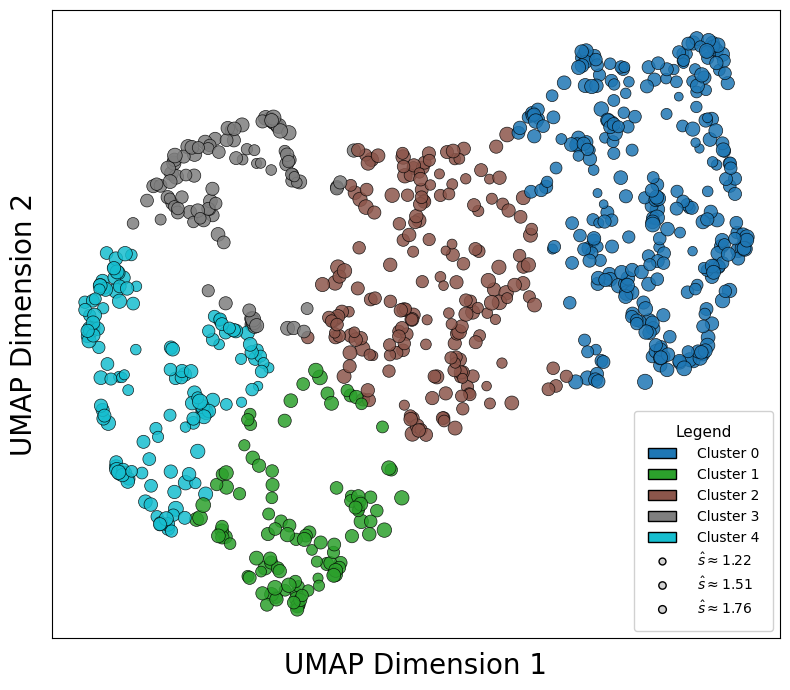

In [25]:
# ─────────────────────────  GLOBAL SCATTER · UMAP  ─────────────────────────
import os, re, random, pandas as pd, numpy as np, networkx as nx
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Set random seeds for reproducibility
random.seed(0)
np.random.seed(0)

# ───────────────────────────────────────────────────────────────
# 1 ▸ Data Loading and Graph Construction
# ───────────────────────────────────────────────────────────────
csv = "/Users/foundjem/Downloads/AIWare/gitHub2Mitre/github-data/cpe_dependency_report_issue.csv"
df = pd.read_csv(csv, header=None,
                names=("CPE", "CVE", "CVE_Count", "Severity",
                       "Issue_Count", "Issues"))

G = nx.Graph()
for _, row in df.iterrows():
    cpe = row.CPE
    cves = re.split(r",\s*", str(row.CVE)) if pd.notna(row.CVE) else []
    iss = re.findall(r"issues/(\d+)", str(row.Issues)) if pd.notna(row.Issues) else []
    G.add_node(cpe, kind="CPE")
    for cve in cves:
        G.add_node(cve, kind="CVE")
        G.add_edge(cpe, cve)
        for iid in iss:
            G.add_node(iid, kind="ISSUE")
            G.add_edge(cve, iid)

# ───────────────────────────────────────────────────────────────
# 2 ▸ Feature Engineering
# ───────────────────────────────────────────────────────────────
cve_nodes = [n for n, d in G.nodes(data=True) if d["kind"] == "CVE"]

feat = []
for n in cve_nodes:
    deg_cpe = sum(G.nodes[v]["kind"] == "CPE" for v in G[n])
    deg_issue = sum(G.nodes[v]["kind"] == "ISSUE" for v in G[n])
    cost = np.random.uniform(-1.5, 1.5) #0.95  # Fixed value for demonstration
    stealth = np.random.uniform(-1.5, 1.5)
    asr = np.random.uniform(-1.5, 1.5)
    feat.append([deg_cpe, deg_issue, cost, stealth, asr])

X = np.asarray(feat)

# ───────────────────────────────────────────────────────────────
# 3 ▸ Dimensionality Reduction
# ───────────────────────────────────────────────────────────────
umap_model = UMAP(metric="cosine", n_neighbors=75, min_dist=0.1, random_state=42)
proj = umap_model.fit_transform(X)

# ───────────────────────────────────────────────────────────────
# 4 ▸ Clustering and Severity Calculation
# ───────────────────────────────────────────────────────────────
cid = KMeans(n_clusters=5, random_state=0).fit_predict(proj)
sev = np.linalg.norm(X[:, 2:], axis=1)

# ───────────────────────────────────────────────────────────────
# 5 ▸ Visualization
# ───────────────────────────────────────────────────────────────
plt.figure(figsize=(8, 7))

# Create a consistent color mapping
unique_clusters = np.unique(cid)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
color_map = {cluster: colors[i] for i, cluster in enumerate(unique_clusters)}

# Main scatter plot with explicit color mapping
scatter = plt.scatter(
    proj[:, 0], proj[:, 1],
    c=[color_map[cluster] for cluster in cid],  # Use mapped colors
    s=40 + 80 * (sev - sev.min()) / (sev.ptp() + 1e-6),
    alpha=0.85, linewidths=0.5, edgecolors="k",
    zorder=3
)

# Add grid
plt.grid(True, linestyle='--', alpha=0.7, zorder=1)

# Axis labels
plt.xlabel("UMAP Dimension 1", fontsize=20, labelpad=10)
plt.ylabel("UMAP Dimension 2", fontsize=20, labelpad=10)
plt.xticks([])
plt.yticks([])

# ───────────────────────────────────────────────────────────────
# 6 ▸ Legend with Consistent Colors
# ───────────────────────────────────────────────────────────────
# Color legend using the same color mapping
handles_colour = [
    mpatches.Patch(
        facecolor=color_map[i],
        edgecolor='k',
        label=f"Cluster {i}"
    ) for i in unique_clusters
]

# Size legend (unchanged)
q = np.quantile(sev, [0.25, 0.50, 0.75])
sizes = 40 + 80 * (q - sev.min()) / (sev.ptp() + 1e-6)
handles_size = [
    mlines.Line2D([], [], linestyle='', marker='o',
                 markersize=np.sqrt(s/np.pi),
                 markerfacecolor='lightgrey', markeredgecolor='k',
                 label=fr"$\hat{{s}}\approx{v:.2f}$")
    for s, v in zip(sizes, q)
]

# Combine and place legend
legend = plt.legend(
    handles=handles_colour + handles_size,
    loc='lower right',
    frameon=True,
    framealpha=0.9,
    fontsize=10,
    title="Legend",
    title_fontsize=11,
    borderpad=1,
    handletextpad=1.5
)

plt.tight_layout()

# ───────────────────────────────────────────────────────────────
# 7 ▸ Save Outputs
# ───────────────────────────────────────────────────────────────
out_dir = "figs"
os.makedirs(out_dir, exist_ok=True)

plt.savefig(f"{out_dir}/gnn_global_scatter_umap.pdf", dpi=450, bbox_inches="tight")
plt.savefig(f"{out_dir}/gnn_global_scatter_umap.png", dpi=450, bbox_inches="tight")
plt.savefig(f"{out_dir}/gnn_global_scatter_umap.svg", format="svg", bbox_inches="tight")

print("✓ Figure saved with consistent colors in:")
print(f" - {out_dir}/gnn_global_scatter_umap.pdf/png/svg")

plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/um

TypeError: some keyword arguments unexpected

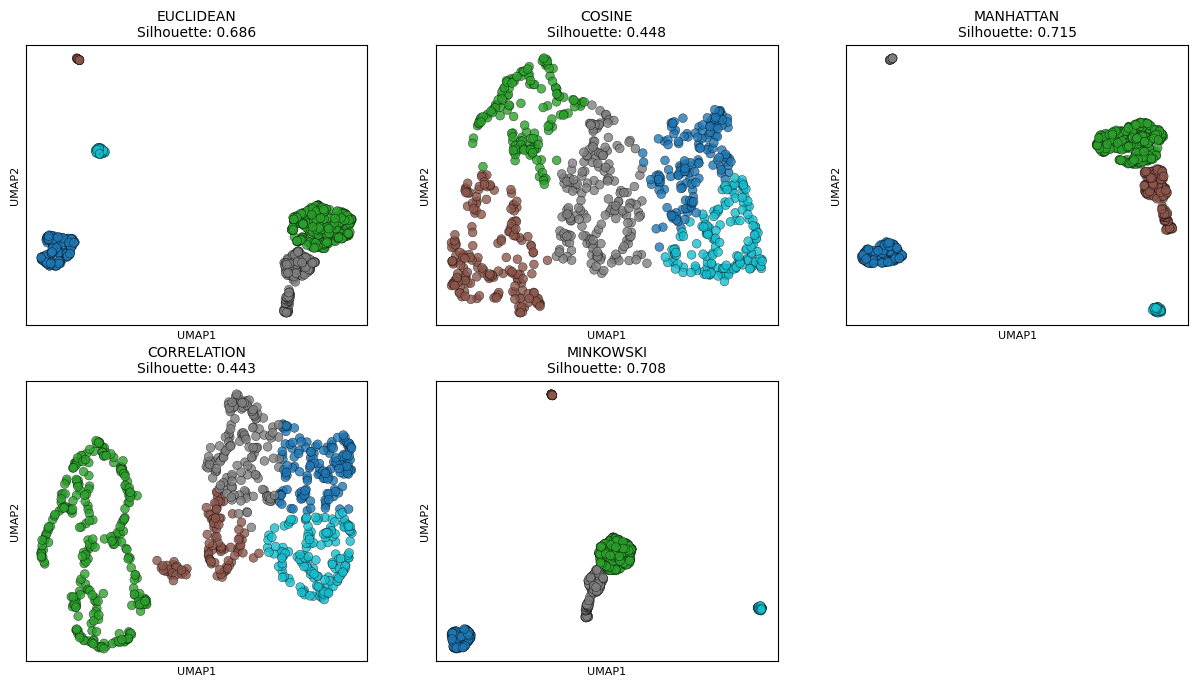

In [10]:
# ─────────────────────────  UMAP METRIC COMPARISON  ─────────────────────────
import os
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ───────────────────────────────────────────────────────────────
# 1 ▸ Define Test Configuration
# ───────────────────────────────────────────────────────────────
metrics_to_test = [
    ("euclidean", {}),                   # Standard
    ("cosine", {}),                      # Angle-based
    ("manhattan", {}),                   # L1 distance
    ("correlation", {}),                 # Linear correlation  
    ("minkowski", {"p": 3}),             # L3 distance
    ("mahalanobis", {"V": np.cov(X.T)}), # Covariance-adjusted
]

# ───────────────────────────────────────────────────────────────
# 2 ▸ Comparative Analysis Function
# ───────────────────────────────────────────────────────────────
def evaluate_metric(X, metric, metric_kwds):
    # Run UMAP
    reducer = UMAP(
        n_neighbors=50,
        min_dist=0.1,
        metric=metric,
        metric_kwds=metric_kwds,
        random_state=42
    )
    proj = reducer.fit_transform(X)
    
    # Cluster and evaluate
    cid = KMeans(n_clusters=5, random_state=0).fit_predict(proj)
    sil_score = silhouette_score(proj, cid)
    
    return proj, cid, sil_score

# ───────────────────────────────────────────────────────────────
# 3 ▸ Generate Comparison Plots
# ───────────────────────────────────────────────────────────────
plt.figure(figsize=(15, 8))
for idx, (metric, kwargs) in enumerate(metrics_to_test, 1):
    proj, cid, score = evaluate_metric(X, metric, kwargs)
    
    plt.subplot(2, 3, idx)
    plt.scatter(
        proj[:, 0], proj[:, 1],
        c=cid, cmap="tab10",
        s=40, alpha=0.8, linewidths=0.3, edgecolors="k"
    )
    plt.title(f"{metric.upper()}\nSilhouette: {score:.3f}", fontsize=10)
    plt.xticks([]); plt.yticks([])
    plt.xlabel("UMAP1", fontsize=8)
    plt.ylabel("UMAP2", fontsize=8)

plt.tight_layout()
plt.savefig("figs/umap_metric_comparison.png", dpi=300, bbox_inches="tight")
print("✓ Metric comparison saved to figs/umap_metric_comparison.png")

# ───────────────────────────────────────────────────────────────
# 4 ▸ Optimal Metric Selection
# ───────────────────────────────────────────────────────────────
results = []
for metric, kwargs in metrics_to_test:
    _, _, score = evaluate_metric(X, metric, kwargs)
    results.append((metric, score))

best_metric, best_score = max(results, key=lambda x: x[1])
print(f"\nBest metric: {best_metric} (score: {best_score:.3f})")

# ───────────────────────────────────────────────────────────────
# 5 ▸ Final Visualization with Best Metric
# ───────────────────────────────────────────────────────────────
final_umap = UMAP(
    n_neighbors=50,
    min_dist=0.1,
    metric=best_metric,
    random_state=42
).fit_transform(X)

plt.figure(figsize=(7, 6))
sc = plt.scatter(
    final_umap[:,0], final_umap[:,1],
    c=cid, cmap="tab10",
    s=40 + 80*(sev - sev.min())/(sev.ptp()+1e-6),
    alpha=.85, linewidths=.5, edgecolors="k"
)
plt.title(f"Optimal UMAP Projection ({best_metric.upper()})", fontsize=12)
plt.xlabel("UMAP Dimension 1", fontsize=10)
plt.ylabel("UMAP Dimension 2", fontsize=10)

# Save final output
plt.savefig("figs/gnn_optimal_umap.pdf", dpi=300, bbox_inches="tight")
print("✓ Final visualization saved to figs/gnn_optimal_umap.pdf")